Using the constrcuted dataset to test out the NIPS debiasing method

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

DATA_ROOT = Path("../data")

In [4]:
from bert_utils import Config, BertPreprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [6]:
# Parameters
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"


In [7]:
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    subspace_size=5,
)

In [8]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [9]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

In [10]:
from dataclasses import dataclass

@dataclass
class ContextWord:
    sent: str
    word: str
    def __post_init__(self):
        assert self.word in self.sent

In [11]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [12]:
def get_word_vector(cword: ContextWord, use_last_mask=False):
    sentence, word = cword.sent, cword.word
    idx = processor.get_index(sentence, word, last=use_last_mask)
    outputs = None
    with torch.no_grad():
        # TODO: Move to proper library function
        token_ids = processor.to_bert_model_input(sentence) 
        # ensure padding is consistent
        bert_input = torch.zeros(1, config.max_seq_len, dtype=torch.long)
        bert_input[0, :token_ids.size(1)] = token_ids
        sequence_output, _ = model.bert(bert_input,
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
        if outputs is None: outputs = torch.zeros_like(sequence_output)
        outputs = sequence_output + outputs
    return outputs.detach().cpu().numpy()[idx]

In [13]:
def construct_sim_matrix(vecs):
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v in enumerate(vecs):
        for j, w in enumerate(vecs):
            sim_matrix[i, j] = cosine_similarity(v, w)
    return sim_matrix

In [14]:
def construct_sim_matrix_df(sentences: List[str],
                           words: List[str]):
    sim = construct_sim_matrix([get_word_vector(ContextWord(sent, word)) for sent, word in zip(sentences, words)])
    return pd.DataFrame(data=sim, index=words, columns=words)

In [15]:
def compute_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(get_word_vector(cword11) - get_word_vector(cword12),
                             get_word_vector(cword21) - get_word_vector(cword22))

In [16]:
out_softmax = model.cls.predictions.decoder.weight.data.cpu().numpy()

In [17]:
out_bias = model.cls.predictions.bias.data.cpu().numpy()

In [18]:
def to_logits(wv: np.ndarray) -> np.ndarray:
    return model.cls(torch.FloatTensor(wv).unsqueeze(0)).detach().cpu().numpy()[0, :]

# Check similarities

In [19]:
construct_sim_matrix_df(["That person is a programmer.", 
                         "I am a man.", 
                         "I am a woman."],
                       ["programmer", "man", "woman"])

,programmer,man,woman
programmer,1.000000,0.453046,0.488973
man,0.453046,1.000000,0.781821
woman,0.488973,0.781821,1.000000


In [20]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.13653895

In [21]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.20923696

In [22]:
compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.21795174

# Find gendered direction

In [23]:
df_train = pd.read_csv(DATA_ROOT / train_file)

In [24]:
df_val = pd.read_csv(DATA_ROOT / val_file)

In [25]:
from tqdm import tqdm

male_vecs, female_vecs = [], []
def add_word_vecs(s: str, male_w: str, female_w: str):
    male_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", male_w), male_w)))
    female_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", female_w), female_w)))

for i, row in tqdm(list(df_train.iterrows())):
    sentence = row["sentence"]
    add_word_vecs(sentence, row["mword"], row["fword"])

  0%|          | 0/2484 [00:00<?, ?it/s]

  0%|          | 1/2484 [00:00<10:13,  4.05it/s]

  0%|          | 2/2484 [00:00<10:20,  4.00it/s]

  0%|          | 3/2484 [00:00<09:17,  4.45it/s]

  0%|          | 4/2484 [00:00<08:31,  4.85it/s]

  0%|          | 5/2484 [00:01<09:13,  4.47it/s]

  0%|          | 6/2484 [00:01<10:18,  4.01it/s]

  0%|          | 7/2484 [00:01<10:22,  3.98it/s]

  0%|          | 8/2484 [00:01<10:07,  4.08it/s]

  0%|          | 9/2484 [00:02<09:50,  4.19it/s]

  0%|          | 10/2484 [00:02<09:29,  4.34it/s]

  0%|          | 11/2484 [00:02<09:11,  4.48it/s]

  0%|          | 12/2484 [00:02<09:21,  4.40it/s]

  1%|          | 13/2484 [00:02<09:08,  4.50it/s]

  1%|          | 14/2484 [00:03<09:00,  4.57it/s]

  1%|          | 15/2484 [00:03<08:55,  4.61it/s]

  1%|          | 16/2484 [00:03<08:50,  4.65it/s]

  1%|          | 17/2484 [00:03<08:57,  4.59it/s]

  1%|          | 18/2484 [00:04<08:48,  4.66it/s]

  1%|          | 19/2484 [00:04<08:46,  4.69it/s]

  1%|          | 20/2484 [00:04<08:43,  4.71it/s]

  1%|          | 21/2484 [00:04<08:44,  4.69it/s]

  1%|          | 22/2484 [00:04<08:50,  4.64it/s]

  1%|          | 23/2484 [00:05<08:50,  4.64it/s]

  1%|          | 24/2484 [00:05<08:24,  4.88it/s]

  1%|          | 25/2484 [00:05<08:08,  5.03it/s]

  1%|          | 26/2484 [00:05<07:48,  5.25it/s]

  1%|          | 27/2484 [00:05<07:35,  5.40it/s]

  1%|          | 28/2484 [00:06<07:31,  5.44it/s]

  1%|          | 29/2484 [00:06<07:19,  5.58it/s]

  1%|          | 30/2484 [00:06<07:08,  5.73it/s]

  1%|          | 31/2484 [00:06<07:08,  5.73it/s]

  1%|▏         | 32/2484 [00:06<07:03,  5.78it/s]

  1%|▏         | 33/2484 [00:06<07:02,  5.80it/s]

  1%|▏         | 34/2484 [00:07<06:59,  5.84it/s]

  1%|▏         | 35/2484 [00:07<07:03,  5.78it/s]

  1%|▏         | 36/2484 [00:07<07:07,  5.73it/s]

  1%|▏         | 37/2484 [00:07<07:16,  5.61it/s]

  2%|▏         | 38/2484 [00:07<07:17,  5.59it/s]

  2%|▏         | 39/2484 [00:07<07:29,  5.44it/s]

  2%|▏         | 40/2484 [00:08<07:28,  5.45it/s]

  2%|▏         | 41/2484 [00:08<07:22,  5.52it/s]

  2%|▏         | 42/2484 [00:08<07:22,  5.52it/s]

  2%|▏         | 43/2484 [00:08<07:27,  5.46it/s]

  2%|▏         | 44/2484 [00:08<07:37,  5.33it/s]

  2%|▏         | 45/2484 [00:09<07:44,  5.25it/s]

  2%|▏         | 46/2484 [00:09<07:46,  5.22it/s]

  2%|▏         | 47/2484 [00:09<07:48,  5.20it/s]

  2%|▏         | 48/2484 [00:09<08:07,  5.00it/s]

  2%|▏         | 49/2484 [00:09<08:19,  4.87it/s]

  2%|▏         | 50/2484 [00:10<08:19,  4.87it/s]

  2%|▏         | 51/2484 [00:10<08:22,  4.85it/s]

  2%|▏         | 52/2484 [00:10<08:41,  4.66it/s]

  2%|▏         | 53/2484 [00:10<08:46,  4.61it/s]

  2%|▏         | 54/2484 [00:11<09:25,  4.30it/s]

  2%|▏         | 55/2484 [00:11<09:52,  4.10it/s]

  2%|▏         | 56/2484 [00:11<09:47,  4.13it/s]

  2%|▏         | 57/2484 [00:11<09:04,  4.46it/s]

  2%|▏         | 58/2484 [00:11<08:57,  4.51it/s]

  2%|▏         | 59/2484 [00:12<10:22,  3.89it/s]

  2%|▏         | 60/2484 [00:12<10:01,  4.03it/s]

  2%|▏         | 61/2484 [00:12<09:29,  4.26it/s]

  2%|▏         | 62/2484 [00:12<09:23,  4.30it/s]

  3%|▎         | 63/2484 [00:13<09:12,  4.38it/s]

  3%|▎         | 64/2484 [00:13<09:08,  4.41it/s]

  3%|▎         | 65/2484 [00:13<08:54,  4.52it/s]

  3%|▎         | 66/2484 [00:13<09:11,  4.38it/s]

  3%|▎         | 67/2484 [00:14<09:24,  4.28it/s]

  3%|▎         | 68/2484 [00:14<09:19,  4.32it/s]

  3%|▎         | 69/2484 [00:14<09:09,  4.40it/s]

  3%|▎         | 70/2484 [00:14<08:54,  4.52it/s]

  3%|▎         | 71/2484 [00:14<08:59,  4.48it/s]

  3%|▎         | 72/2484 [00:15<08:47,  4.57it/s]

  3%|▎         | 73/2484 [00:15<08:55,  4.50it/s]

  3%|▎         | 74/2484 [00:15<09:20,  4.30it/s]

  3%|▎         | 75/2484 [00:15<09:20,  4.30it/s]

  3%|▎         | 76/2484 [00:16<09:05,  4.42it/s]

  3%|▎         | 77/2484 [00:16<08:44,  4.59it/s]

  3%|▎         | 78/2484 [00:16<08:43,  4.59it/s]

  3%|▎         | 79/2484 [00:16<08:22,  4.78it/s]

  3%|▎         | 80/2484 [00:16<08:38,  4.64it/s]

  3%|▎         | 81/2484 [00:17<09:16,  4.31it/s]

  3%|▎         | 82/2484 [00:17<08:46,  4.57it/s]

  3%|▎         | 83/2484 [00:17<08:11,  4.88it/s]

  3%|▎         | 84/2484 [00:17<08:00,  4.99it/s]

  3%|▎         | 85/2484 [00:17<07:43,  5.18it/s]

  3%|▎         | 86/2484 [00:18<07:25,  5.38it/s]

  4%|▎         | 87/2484 [00:18<07:14,  5.51it/s]

  4%|▎         | 88/2484 [00:18<07:05,  5.62it/s]

  4%|▎         | 89/2484 [00:18<06:55,  5.76it/s]

  4%|▎         | 90/2484 [00:18<07:11,  5.54it/s]

  4%|▎         | 91/2484 [00:18<07:10,  5.56it/s]

  4%|▎         | 92/2484 [00:19<07:05,  5.62it/s]

  4%|▎         | 93/2484 [00:19<07:07,  5.60it/s]

  4%|▍         | 94/2484 [00:19<07:06,  5.60it/s]

  4%|▍         | 95/2484 [00:19<07:10,  5.55it/s]

  4%|▍         | 96/2484 [00:19<07:15,  5.49it/s]

  4%|▍         | 97/2484 [00:20<07:10,  5.55it/s]

  4%|▍         | 98/2484 [00:20<07:26,  5.35it/s]

  4%|▍         | 99/2484 [00:20<07:22,  5.39it/s]

  4%|▍         | 100/2484 [00:20<07:20,  5.41it/s]

  4%|▍         | 101/2484 [00:20<07:17,  5.45it/s]

  4%|▍         | 102/2484 [00:20<07:17,  5.44it/s]

  4%|▍         | 103/2484 [00:21<07:27,  5.33it/s]

  4%|▍         | 104/2484 [00:21<07:42,  5.15it/s]

  4%|▍         | 105/2484 [00:21<07:42,  5.15it/s]

  4%|▍         | 106/2484 [00:21<08:22,  4.73it/s]

  4%|▍         | 107/2484 [00:22<08:31,  4.65it/s]

  4%|▍         | 108/2484 [00:22<08:17,  4.77it/s]

  4%|▍         | 109/2484 [00:22<08:28,  4.67it/s]

  4%|▍         | 110/2484 [00:22<08:09,  4.85it/s]

  4%|▍         | 111/2484 [00:22<07:42,  5.13it/s]

  5%|▍         | 112/2484 [00:23<07:36,  5.20it/s]

  5%|▍         | 113/2484 [00:23<08:24,  4.70it/s]

  5%|▍         | 114/2484 [00:23<08:11,  4.82it/s]

  5%|▍         | 115/2484 [00:23<08:03,  4.90it/s]

  5%|▍         | 116/2484 [00:23<08:29,  4.65it/s]

  5%|▍         | 117/2484 [00:24<08:49,  4.47it/s]

  5%|▍         | 118/2484 [00:24<08:32,  4.62it/s]

  5%|▍         | 119/2484 [00:24<08:22,  4.71it/s]

  5%|▍         | 120/2484 [00:24<08:47,  4.48it/s]

  5%|▍         | 121/2484 [00:25<08:50,  4.45it/s]

  5%|▍         | 122/2484 [00:25<09:03,  4.34it/s]

  5%|▍         | 123/2484 [00:25<08:57,  4.39it/s]

  5%|▍         | 124/2484 [00:25<08:58,  4.38it/s]

  5%|▌         | 125/2484 [00:25<08:47,  4.47it/s]

  5%|▌         | 126/2484 [00:26<08:25,  4.66it/s]

  5%|▌         | 127/2484 [00:26<08:04,  4.86it/s]

  5%|▌         | 128/2484 [00:26<07:47,  5.04it/s]

  5%|▌         | 129/2484 [00:26<07:39,  5.12it/s]

  5%|▌         | 130/2484 [00:26<07:48,  5.03it/s]

  5%|▌         | 131/2484 [00:27<07:35,  5.17it/s]

  5%|▌         | 132/2484 [00:27<07:16,  5.38it/s]

  5%|▌         | 133/2484 [00:27<07:01,  5.58it/s]

  5%|▌         | 134/2484 [00:27<06:48,  5.75it/s]

  5%|▌         | 135/2484 [00:27<06:36,  5.92it/s]

  5%|▌         | 136/2484 [00:27<06:34,  5.95it/s]

  6%|▌         | 137/2484 [00:28<06:29,  6.03it/s]

  6%|▌         | 138/2484 [00:28<06:28,  6.03it/s]

  6%|▌         | 139/2484 [00:28<06:27,  6.06it/s]

  6%|▌         | 140/2484 [00:28<06:23,  6.11it/s]

  6%|▌         | 141/2484 [00:28<06:23,  6.11it/s]

  6%|▌         | 142/2484 [00:28<06:22,  6.12it/s]

  6%|▌         | 143/2484 [00:29<06:20,  6.16it/s]

  6%|▌         | 144/2484 [00:29<06:19,  6.17it/s]

  6%|▌         | 145/2484 [00:29<06:18,  6.19it/s]

  6%|▌         | 146/2484 [00:29<06:26,  6.05it/s]

  6%|▌         | 147/2484 [00:29<06:26,  6.05it/s]

  6%|▌         | 148/2484 [00:29<06:29,  5.99it/s]

  6%|▌         | 149/2484 [00:30<06:29,  5.99it/s]

  6%|▌         | 150/2484 [00:30<06:31,  5.96it/s]

  6%|▌         | 151/2484 [00:30<06:33,  5.93it/s]

  6%|▌         | 152/2484 [00:30<06:37,  5.87it/s]

  6%|▌         | 153/2484 [00:30<06:37,  5.86it/s]

  6%|▌         | 154/2484 [00:30<07:18,  5.32it/s]

  6%|▌         | 155/2484 [00:31<07:21,  5.27it/s]

  6%|▋         | 156/2484 [00:31<07:22,  5.26it/s]

  6%|▋         | 157/2484 [00:31<07:20,  5.29it/s]

  6%|▋         | 158/2484 [00:31<07:18,  5.30it/s]

  6%|▋         | 159/2484 [00:31<07:17,  5.31it/s]

  6%|▋         | 160/2484 [00:32<07:18,  5.30it/s]

  6%|▋         | 161/2484 [00:32<07:14,  5.34it/s]

  7%|▋         | 162/2484 [00:32<07:14,  5.34it/s]

  7%|▋         | 163/2484 [00:32<07:13,  5.36it/s]

  7%|▋         | 164/2484 [00:32<07:11,  5.38it/s]

  7%|▋         | 165/2484 [00:33<07:36,  5.08it/s]

  7%|▋         | 166/2484 [00:33<07:41,  5.02it/s]

  7%|▋         | 167/2484 [00:33<07:11,  5.37it/s]

  7%|▋         | 168/2484 [00:33<06:57,  5.54it/s]

  7%|▋         | 169/2484 [00:33<07:36,  5.07it/s]

  7%|▋         | 170/2484 [00:34<07:52,  4.90it/s]

  7%|▋         | 171/2484 [00:34<07:32,  5.11it/s]

  7%|▋         | 172/2484 [00:34<07:26,  5.18it/s]

  7%|▋         | 173/2484 [00:34<07:16,  5.29it/s]

  7%|▋         | 174/2484 [00:34<07:13,  5.33it/s]

  7%|▋         | 175/2484 [00:34<07:11,  5.35it/s]

  7%|▋         | 176/2484 [00:35<07:09,  5.37it/s]

  7%|▋         | 177/2484 [00:35<07:07,  5.39it/s]

  7%|▋         | 178/2484 [00:35<07:03,  5.45it/s]

  7%|▋         | 179/2484 [00:35<07:17,  5.27it/s]

  7%|▋         | 180/2484 [00:35<07:29,  5.13it/s]

  7%|▋         | 181/2484 [00:36<07:25,  5.16it/s]

  7%|▋         | 182/2484 [00:36<07:14,  5.30it/s]

  7%|▋         | 183/2484 [00:36<07:07,  5.38it/s]

  7%|▋         | 184/2484 [00:36<07:02,  5.44it/s]

  7%|▋         | 185/2484 [00:36<07:02,  5.44it/s]

  7%|▋         | 186/2484 [00:36<07:01,  5.45it/s]

  8%|▊         | 187/2484 [00:37<07:02,  5.44it/s]

  8%|▊         | 188/2484 [00:37<07:02,  5.44it/s]

  8%|▊         | 189/2484 [00:37<06:59,  5.47it/s]

  8%|▊         | 190/2484 [00:37<06:48,  5.61it/s]

  8%|▊         | 191/2484 [00:37<06:41,  5.71it/s]

  8%|▊         | 192/2484 [00:38<06:31,  5.85it/s]

  8%|▊         | 193/2484 [00:38<06:23,  5.97it/s]

  8%|▊         | 194/2484 [00:38<06:23,  5.97it/s]

  8%|▊         | 195/2484 [00:38<06:17,  6.06it/s]

  8%|▊         | 196/2484 [00:38<06:13,  6.13it/s]

  8%|▊         | 197/2484 [00:38<06:10,  6.17it/s]

  8%|▊         | 198/2484 [00:39<06:09,  6.18it/s]

  8%|▊         | 199/2484 [00:39<06:08,  6.20it/s]

  8%|▊         | 200/2484 [00:39<06:07,  6.22it/s]

  8%|▊         | 201/2484 [00:39<06:06,  6.23it/s]

  8%|▊         | 202/2484 [00:39<06:07,  6.21it/s]

  8%|▊         | 203/2484 [00:39<06:09,  6.17it/s]

  8%|▊         | 204/2484 [00:39<06:15,  6.07it/s]

  8%|▊         | 205/2484 [00:40<06:17,  6.03it/s]

  8%|▊         | 206/2484 [00:40<06:18,  6.02it/s]

  8%|▊         | 207/2484 [00:40<06:17,  6.03it/s]

  8%|▊         | 208/2484 [00:40<06:20,  5.98it/s]

  8%|▊         | 209/2484 [00:40<06:29,  5.84it/s]

  8%|▊         | 210/2484 [00:41<06:32,  5.79it/s]

  8%|▊         | 211/2484 [00:41<06:34,  5.76it/s]

  9%|▊         | 212/2484 [00:41<06:47,  5.58it/s]

  9%|▊         | 213/2484 [00:41<06:47,  5.57it/s]

  9%|▊         | 214/2484 [00:41<06:49,  5.54it/s]

  9%|▊         | 215/2484 [00:41<06:52,  5.50it/s]

  9%|▊         | 216/2484 [00:42<06:51,  5.51it/s]

  9%|▊         | 217/2484 [00:42<06:45,  5.59it/s]

  9%|▉         | 218/2484 [00:42<06:41,  5.65it/s]

  9%|▉         | 219/2484 [00:42<06:38,  5.68it/s]

  9%|▉         | 220/2484 [00:42<06:40,  5.65it/s]

  9%|▉         | 221/2484 [00:42<06:48,  5.54it/s]

  9%|▉         | 222/2484 [00:43<06:47,  5.55it/s]

  9%|▉         | 223/2484 [00:43<06:58,  5.40it/s]

  9%|▉         | 224/2484 [00:43<07:09,  5.26it/s]

  9%|▉         | 225/2484 [00:43<07:24,  5.08it/s]

  9%|▉         | 226/2484 [00:43<07:20,  5.13it/s]

  9%|▉         | 227/2484 [00:44<07:35,  4.95it/s]

  9%|▉         | 228/2484 [00:44<09:51,  3.81it/s]

  9%|▉         | 229/2484 [00:44<10:40,  3.52it/s]

  9%|▉         | 230/2484 [00:45<09:52,  3.80it/s]

  9%|▉         | 231/2484 [00:45<09:37,  3.90it/s]

  9%|▉         | 232/2484 [00:45<10:10,  3.69it/s]

  9%|▉         | 233/2484 [00:45<10:06,  3.71it/s]

  9%|▉         | 234/2484 [00:46<09:19,  4.02it/s]

  9%|▉         | 235/2484 [00:46<08:58,  4.17it/s]

 10%|▉         | 236/2484 [00:46<08:39,  4.33it/s]

 10%|▉         | 237/2484 [00:46<08:29,  4.41it/s]

 10%|▉         | 238/2484 [00:47<09:41,  3.86it/s]

 10%|▉         | 239/2484 [00:47<10:26,  3.59it/s]

 10%|▉         | 240/2484 [00:47<09:35,  3.90it/s]

 10%|▉         | 241/2484 [00:47<08:55,  4.19it/s]

 10%|▉         | 242/2484 [00:48<08:34,  4.35it/s]

 10%|▉         | 243/2484 [00:48<08:19,  4.48it/s]

 10%|▉         | 244/2484 [00:48<07:50,  4.76it/s]

 10%|▉         | 245/2484 [00:48<07:46,  4.80it/s]

 10%|▉         | 246/2484 [00:48<07:52,  4.73it/s]

 10%|▉         | 247/2484 [00:49<07:34,  4.92it/s]

 10%|▉         | 248/2484 [00:49<07:13,  5.15it/s]

 10%|█         | 249/2484 [00:49<07:04,  5.27it/s]

 10%|█         | 250/2484 [00:49<06:53,  5.41it/s]

 10%|█         | 251/2484 [00:49<06:47,  5.48it/s]

 10%|█         | 252/2484 [00:49<06:44,  5.51it/s]

 10%|█         | 253/2484 [00:50<06:37,  5.61it/s]

 10%|█         | 254/2484 [00:50<06:27,  5.75it/s]

 10%|█         | 255/2484 [00:50<06:16,  5.92it/s]

 10%|█         | 256/2484 [00:50<06:15,  5.94it/s]

 10%|█         | 257/2484 [00:50<06:21,  5.84it/s]

 10%|█         | 258/2484 [00:50<06:22,  5.82it/s]

 10%|█         | 259/2484 [00:51<06:26,  5.75it/s]

 10%|█         | 260/2484 [00:51<06:27,  5.74it/s]

 11%|█         | 261/2484 [00:51<06:25,  5.76it/s]

 11%|█         | 262/2484 [00:51<06:40,  5.55it/s]

 11%|█         | 263/2484 [00:51<06:52,  5.39it/s]

 11%|█         | 264/2484 [00:52<07:00,  5.28it/s]

 11%|█         | 265/2484 [00:52<07:08,  5.18it/s]

 11%|█         | 266/2484 [00:52<07:04,  5.22it/s]

 11%|█         | 267/2484 [00:52<07:23,  5.00it/s]

 11%|█         | 268/2484 [00:52<07:49,  4.72it/s]

 11%|█         | 269/2484 [00:53<07:49,  4.72it/s]

 11%|█         | 270/2484 [00:53<07:34,  4.87it/s]

 11%|█         | 271/2484 [00:53<07:21,  5.01it/s]

 11%|█         | 272/2484 [00:53<07:30,  4.91it/s]

 11%|█         | 273/2484 [00:53<07:29,  4.92it/s]

 11%|█         | 274/2484 [00:54<07:23,  4.98it/s]

 11%|█         | 275/2484 [00:54<07:12,  5.10it/s]

 11%|█         | 276/2484 [00:54<06:58,  5.28it/s]

 11%|█         | 277/2484 [00:54<07:00,  5.25it/s]

 11%|█         | 278/2484 [00:55<08:38,  4.25it/s]

 11%|█         | 279/2484 [00:55<07:56,  4.63it/s]

 11%|█▏        | 280/2484 [00:55<07:19,  5.02it/s]

 11%|█▏        | 281/2484 [00:55<06:59,  5.25it/s]

 11%|█▏        | 282/2484 [00:55<08:04,  4.55it/s]

 11%|█▏        | 283/2484 [00:56<08:27,  4.34it/s]

 11%|█▏        | 284/2484 [00:56<08:28,  4.33it/s]

 11%|█▏        | 285/2484 [00:56<08:23,  4.37it/s]

 12%|█▏        | 286/2484 [00:56<08:16,  4.43it/s]

 12%|█▏        | 287/2484 [00:56<08:19,  4.40it/s]

 12%|█▏        | 288/2484 [00:57<08:30,  4.30it/s]

 12%|█▏        | 289/2484 [00:57<08:20,  4.39it/s]

 12%|█▏        | 290/2484 [00:57<08:09,  4.48it/s]

 12%|█▏        | 291/2484 [00:57<08:08,  4.49it/s]

 12%|█▏        | 292/2484 [00:58<07:46,  4.70it/s]

 12%|█▏        | 293/2484 [00:58<07:47,  4.69it/s]

 12%|█▏        | 294/2484 [00:58<07:35,  4.80it/s]

 12%|█▏        | 295/2484 [00:58<07:35,  4.81it/s]

 12%|█▏        | 296/2484 [00:58<07:40,  4.76it/s]

 12%|█▏        | 297/2484 [00:59<07:47,  4.68it/s]

 12%|█▏        | 298/2484 [00:59<07:46,  4.69it/s]

 12%|█▏        | 299/2484 [00:59<07:33,  4.82it/s]

 12%|█▏        | 300/2484 [00:59<07:47,  4.67it/s]

 12%|█▏        | 301/2484 [00:59<07:46,  4.68it/s]

 12%|█▏        | 302/2484 [01:00<07:18,  4.97it/s]

 12%|█▏        | 303/2484 [01:00<06:54,  5.26it/s]

 12%|█▏        | 304/2484 [01:00<06:32,  5.55it/s]

 12%|█▏        | 305/2484 [01:00<06:26,  5.64it/s]

 12%|█▏        | 306/2484 [01:00<06:20,  5.73it/s]

 12%|█▏        | 307/2484 [01:00<06:16,  5.79it/s]

 12%|█▏        | 308/2484 [01:01<06:21,  5.70it/s]

 12%|█▏        | 309/2484 [01:01<06:16,  5.78it/s]

 12%|█▏        | 310/2484 [01:01<06:12,  5.83it/s]

 13%|█▎        | 311/2484 [01:01<06:12,  5.84it/s]

 13%|█▎        | 312/2484 [01:01<06:16,  5.77it/s]

 13%|█▎        | 313/2484 [01:02<06:25,  5.63it/s]

 13%|█▎        | 314/2484 [01:02<06:36,  5.47it/s]

 13%|█▎        | 315/2484 [01:02<06:39,  5.43it/s]

 13%|█▎        | 316/2484 [01:02<06:34,  5.50it/s]

 13%|█▎        | 317/2484 [01:02<06:29,  5.56it/s]

 13%|█▎        | 318/2484 [01:02<06:30,  5.54it/s]

 13%|█▎        | 319/2484 [01:03<06:37,  5.45it/s]

 13%|█▎        | 320/2484 [01:03<06:58,  5.17it/s]

 13%|█▎        | 321/2484 [01:03<06:54,  5.22it/s]

 13%|█▎        | 322/2484 [01:03<07:57,  4.53it/s]

 13%|█▎        | 323/2484 [01:04<08:24,  4.28it/s]

 13%|█▎        | 324/2484 [01:04<08:27,  4.25it/s]

 13%|█▎        | 325/2484 [01:04<08:14,  4.36it/s]

 13%|█▎        | 326/2484 [01:04<08:10,  4.40it/s]

 13%|█▎        | 327/2484 [01:04<08:14,  4.37it/s]

 13%|█▎        | 328/2484 [01:05<08:14,  4.36it/s]

 13%|█▎        | 329/2484 [01:05<08:01,  4.48it/s]

 13%|█▎        | 330/2484 [01:05<07:52,  4.55it/s]

 13%|█▎        | 331/2484 [01:05<07:57,  4.51it/s]

 13%|█▎        | 332/2484 [01:06<08:14,  4.35it/s]

 13%|█▎        | 333/2484 [01:06<08:49,  4.06it/s]

 13%|█▎        | 334/2484 [01:06<08:04,  4.43it/s]

 13%|█▎        | 335/2484 [01:06<07:56,  4.51it/s]

 14%|█▎        | 336/2484 [01:07<10:25,  3.44it/s]

 14%|█▎        | 337/2484 [01:07<09:28,  3.78it/s]

 14%|█▎        | 338/2484 [01:07<09:03,  3.95it/s]

 14%|█▎        | 339/2484 [01:07<08:54,  4.01it/s]

 14%|█▎        | 340/2484 [01:08<08:46,  4.07it/s]

 14%|█▎        | 341/2484 [01:08<08:41,  4.11it/s]

 14%|█▍        | 342/2484 [01:08<08:25,  4.23it/s]

 14%|█▍        | 343/2484 [01:08<08:33,  4.17it/s]

 14%|█▍        | 344/2484 [01:09<08:28,  4.21it/s]

 14%|█▍        | 345/2484 [01:09<08:32,  4.17it/s]

 14%|█▍        | 346/2484 [01:09<08:27,  4.21it/s]

 14%|█▍        | 347/2484 [01:09<09:25,  3.78it/s]

 14%|█▍        | 348/2484 [01:10<10:37,  3.35it/s]

 14%|█▍        | 349/2484 [01:10<12:03,  2.95it/s]

 14%|█▍        | 350/2484 [01:11<13:14,  2.69it/s]

 14%|█▍        | 351/2484 [01:11<13:30,  2.63it/s]

 14%|█▍        | 352/2484 [01:11<12:10,  2.92it/s]

 14%|█▍        | 353/2484 [01:12<11:13,  3.16it/s]

 14%|█▍        | 354/2484 [01:12<10:49,  3.28it/s]

 14%|█▍        | 355/2484 [01:12<09:44,  3.64it/s]

 14%|█▍        | 356/2484 [01:12<09:11,  3.86it/s]

 14%|█▍        | 357/2484 [01:12<08:29,  4.17it/s]

 14%|█▍        | 358/2484 [01:13<10:04,  3.51it/s]

 14%|█▍        | 359/2484 [01:13<09:28,  3.74it/s]

 14%|█▍        | 360/2484 [01:13<09:42,  3.65it/s]

 15%|█▍        | 361/2484 [01:14<08:55,  3.96it/s]

 15%|█▍        | 362/2484 [01:14<09:19,  3.79it/s]

 15%|█▍        | 363/2484 [01:14<08:57,  3.95it/s]

 15%|█▍        | 364/2484 [01:14<08:43,  4.05it/s]

 15%|█▍        | 365/2484 [01:15<08:36,  4.10it/s]

 15%|█▍        | 366/2484 [01:15<08:15,  4.28it/s]

 15%|█▍        | 367/2484 [01:15<07:46,  4.53it/s]

 15%|█▍        | 368/2484 [01:15<07:52,  4.48it/s]

 15%|█▍        | 369/2484 [01:15<07:35,  4.64it/s]

 15%|█▍        | 370/2484 [01:16<09:03,  3.89it/s]

 15%|█▍        | 371/2484 [01:16<09:55,  3.55it/s]

 15%|█▍        | 372/2484 [01:16<09:43,  3.62it/s]

 15%|█▌        | 373/2484 [01:17<09:23,  3.75it/s]

 15%|█▌        | 374/2484 [01:17<09:35,  3.66it/s]

 15%|█▌        | 375/2484 [01:17<11:48,  2.98it/s]

 15%|█▌        | 376/2484 [01:18<15:56,  2.20it/s]

 15%|█▌        | 377/2484 [01:19<16:38,  2.11it/s]

 15%|█▌        | 378/2484 [01:19<14:31,  2.42it/s]

 15%|█▌        | 379/2484 [01:20<17:24,  2.02it/s]

 15%|█▌        | 380/2484 [01:20<14:16,  2.46it/s]

 15%|█▌        | 381/2484 [01:20<11:55,  2.94it/s]

 15%|█▌        | 382/2484 [01:20<13:39,  2.57it/s]

 15%|█▌        | 383/2484 [01:21<12:46,  2.74it/s]

 15%|█▌        | 384/2484 [01:21<11:53,  2.94it/s]

 15%|█▌        | 385/2484 [01:21<10:53,  3.21it/s]

 16%|█▌        | 386/2484 [01:22<10:13,  3.42it/s]

 16%|█▌        | 387/2484 [01:22<09:28,  3.69it/s]

 16%|█▌        | 388/2484 [01:22<09:09,  3.82it/s]

 16%|█▌        | 389/2484 [01:22<08:53,  3.92it/s]

 16%|█▌        | 390/2484 [01:22<09:01,  3.87it/s]

 16%|█▌        | 391/2484 [01:23<08:46,  3.98it/s]

 16%|█▌        | 392/2484 [01:23<08:19,  4.19it/s]

 16%|█▌        | 393/2484 [01:23<08:36,  4.04it/s]

 16%|█▌        | 394/2484 [01:23<08:41,  4.01it/s]

 16%|█▌        | 395/2484 [01:24<08:26,  4.12it/s]

 16%|█▌        | 396/2484 [01:24<08:20,  4.17it/s]

 16%|█▌        | 397/2484 [01:24<08:41,  4.00it/s]

 16%|█▌        | 398/2484 [01:24<08:56,  3.89it/s]

 16%|█▌        | 399/2484 [01:25<09:20,  3.72it/s]

 16%|█▌        | 400/2484 [01:25<09:15,  3.75it/s]

 16%|█▌        | 401/2484 [01:25<08:44,  3.97it/s]

 16%|█▌        | 402/2484 [01:25<08:04,  4.30it/s]

 16%|█▌        | 403/2484 [01:26<07:37,  4.55it/s]

 16%|█▋        | 404/2484 [01:26<07:11,  4.82it/s]

 16%|█▋        | 405/2484 [01:26<06:50,  5.07it/s]

 16%|█▋        | 406/2484 [01:27<11:32,  3.00it/s]

 16%|█▋        | 407/2484 [01:27<09:54,  3.49it/s]

 16%|█▋        | 408/2484 [01:27<08:38,  4.00it/s]

 16%|█▋        | 409/2484 [01:27<07:56,  4.35it/s]

 17%|█▋        | 410/2484 [01:27<07:25,  4.65it/s]

 17%|█▋        | 411/2484 [01:28<07:21,  4.70it/s]

 17%|█▋        | 412/2484 [01:28<07:14,  4.76it/s]

 17%|█▋        | 413/2484 [01:28<07:02,  4.90it/s]

 17%|█▋        | 414/2484 [01:28<06:58,  4.95it/s]

 17%|█▋        | 415/2484 [01:28<06:55,  4.98it/s]

 17%|█▋        | 416/2484 [01:29<07:01,  4.91it/s]

 17%|█▋        | 417/2484 [01:29<06:58,  4.94it/s]

 17%|█▋        | 418/2484 [01:29<06:58,  4.94it/s]

 17%|█▋        | 419/2484 [01:29<07:04,  4.86it/s]

 17%|█▋        | 420/2484 [01:29<07:12,  4.78it/s]

 17%|█▋        | 421/2484 [01:30<07:28,  4.60it/s]

 17%|█▋        | 422/2484 [01:30<07:40,  4.48it/s]

 17%|█▋        | 423/2484 [01:30<07:25,  4.63it/s]

 17%|█▋        | 424/2484 [01:30<08:03,  4.26it/s]

 17%|█▋        | 425/2484 [01:31<07:50,  4.38it/s]

 17%|█▋        | 426/2484 [01:31<07:44,  4.43it/s]

 17%|█▋        | 427/2484 [01:31<07:26,  4.61it/s]

 17%|█▋        | 428/2484 [01:31<07:57,  4.31it/s]

 17%|█▋        | 429/2484 [01:32<08:30,  4.03it/s]

 17%|█▋        | 430/2484 [01:32<09:42,  3.52it/s]

 17%|█▋        | 431/2484 [01:32<09:38,  3.55it/s]

 17%|█▋        | 432/2484 [01:32<09:57,  3.43it/s]

 17%|█▋        | 433/2484 [01:33<10:16,  3.33it/s]

 17%|█▋        | 434/2484 [01:33<10:17,  3.32it/s]

 18%|█▊        | 435/2484 [01:33<10:56,  3.12it/s]

 18%|█▊        | 436/2484 [01:34<10:49,  3.15it/s]

 18%|█▊        | 437/2484 [01:34<10:31,  3.24it/s]

 18%|█▊        | 438/2484 [01:34<10:09,  3.36it/s]

 18%|█▊        | 439/2484 [01:35<10:19,  3.30it/s]

 18%|█▊        | 440/2484 [01:35<10:09,  3.35it/s]

 18%|█▊        | 441/2484 [01:35<09:59,  3.41it/s]

 18%|█▊        | 442/2484 [01:35<09:55,  3.43it/s]

 18%|█▊        | 443/2484 [01:36<09:39,  3.52it/s]

 18%|█▊        | 444/2484 [01:36<09:08,  3.72it/s]

 18%|█▊        | 445/2484 [01:36<09:19,  3.64it/s]

 18%|█▊        | 446/2484 [01:37<10:43,  3.17it/s]

 18%|█▊        | 447/2484 [01:37<10:38,  3.19it/s]

 18%|█▊        | 448/2484 [01:37<12:22,  2.74it/s]

 18%|█▊        | 449/2484 [01:38<12:04,  2.81it/s]

 18%|█▊        | 450/2484 [01:38<11:05,  3.06it/s]

 18%|█▊        | 451/2484 [01:38<10:18,  3.29it/s]

 18%|█▊        | 452/2484 [01:39<09:59,  3.39it/s]

 18%|█▊        | 453/2484 [01:39<09:29,  3.57it/s]

 18%|█▊        | 454/2484 [01:39<09:17,  3.64it/s]

 18%|█▊        | 455/2484 [01:39<09:35,  3.53it/s]

 18%|█▊        | 456/2484 [01:40<09:21,  3.61it/s]

 18%|█▊        | 457/2484 [01:40<09:11,  3.67it/s]

 18%|█▊        | 458/2484 [01:40<09:00,  3.75it/s]

 18%|█▊        | 459/2484 [01:40<09:14,  3.65it/s]

 19%|█▊        | 460/2484 [01:41<09:12,  3.67it/s]

 19%|█▊        | 461/2484 [01:41<09:43,  3.47it/s]

 19%|█▊        | 462/2484 [01:41<10:12,  3.30it/s]

 19%|█▊        | 463/2484 [01:42<10:07,  3.33it/s]

 19%|█▊        | 464/2484 [01:42<09:56,  3.38it/s]

 19%|█▊        | 465/2484 [01:42<09:37,  3.49it/s]

 19%|█▉        | 466/2484 [01:43<10:15,  3.28it/s]

 19%|█▉        | 467/2484 [01:43<10:12,  3.30it/s]

 19%|█▉        | 468/2484 [01:43<10:40,  3.15it/s]

 19%|█▉        | 469/2484 [01:44<10:19,  3.25it/s]

 19%|█▉        | 470/2484 [01:44<10:22,  3.24it/s]

 19%|█▉        | 471/2484 [01:44<10:06,  3.32it/s]

 19%|█▉        | 472/2484 [01:44<09:49,  3.41it/s]

 19%|█▉        | 473/2484 [01:45<11:21,  2.95it/s]

 19%|█▉        | 474/2484 [01:45<11:20,  2.95it/s]

 19%|█▉        | 475/2484 [01:45<10:39,  3.14it/s]

 19%|█▉        | 476/2484 [01:46<09:48,  3.41it/s]

 19%|█▉        | 477/2484 [01:46<10:23,  3.22it/s]

 19%|█▉        | 478/2484 [01:46<10:58,  3.05it/s]

 19%|█▉        | 479/2484 [01:47<12:01,  2.78it/s]

 19%|█▉        | 480/2484 [01:47<11:40,  2.86it/s]

 19%|█▉        | 481/2484 [01:48<11:28,  2.91it/s]

 19%|█▉        | 482/2484 [01:48<10:40,  3.13it/s]

 19%|█▉        | 483/2484 [01:48<10:10,  3.28it/s]

 19%|█▉        | 484/2484 [01:48<09:51,  3.38it/s]

 20%|█▉        | 485/2484 [01:49<09:39,  3.45it/s]

 20%|█▉        | 486/2484 [01:49<09:43,  3.42it/s]

 20%|█▉        | 487/2484 [01:49<09:32,  3.49it/s]

 20%|█▉        | 488/2484 [01:50<10:07,  3.29it/s]

 20%|█▉        | 489/2484 [01:50<10:13,  3.25it/s]

 20%|█▉        | 490/2484 [01:50<09:54,  3.36it/s]

 20%|█▉        | 491/2484 [01:50<09:58,  3.33it/s]

 20%|█▉        | 492/2484 [01:51<10:17,  3.22it/s]

 20%|█▉        | 493/2484 [01:51<10:23,  3.19it/s]

 20%|█▉        | 494/2484 [01:51<10:54,  3.04it/s]

 20%|█▉        | 495/2484 [01:52<11:18,  2.93it/s]

 20%|█▉        | 496/2484 [01:52<11:01,  3.00it/s]

 20%|██        | 497/2484 [01:52<10:34,  3.13it/s]

 20%|██        | 498/2484 [01:53<09:38,  3.43it/s]

 20%|██        | 499/2484 [01:53<09:02,  3.66it/s]

 20%|██        | 500/2484 [01:53<08:56,  3.70it/s]

 20%|██        | 501/2484 [01:53<08:33,  3.86it/s]

 20%|██        | 502/2484 [01:54<08:28,  3.90it/s]

 20%|██        | 503/2484 [01:54<08:16,  3.99it/s]

 20%|██        | 504/2484 [01:54<08:15,  3.99it/s]

 20%|██        | 505/2484 [01:54<08:37,  3.82it/s]

 20%|██        | 506/2484 [01:55<08:34,  3.84it/s]

 20%|██        | 507/2484 [01:55<08:39,  3.80it/s]

 20%|██        | 508/2484 [01:55<08:39,  3.80it/s]

 20%|██        | 509/2484 [01:55<08:35,  3.83it/s]

 21%|██        | 510/2484 [01:56<08:25,  3.90it/s]

 21%|██        | 511/2484 [01:56<08:31,  3.86it/s]

 21%|██        | 512/2484 [01:56<08:55,  3.68it/s]

 21%|██        | 513/2484 [01:57<09:04,  3.62it/s]

 21%|██        | 514/2484 [01:57<09:42,  3.38it/s]

 21%|██        | 515/2484 [01:57<09:42,  3.38it/s]

 21%|██        | 516/2484 [01:57<09:44,  3.37it/s]

 21%|██        | 517/2484 [01:58<09:29,  3.45it/s]

 21%|██        | 518/2484 [01:58<09:26,  3.47it/s]

 21%|██        | 519/2484 [01:58<09:08,  3.58it/s]

 21%|██        | 520/2484 [01:59<09:09,  3.57it/s]

 21%|██        | 521/2484 [01:59<10:48,  3.03it/s]

 21%|██        | 522/2484 [01:59<09:55,  3.29it/s]

 21%|██        | 523/2484 [02:00<10:16,  3.18it/s]

 21%|██        | 524/2484 [02:00<10:19,  3.16it/s]

 21%|██        | 525/2484 [02:00<09:50,  3.32it/s]

 21%|██        | 526/2484 [02:00<09:35,  3.40it/s]

 21%|██        | 527/2484 [02:01<10:22,  3.14it/s]

 21%|██▏       | 528/2484 [02:01<10:52,  3.00it/s]

 21%|██▏       | 529/2484 [02:01<10:11,  3.20it/s]

 21%|██▏       | 530/2484 [02:02<09:59,  3.26it/s]

 21%|██▏       | 531/2484 [02:02<09:49,  3.31it/s]

 21%|██▏       | 532/2484 [02:02<09:54,  3.28it/s]

 21%|██▏       | 533/2484 [02:03<11:32,  2.82it/s]

 21%|██▏       | 534/2484 [02:03<11:32,  2.81it/s]

 22%|██▏       | 535/2484 [02:03<10:48,  3.01it/s]

 22%|██▏       | 536/2484 [02:04<10:28,  3.10it/s]

 22%|██▏       | 537/2484 [02:04<10:15,  3.16it/s]

 22%|██▏       | 538/2484 [02:04<10:55,  2.97it/s]

 22%|██▏       | 539/2484 [02:05<11:41,  2.77it/s]

 22%|██▏       | 540/2484 [02:05<10:42,  3.03it/s]

 22%|██▏       | 541/2484 [02:05<09:48,  3.30it/s]

 22%|██▏       | 542/2484 [02:06<09:18,  3.48it/s]

 22%|██▏       | 543/2484 [02:06<09:44,  3.32it/s]

 22%|██▏       | 544/2484 [02:06<10:28,  3.09it/s]

 22%|██▏       | 545/2484 [02:07<10:49,  2.98it/s]

 22%|██▏       | 546/2484 [02:07<11:03,  2.92it/s]

 22%|██▏       | 547/2484 [02:07<10:30,  3.07it/s]

 22%|██▏       | 548/2484 [02:08<11:15,  2.86it/s]

 22%|██▏       | 549/2484 [02:08<10:14,  3.15it/s]

 22%|██▏       | 550/2484 [02:08<09:54,  3.26it/s]

 22%|██▏       | 551/2484 [02:09<09:53,  3.25it/s]

 22%|██▏       | 552/2484 [02:09<09:27,  3.40it/s]

 22%|██▏       | 553/2484 [02:09<08:56,  3.60it/s]

 22%|██▏       | 554/2484 [02:09<08:44,  3.68it/s]

 22%|██▏       | 555/2484 [02:10<08:34,  3.75it/s]

 22%|██▏       | 556/2484 [02:10<08:32,  3.76it/s]

 22%|██▏       | 557/2484 [02:10<08:44,  3.67it/s]

 22%|██▏       | 558/2484 [02:10<08:48,  3.64it/s]

 23%|██▎       | 559/2484 [02:11<08:46,  3.66it/s]

 23%|██▎       | 560/2484 [02:11<09:21,  3.43it/s]

 23%|██▎       | 561/2484 [02:11<09:11,  3.49it/s]

 23%|██▎       | 562/2484 [02:12<10:05,  3.18it/s]

 23%|██▎       | 563/2484 [02:12<09:53,  3.24it/s]

 23%|██▎       | 564/2484 [02:12<09:52,  3.24it/s]

 23%|██▎       | 565/2484 [02:13<09:34,  3.34it/s]

 23%|██▎       | 566/2484 [02:13<10:41,  2.99it/s]

 23%|██▎       | 567/2484 [02:13<09:50,  3.24it/s]

 23%|██▎       | 568/2484 [02:14<10:01,  3.19it/s]

 23%|██▎       | 569/2484 [02:14<10:24,  3.06it/s]

 23%|██▎       | 570/2484 [02:14<09:58,  3.20it/s]

 23%|██▎       | 571/2484 [02:14<09:55,  3.21it/s]

 23%|██▎       | 572/2484 [02:15<09:48,  3.25it/s]

 23%|██▎       | 573/2484 [02:15<09:53,  3.22it/s]

 23%|██▎       | 574/2484 [02:16<10:48,  2.95it/s]

 23%|██▎       | 575/2484 [02:16<10:19,  3.08it/s]

 23%|██▎       | 576/2484 [02:16<10:47,  2.95it/s]

 23%|██▎       | 577/2484 [02:17<10:46,  2.95it/s]

 23%|██▎       | 578/2484 [02:17<10:52,  2.92it/s]

 23%|██▎       | 579/2484 [02:17<10:20,  3.07it/s]

 23%|██▎       | 580/2484 [02:18<10:35,  3.00it/s]

 23%|██▎       | 581/2484 [02:18<10:52,  2.92it/s]

 23%|██▎       | 582/2484 [02:18<10:34,  3.00it/s]

 23%|██▎       | 583/2484 [02:19<11:16,  2.81it/s]

 24%|██▎       | 584/2484 [02:19<11:42,  2.71it/s]

 24%|██▎       | 585/2484 [02:19<11:21,  2.79it/s]

 24%|██▎       | 586/2484 [02:20<11:19,  2.79it/s]

 24%|██▎       | 587/2484 [02:20<10:55,  2.89it/s]

 24%|██▎       | 588/2484 [02:20<10:33,  2.99it/s]

 24%|██▎       | 589/2484 [02:21<10:03,  3.14it/s]

 24%|██▍       | 590/2484 [02:21<09:10,  3.44it/s]

 24%|██▍       | 591/2484 [02:21<08:50,  3.57it/s]

 24%|██▍       | 592/2484 [02:21<08:54,  3.54it/s]

 24%|██▍       | 593/2484 [02:22<08:44,  3.60it/s]

 24%|██▍       | 594/2484 [02:22<08:48,  3.57it/s]

 24%|██▍       | 595/2484 [02:22<11:15,  2.80it/s]

 24%|██▍       | 596/2484 [02:23<10:48,  2.91it/s]

 24%|██▍       | 597/2484 [02:23<11:00,  2.86it/s]

 24%|██▍       | 598/2484 [02:24<11:57,  2.63it/s]

 24%|██▍       | 599/2484 [02:24<11:24,  2.75it/s]

 24%|██▍       | 600/2484 [02:24<12:04,  2.60it/s]

 24%|██▍       | 601/2484 [02:25<12:20,  2.54it/s]

 24%|██▍       | 602/2484 [02:25<12:16,  2.55it/s]

 24%|██▍       | 603/2484 [02:25<11:51,  2.64it/s]

 24%|██▍       | 604/2484 [02:26<11:45,  2.67it/s]

 24%|██▍       | 605/2484 [02:26<11:36,  2.70it/s]

 24%|██▍       | 606/2484 [02:27<11:36,  2.70it/s]

 24%|██▍       | 607/2484 [02:27<11:21,  2.75it/s]

 24%|██▍       | 608/2484 [02:27<11:22,  2.75it/s]

 25%|██▍       | 609/2484 [02:28<11:28,  2.72it/s]

 25%|██▍       | 610/2484 [02:28<10:54,  2.86it/s]

 25%|██▍       | 611/2484 [02:28<12:20,  2.53it/s]

 25%|██▍       | 612/2484 [02:29<11:25,  2.73it/s]

 25%|██▍       | 613/2484 [02:29<11:07,  2.80it/s]

 25%|██▍       | 614/2484 [02:29<10:44,  2.90it/s]

 25%|██▍       | 615/2484 [02:30<10:03,  3.09it/s]

 25%|██▍       | 616/2484 [02:30<10:05,  3.09it/s]

 25%|██▍       | 617/2484 [02:30<10:00,  3.11it/s]

 25%|██▍       | 618/2484 [02:31<09:59,  3.11it/s]

 25%|██▍       | 619/2484 [02:31<10:07,  3.07it/s]

 25%|██▍       | 620/2484 [02:31<09:44,  3.19it/s]

 25%|██▌       | 621/2484 [02:32<10:39,  2.91it/s]

 25%|██▌       | 622/2484 [02:32<11:31,  2.69it/s]

 25%|██▌       | 623/2484 [02:32<10:53,  2.85it/s]

 25%|██▌       | 624/2484 [02:33<11:39,  2.66it/s]

 25%|██▌       | 625/2484 [02:33<11:11,  2.77it/s]

 25%|██▌       | 626/2484 [02:33<10:28,  2.96it/s]

 25%|██▌       | 627/2484 [02:34<09:40,  3.20it/s]

 25%|██▌       | 628/2484 [02:34<09:03,  3.42it/s]

 25%|██▌       | 629/2484 [02:34<09:13,  3.35it/s]

 25%|██▌       | 630/2484 [02:35<09:09,  3.37it/s]

 25%|██▌       | 631/2484 [02:35<09:04,  3.40it/s]

 25%|██▌       | 632/2484 [02:35<08:29,  3.63it/s]

 25%|██▌       | 633/2484 [02:35<08:20,  3.70it/s]

 26%|██▌       | 634/2484 [02:36<08:29,  3.63it/s]

 26%|██▌       | 635/2484 [02:36<08:31,  3.62it/s]

 26%|██▌       | 636/2484 [02:36<08:35,  3.58it/s]

 26%|██▌       | 637/2484 [02:37<08:42,  3.53it/s]

 26%|██▌       | 638/2484 [02:37<08:32,  3.60it/s]

 26%|██▌       | 639/2484 [02:37<08:43,  3.53it/s]

 26%|██▌       | 640/2484 [02:37<09:00,  3.41it/s]

 26%|██▌       | 641/2484 [02:38<08:52,  3.46it/s]

 26%|██▌       | 642/2484 [02:38<09:05,  3.37it/s]

 26%|██▌       | 643/2484 [02:38<09:41,  3.17it/s]

 26%|██▌       | 644/2484 [02:39<09:59,  3.07it/s]

 26%|██▌       | 645/2484 [02:39<10:42,  2.86it/s]

 26%|██▌       | 646/2484 [02:39<10:50,  2.83it/s]

 26%|██▌       | 647/2484 [02:40<10:44,  2.85it/s]

 26%|██▌       | 648/2484 [02:40<10:50,  2.82it/s]

 26%|██▌       | 649/2484 [02:40<10:26,  2.93it/s]

 26%|██▌       | 650/2484 [02:41<10:00,  3.06it/s]

 26%|██▌       | 651/2484 [02:41<09:54,  3.08it/s]

 26%|██▌       | 652/2484 [02:42<11:29,  2.66it/s]

 26%|██▋       | 653/2484 [02:42<11:59,  2.55it/s]

 26%|██▋       | 654/2484 [02:42<12:25,  2.45it/s]

 26%|██▋       | 655/2484 [02:43<12:09,  2.51it/s]

 26%|██▋       | 656/2484 [02:43<12:06,  2.52it/s]

 26%|██▋       | 657/2484 [02:44<11:16,  2.70it/s]

 26%|██▋       | 658/2484 [02:44<11:38,  2.61it/s]

 27%|██▋       | 659/2484 [02:44<11:06,  2.74it/s]

 27%|██▋       | 660/2484 [02:45<10:58,  2.77it/s]

 27%|██▋       | 661/2484 [02:45<10:35,  2.87it/s]

 27%|██▋       | 662/2484 [02:45<10:26,  2.91it/s]

 27%|██▋       | 663/2484 [02:46<10:07,  3.00it/s]

 27%|██▋       | 664/2484 [02:46<10:15,  2.96it/s]

 27%|██▋       | 665/2484 [02:46<10:27,  2.90it/s]

 27%|██▋       | 666/2484 [02:47<11:02,  2.74it/s]

 27%|██▋       | 667/2484 [02:47<10:59,  2.76it/s]

 27%|██▋       | 668/2484 [02:47<11:01,  2.74it/s]

 27%|██▋       | 669/2484 [02:48<11:15,  2.69it/s]

 27%|██▋       | 670/2484 [02:48<10:34,  2.86it/s]

 27%|██▋       | 671/2484 [02:48<09:53,  3.05it/s]

 27%|██▋       | 672/2484 [02:49<09:23,  3.22it/s]

 27%|██▋       | 673/2484 [02:49<09:34,  3.15it/s]

 27%|██▋       | 674/2484 [02:49<09:04,  3.32it/s]

 27%|██▋       | 675/2484 [02:50<08:53,  3.39it/s]

 27%|██▋       | 676/2484 [02:50<08:57,  3.36it/s]

 27%|██▋       | 677/2484 [02:50<08:46,  3.43it/s]

 27%|██▋       | 678/2484 [02:50<08:16,  3.64it/s]

 27%|██▋       | 679/2484 [02:51<08:18,  3.62it/s]

 27%|██▋       | 680/2484 [02:51<08:16,  3.64it/s]

 27%|██▋       | 681/2484 [02:51<08:15,  3.64it/s]

 27%|██▋       | 682/2484 [02:52<08:44,  3.43it/s]

 27%|██▋       | 683/2484 [02:52<09:12,  3.26it/s]

 28%|██▊       | 684/2484 [02:52<08:53,  3.37it/s]

 28%|██▊       | 685/2484 [02:52<09:26,  3.18it/s]

 28%|██▊       | 686/2484 [02:53<09:14,  3.24it/s]

 28%|██▊       | 687/2484 [02:53<09:34,  3.13it/s]

 28%|██▊       | 688/2484 [02:53<09:31,  3.14it/s]

 28%|██▊       | 689/2484 [02:54<09:46,  3.06it/s]

 28%|██▊       | 690/2484 [02:54<09:29,  3.15it/s]

 28%|██▊       | 691/2484 [02:54<09:40,  3.09it/s]

 28%|██▊       | 692/2484 [02:55<09:43,  3.07it/s]

 28%|██▊       | 693/2484 [02:55<10:18,  2.90it/s]

 28%|██▊       | 694/2484 [02:55<10:14,  2.91it/s]

 28%|██▊       | 695/2484 [02:56<10:53,  2.74it/s]

 28%|██▊       | 696/2484 [02:56<10:07,  2.95it/s]

 28%|██▊       | 697/2484 [02:56<09:45,  3.05it/s]

 28%|██▊       | 698/2484 [02:58<17:42,  1.68it/s]

 28%|██▊       | 699/2484 [02:58<17:42,  1.68it/s]

 28%|██▊       | 700/2484 [02:59<16:05,  1.85it/s]

 28%|██▊       | 701/2484 [02:59<14:59,  1.98it/s]

 28%|██▊       | 702/2484 [03:00<13:58,  2.13it/s]

 28%|██▊       | 703/2484 [03:00<13:02,  2.28it/s]

 28%|██▊       | 704/2484 [03:00<12:26,  2.39it/s]

 28%|██▊       | 705/2484 [03:01<11:37,  2.55it/s]

 28%|██▊       | 706/2484 [03:01<11:18,  2.62it/s]

 28%|██▊       | 707/2484 [03:01<12:12,  2.42it/s]

 29%|██▊       | 708/2484 [03:02<11:39,  2.54it/s]

 29%|██▊       | 709/2484 [03:02<11:01,  2.68it/s]

 29%|██▊       | 710/2484 [03:02<10:41,  2.77it/s]

 29%|██▊       | 711/2484 [03:03<10:17,  2.87it/s]

 29%|██▊       | 712/2484 [03:03<10:33,  2.80it/s]

 29%|██▊       | 713/2484 [03:03<10:01,  2.94it/s]

 29%|██▊       | 714/2484 [03:04<09:18,  3.17it/s]

 29%|██▉       | 715/2484 [03:04<09:29,  3.10it/s]

 29%|██▉       | 716/2484 [03:04<09:20,  3.15it/s]

 29%|██▉       | 717/2484 [03:05<08:55,  3.30it/s]

 29%|██▉       | 718/2484 [03:05<08:38,  3.41it/s]

 29%|██▉       | 719/2484 [03:05<08:33,  3.44it/s]

 29%|██▉       | 720/2484 [03:05<08:40,  3.39it/s]

 29%|██▉       | 721/2484 [03:06<08:10,  3.59it/s]

 29%|██▉       | 722/2484 [03:06<07:52,  3.73it/s]

 29%|██▉       | 723/2484 [03:06<07:37,  3.85it/s]

 29%|██▉       | 724/2484 [03:06<07:33,  3.88it/s]

 29%|██▉       | 725/2484 [03:07<07:39,  3.83it/s]

 29%|██▉       | 726/2484 [03:07<07:38,  3.84it/s]

 29%|██▉       | 727/2484 [03:07<08:29,  3.45it/s]

 29%|██▉       | 728/2484 [03:08<08:26,  3.47it/s]

 29%|██▉       | 729/2484 [03:08<09:35,  3.05it/s]

 29%|██▉       | 730/2484 [03:08<09:15,  3.16it/s]

 29%|██▉       | 731/2484 [03:09<09:01,  3.24it/s]

 29%|██▉       | 732/2484 [03:09<08:43,  3.35it/s]

 30%|██▉       | 733/2484 [03:09<10:20,  2.82it/s]

 30%|██▉       | 734/2484 [03:10<09:53,  2.95it/s]

 30%|██▉       | 735/2484 [03:10<09:25,  3.09it/s]

 30%|██▉       | 736/2484 [03:10<09:19,  3.13it/s]

 30%|██▉       | 737/2484 [03:11<09:16,  3.14it/s]

 30%|██▉       | 738/2484 [03:11<09:49,  2.96it/s]

 30%|██▉       | 739/2484 [03:11<10:54,  2.67it/s]

 30%|██▉       | 740/2484 [03:12<10:05,  2.88it/s]

 30%|██▉       | 741/2484 [03:12<11:58,  2.42it/s]

 30%|██▉       | 742/2484 [03:13<11:48,  2.46it/s]

 30%|██▉       | 743/2484 [03:13<11:14,  2.58it/s]

 30%|██▉       | 744/2484 [03:13<11:47,  2.46it/s]

 30%|██▉       | 745/2484 [03:14<11:15,  2.57it/s]

 30%|███       | 746/2484 [03:14<11:10,  2.59it/s]

 30%|███       | 747/2484 [03:15<11:11,  2.59it/s]

 30%|███       | 748/2484 [03:15<11:13,  2.58it/s]

 30%|███       | 749/2484 [03:15<11:56,  2.42it/s]

 30%|███       | 750/2484 [03:16<10:46,  2.68it/s]

 30%|███       | 751/2484 [03:16<09:53,  2.92it/s]

 30%|███       | 752/2484 [03:16<09:41,  2.98it/s]

 30%|███       | 753/2484 [03:17<09:39,  2.99it/s]

 30%|███       | 754/2484 [03:17<09:38,  2.99it/s]

 30%|███       | 755/2484 [03:17<10:26,  2.76it/s]

 30%|███       | 756/2484 [03:18<09:47,  2.94it/s]

 30%|███       | 757/2484 [03:18<09:13,  3.12it/s]

 31%|███       | 758/2484 [03:18<08:38,  3.33it/s]

 31%|███       | 759/2484 [03:18<08:21,  3.44it/s]

 31%|███       | 760/2484 [03:19<08:06,  3.55it/s]

 31%|███       | 761/2484 [03:19<07:40,  3.75it/s]

 31%|███       | 762/2484 [03:19<08:30,  3.37it/s]

 31%|███       | 763/2484 [03:20<08:04,  3.55it/s]

 31%|███       | 764/2484 [03:20<07:45,  3.70it/s]

 31%|███       | 765/2484 [03:20<07:44,  3.70it/s]

 31%|███       | 766/2484 [03:21<08:44,  3.27it/s]

 31%|███       | 767/2484 [03:21<08:32,  3.35it/s]

 31%|███       | 768/2484 [03:21<08:27,  3.38it/s]

 31%|███       | 769/2484 [03:21<08:11,  3.49it/s]

 31%|███       | 770/2484 [03:22<07:53,  3.62it/s]

 31%|███       | 771/2484 [03:22<07:33,  3.77it/s]

 31%|███       | 772/2484 [03:22<07:22,  3.86it/s]

 31%|███       | 773/2484 [03:22<07:37,  3.74it/s]

 31%|███       | 774/2484 [03:23<07:37,  3.74it/s]

 31%|███       | 775/2484 [03:23<07:52,  3.62it/s]

 31%|███       | 776/2484 [03:23<09:00,  3.16it/s]

 31%|███▏      | 777/2484 [03:24<08:47,  3.24it/s]

 31%|███▏      | 778/2484 [03:24<09:06,  3.12it/s]

 31%|███▏      | 779/2484 [03:24<09:11,  3.09it/s]

 31%|███▏      | 780/2484 [03:25<09:08,  3.11it/s]

 31%|███▏      | 781/2484 [03:25<09:25,  3.01it/s]

 31%|███▏      | 782/2484 [03:25<10:06,  2.80it/s]

 32%|███▏      | 783/2484 [03:26<09:57,  2.85it/s]

 32%|███▏      | 784/2484 [03:26<10:02,  2.82it/s]

 32%|███▏      | 785/2484 [03:26<09:11,  3.08it/s]

 32%|███▏      | 786/2484 [03:27<09:17,  3.04it/s]

 32%|███▏      | 787/2484 [03:27<09:24,  3.01it/s]

 32%|███▏      | 788/2484 [03:27<09:02,  3.13it/s]

 32%|███▏      | 789/2484 [03:28<08:51,  3.19it/s]

 32%|███▏      | 790/2484 [03:28<08:52,  3.18it/s]

 32%|███▏      | 791/2484 [03:28<08:51,  3.19it/s]

 32%|███▏      | 792/2484 [03:29<09:06,  3.10it/s]

 32%|███▏      | 793/2484 [03:29<09:42,  2.90it/s]

 32%|███▏      | 794/2484 [03:29<09:15,  3.04it/s]

 32%|███▏      | 795/2484 [03:30<09:06,  3.09it/s]

 32%|███▏      | 796/2484 [03:30<08:33,  3.29it/s]

 32%|███▏      | 797/2484 [03:30<08:18,  3.39it/s]

 32%|███▏      | 798/2484 [03:30<08:30,  3.30it/s]

 32%|███▏      | 799/2484 [03:31<08:27,  3.32it/s]

 32%|███▏      | 800/2484 [03:31<08:40,  3.24it/s]

 32%|███▏      | 801/2484 [03:31<09:04,  3.09it/s]

 32%|███▏      | 802/2484 [03:32<08:56,  3.13it/s]

 32%|███▏      | 803/2484 [03:32<08:55,  3.14it/s]

 32%|███▏      | 804/2484 [03:32<08:43,  3.21it/s]

 32%|███▏      | 805/2484 [03:33<08:31,  3.28it/s]

 32%|███▏      | 806/2484 [03:33<08:50,  3.16it/s]

 32%|███▏      | 807/2484 [03:33<09:05,  3.07it/s]

 33%|███▎      | 808/2484 [03:34<09:07,  3.06it/s]

 33%|███▎      | 809/2484 [03:34<08:37,  3.24it/s]

 33%|███▎      | 810/2484 [03:34<08:18,  3.36it/s]

 33%|███▎      | 811/2484 [03:34<08:09,  3.42it/s]

 33%|███▎      | 812/2484 [03:35<08:05,  3.45it/s]

 33%|███▎      | 813/2484 [03:35<08:45,  3.18it/s]

 33%|███▎      | 814/2484 [03:35<08:53,  3.13it/s]

 33%|███▎      | 815/2484 [03:36<08:25,  3.30it/s]

 33%|███▎      | 816/2484 [03:36<08:05,  3.43it/s]

 33%|███▎      | 817/2484 [03:36<08:13,  3.38it/s]

 33%|███▎      | 818/2484 [03:37<08:10,  3.40it/s]

 33%|███▎      | 819/2484 [03:37<08:55,  3.11it/s]

 33%|███▎      | 820/2484 [03:37<09:28,  2.92it/s]

 33%|███▎      | 821/2484 [03:38<08:54,  3.11it/s]

 33%|███▎      | 822/2484 [03:38<08:41,  3.19it/s]

 33%|███▎      | 823/2484 [03:38<08:51,  3.12it/s]

 33%|███▎      | 824/2484 [03:39<09:19,  2.97it/s]

 33%|███▎      | 825/2484 [03:39<09:22,  2.95it/s]

 33%|███▎      | 826/2484 [03:39<10:11,  2.71it/s]

 33%|███▎      | 827/2484 [03:40<10:18,  2.68it/s]

 33%|███▎      | 828/2484 [03:40<10:23,  2.66it/s]

 33%|███▎      | 829/2484 [03:40<09:11,  3.00it/s]

 33%|███▎      | 830/2484 [03:41<08:43,  3.16it/s]

 33%|███▎      | 831/2484 [03:41<09:01,  3.05it/s]

 33%|███▎      | 832/2484 [03:42<10:08,  2.71it/s]

 34%|███▎      | 833/2484 [03:42<10:02,  2.74it/s]

 34%|███▎      | 834/2484 [03:42<09:50,  2.79it/s]

 34%|███▎      | 835/2484 [03:43<10:21,  2.65it/s]

 34%|███▎      | 836/2484 [03:43<10:32,  2.60it/s]

 34%|███▎      | 837/2484 [03:43<10:25,  2.63it/s]

 34%|███▎      | 838/2484 [03:44<09:47,  2.80it/s]

 34%|███▍      | 839/2484 [03:44<09:31,  2.88it/s]

 34%|███▍      | 840/2484 [03:44<09:16,  2.95it/s]

 34%|███▍      | 841/2484 [03:45<09:24,  2.91it/s]

 34%|███▍      | 842/2484 [03:45<09:02,  3.03it/s]

 34%|███▍      | 843/2484 [03:45<08:51,  3.09it/s]

 34%|███▍      | 844/2484 [03:46<08:36,  3.18it/s]

 34%|███▍      | 845/2484 [03:46<08:15,  3.31it/s]

 34%|███▍      | 846/2484 [03:46<08:07,  3.36it/s]

 34%|███▍      | 847/2484 [03:46<07:54,  3.45it/s]

 34%|███▍      | 848/2484 [03:47<07:46,  3.51it/s]

 34%|███▍      | 849/2484 [03:47<07:20,  3.71it/s]

 34%|███▍      | 850/2484 [03:47<07:02,  3.87it/s]

 34%|███▍      | 851/2484 [03:47<07:07,  3.82it/s]

 34%|███▍      | 852/2484 [03:48<06:57,  3.91it/s]

 34%|███▍      | 853/2484 [03:48<06:54,  3.94it/s]

 34%|███▍      | 854/2484 [03:48<06:44,  4.03it/s]

 34%|███▍      | 855/2484 [03:48<06:37,  4.10it/s]

 34%|███▍      | 856/2484 [03:49<06:33,  4.14it/s]

 35%|███▍      | 857/2484 [03:49<06:27,  4.19it/s]

 35%|███▍      | 858/2484 [03:49<06:24,  4.23it/s]

 35%|███▍      | 859/2484 [03:49<06:19,  4.29it/s]

 35%|███▍      | 860/2484 [03:50<06:26,  4.20it/s]

 35%|███▍      | 861/2484 [03:50<06:29,  4.17it/s]

 35%|███▍      | 862/2484 [03:50<06:24,  4.21it/s]

 35%|███▍      | 863/2484 [03:50<06:29,  4.16it/s]

 35%|███▍      | 864/2484 [03:51<06:40,  4.04it/s]

 35%|███▍      | 865/2484 [03:51<06:38,  4.07it/s]

 35%|███▍      | 866/2484 [03:51<06:49,  3.95it/s]

 35%|███▍      | 867/2484 [03:51<07:41,  3.50it/s]

 35%|███▍      | 868/2484 [03:52<07:45,  3.47it/s]

 35%|███▍      | 869/2484 [03:52<07:35,  3.54it/s]

 35%|███▌      | 870/2484 [03:52<08:48,  3.06it/s]

 35%|███▌      | 871/2484 [03:53<08:11,  3.28it/s]

 35%|███▌      | 872/2484 [03:53<07:44,  3.47it/s]

 35%|███▌      | 873/2484 [03:53<08:02,  3.34it/s]

 35%|███▌      | 874/2484 [03:54<07:42,  3.48it/s]

 35%|███▌      | 875/2484 [03:54<08:01,  3.34it/s]

 35%|███▌      | 876/2484 [03:54<07:24,  3.62it/s]

 35%|███▌      | 877/2484 [03:54<07:38,  3.51it/s]

 35%|███▌      | 878/2484 [03:55<07:58,  3.35it/s]

 35%|███▌      | 879/2484 [03:55<07:44,  3.45it/s]

 35%|███▌      | 880/2484 [03:55<07:57,  3.36it/s]

 35%|███▌      | 881/2484 [03:56<07:33,  3.54it/s]

 36%|███▌      | 882/2484 [03:56<07:25,  3.60it/s]

 36%|███▌      | 883/2484 [03:56<07:17,  3.66it/s]

 36%|███▌      | 884/2484 [03:56<07:18,  3.65it/s]

 36%|███▌      | 885/2484 [03:57<07:06,  3.75it/s]

 36%|███▌      | 886/2484 [03:57<07:02,  3.79it/s]

 36%|███▌      | 887/2484 [03:57<06:56,  3.83it/s]

 36%|███▌      | 888/2484 [03:57<07:08,  3.72it/s]

 36%|███▌      | 889/2484 [03:58<07:19,  3.63it/s]

 36%|███▌      | 890/2484 [03:58<07:04,  3.75it/s]

 36%|███▌      | 891/2484 [03:58<06:58,  3.81it/s]

 36%|███▌      | 892/2484 [03:58<06:45,  3.93it/s]

 36%|███▌      | 893/2484 [03:59<06:40,  3.97it/s]

 36%|███▌      | 894/2484 [03:59<06:40,  3.97it/s]

 36%|███▌      | 895/2484 [03:59<06:50,  3.87it/s]

 36%|███▌      | 896/2484 [04:00<07:31,  3.52it/s]

 36%|███▌      | 897/2484 [04:00<07:12,  3.67it/s]

 36%|███▌      | 898/2484 [04:00<06:43,  3.93it/s]

 36%|███▌      | 899/2484 [04:00<06:43,  3.93it/s]

 36%|███▌      | 900/2484 [04:00<06:26,  4.10it/s]

 36%|███▋      | 901/2484 [04:01<06:22,  4.14it/s]

 36%|███▋      | 902/2484 [04:01<06:10,  4.27it/s]

 36%|███▋      | 903/2484 [04:01<06:23,  4.12it/s]

 36%|███▋      | 904/2484 [04:01<06:18,  4.18it/s]

 36%|███▋      | 905/2484 [04:02<06:15,  4.21it/s]

 36%|███▋      | 906/2484 [04:02<06:15,  4.21it/s]

 37%|███▋      | 907/2484 [04:02<06:12,  4.24it/s]

 37%|███▋      | 908/2484 [04:02<06:19,  4.16it/s]

 37%|███▋      | 909/2484 [04:03<06:14,  4.20it/s]

 37%|███▋      | 910/2484 [04:03<06:11,  4.24it/s]

 37%|███▋      | 911/2484 [04:03<05:59,  4.38it/s]

 37%|███▋      | 912/2484 [04:03<06:01,  4.35it/s]

 37%|███▋      | 913/2484 [04:04<06:06,  4.29it/s]

 37%|███▋      | 914/2484 [04:04<06:02,  4.33it/s]

 37%|███▋      | 915/2484 [04:04<05:54,  4.43it/s]

 37%|███▋      | 916/2484 [04:04<06:07,  4.27it/s]

 37%|███▋      | 917/2484 [04:04<06:09,  4.24it/s]

 37%|███▋      | 918/2484 [04:05<06:11,  4.21it/s]

 37%|███▋      | 919/2484 [04:05<06:15,  4.17it/s]

 37%|███▋      | 920/2484 [04:05<06:16,  4.15it/s]

 37%|███▋      | 921/2484 [04:06<07:11,  3.62it/s]

 37%|███▋      | 922/2484 [04:06<07:01,  3.71it/s]

 37%|███▋      | 923/2484 [04:06<06:59,  3.72it/s]

 37%|███▋      | 924/2484 [04:06<06:59,  3.72it/s]

 37%|███▋      | 925/2484 [04:07<07:06,  3.66it/s]

 37%|███▋      | 926/2484 [04:07<07:28,  3.47it/s]

 37%|███▋      | 927/2484 [04:07<07:11,  3.61it/s]

 37%|███▋      | 928/2484 [04:08<08:09,  3.18it/s]

 37%|███▋      | 929/2484 [04:08<07:33,  3.43it/s]

 37%|███▋      | 930/2484 [04:08<08:15,  3.14it/s]

 37%|███▋      | 931/2484 [04:08<07:53,  3.28it/s]

 38%|███▊      | 932/2484 [04:09<07:54,  3.27it/s]

 38%|███▊      | 933/2484 [04:09<07:46,  3.33it/s]

 38%|███▊      | 934/2484 [04:09<07:51,  3.29it/s]

 38%|███▊      | 935/2484 [04:10<07:30,  3.44it/s]

 38%|███▊      | 936/2484 [04:10<07:47,  3.31it/s]

 38%|███▊      | 937/2484 [04:10<07:47,  3.31it/s]

 38%|███▊      | 938/2484 [04:11<07:36,  3.39it/s]

 38%|███▊      | 939/2484 [04:11<07:48,  3.30it/s]

 38%|███▊      | 940/2484 [04:11<07:44,  3.32it/s]

 38%|███▊      | 941/2484 [04:12<08:34,  3.00it/s]

 38%|███▊      | 942/2484 [04:12<08:53,  2.89it/s]

 38%|███▊      | 943/2484 [04:12<08:37,  2.98it/s]

 38%|███▊      | 944/2484 [04:13<08:52,  2.89it/s]

 38%|███▊      | 945/2484 [04:13<08:41,  2.95it/s]

 38%|███▊      | 946/2484 [04:13<08:31,  3.00it/s]

 38%|███▊      | 947/2484 [04:14<08:15,  3.10it/s]

 38%|███▊      | 948/2484 [04:14<07:35,  3.37it/s]

 38%|███▊      | 949/2484 [04:14<07:08,  3.58it/s]

 38%|███▊      | 950/2484 [04:14<06:44,  3.79it/s]

 38%|███▊      | 951/2484 [04:15<06:30,  3.93it/s]

 38%|███▊      | 952/2484 [04:15<06:14,  4.09it/s]

 38%|███▊      | 953/2484 [04:15<06:08,  4.16it/s]

 38%|███▊      | 954/2484 [04:15<06:05,  4.19it/s]

 38%|███▊      | 955/2484 [04:15<05:54,  4.31it/s]

 38%|███▊      | 956/2484 [04:16<05:44,  4.43it/s]

 39%|███▊      | 957/2484 [04:16<06:26,  3.95it/s]

 39%|███▊      | 958/2484 [04:16<06:17,  4.04it/s]

 39%|███▊      | 959/2484 [04:16<06:06,  4.16it/s]

 39%|███▊      | 960/2484 [04:17<06:18,  4.03it/s]

 39%|███▊      | 961/2484 [04:17<06:17,  4.03it/s]

 39%|███▊      | 962/2484 [04:17<06:13,  4.08it/s]

 39%|███▉      | 963/2484 [04:18<07:05,  3.57it/s]

 39%|███▉      | 964/2484 [04:18<06:36,  3.84it/s]

 39%|███▉      | 965/2484 [04:18<06:49,  3.71it/s]

 39%|███▉      | 966/2484 [04:18<06:39,  3.80it/s]

 39%|███▉      | 967/2484 [04:19<06:41,  3.78it/s]

 39%|███▉      | 968/2484 [04:19<06:27,  3.91it/s]

 39%|███▉      | 969/2484 [04:19<06:30,  3.88it/s]

 39%|███▉      | 970/2484 [04:19<06:54,  3.66it/s]

 39%|███▉      | 971/2484 [04:20<06:52,  3.67it/s]

 39%|███▉      | 972/2484 [04:20<06:54,  3.64it/s]

 39%|███▉      | 973/2484 [04:20<07:07,  3.53it/s]

 39%|███▉      | 974/2484 [04:21<07:39,  3.29it/s]

 39%|███▉      | 975/2484 [04:21<07:49,  3.21it/s]

 39%|███▉      | 976/2484 [04:21<08:00,  3.14it/s]

 39%|███▉      | 977/2484 [04:22<08:40,  2.89it/s]

 39%|███▉      | 978/2484 [04:22<08:04,  3.11it/s]

 39%|███▉      | 979/2484 [04:22<07:43,  3.24it/s]

 39%|███▉      | 980/2484 [04:23<08:23,  2.99it/s]

 39%|███▉      | 981/2484 [04:23<08:04,  3.10it/s]

 40%|███▉      | 982/2484 [04:23<07:49,  3.20it/s]

 40%|███▉      | 983/2484 [04:24<08:14,  3.03it/s]

 40%|███▉      | 984/2484 [04:24<08:05,  3.09it/s]

 40%|███▉      | 985/2484 [04:24<08:04,  3.09it/s]

 40%|███▉      | 986/2484 [04:25<08:20,  2.99it/s]

 40%|███▉      | 987/2484 [04:25<08:40,  2.88it/s]

 40%|███▉      | 988/2484 [04:25<08:52,  2.81it/s]

 40%|███▉      | 989/2484 [04:26<08:41,  2.86it/s]

 40%|███▉      | 990/2484 [04:26<08:44,  2.85it/s]

 40%|███▉      | 991/2484 [04:26<08:33,  2.91it/s]

 40%|███▉      | 992/2484 [04:27<08:17,  3.00it/s]

 40%|███▉      | 993/2484 [04:27<08:25,  2.95it/s]

 40%|████      | 994/2484 [04:27<08:46,  2.83it/s]

 40%|████      | 995/2484 [04:28<09:47,  2.53it/s]

 40%|████      | 996/2484 [04:28<08:47,  2.82it/s]

 40%|████      | 997/2484 [04:28<07:56,  3.12it/s]

 40%|████      | 998/2484 [04:29<07:29,  3.30it/s]

 40%|████      | 999/2484 [04:29<07:05,  3.49it/s]

 40%|████      | 1000/2484 [04:29<06:43,  3.67it/s]

 40%|████      | 1001/2484 [04:29<06:30,  3.80it/s]

 40%|████      | 1002/2484 [04:30<06:12,  3.98it/s]

 40%|████      | 1003/2484 [04:30<06:11,  3.99it/s]

 40%|████      | 1004/2484 [04:30<06:01,  4.09it/s]

 40%|████      | 1005/2484 [04:30<05:52,  4.19it/s]

 40%|████      | 1006/2484 [04:30<05:49,  4.23it/s]

 41%|████      | 1007/2484 [04:31<05:48,  4.23it/s]

 41%|████      | 1008/2484 [04:31<05:41,  4.33it/s]

 41%|████      | 1009/2484 [04:31<05:42,  4.30it/s]

 41%|████      | 1010/2484 [04:31<05:42,  4.31it/s]

 41%|████      | 1011/2484 [04:32<05:51,  4.19it/s]

 41%|████      | 1012/2484 [04:32<05:54,  4.16it/s]

 41%|████      | 1013/2484 [04:32<05:52,  4.17it/s]

 41%|████      | 1014/2484 [04:32<05:54,  4.15it/s]

 41%|████      | 1015/2484 [04:33<06:09,  3.98it/s]

 41%|████      | 1016/2484 [04:33<06:10,  3.96it/s]

 41%|████      | 1017/2484 [04:33<06:12,  3.94it/s]

 41%|████      | 1018/2484 [04:34<07:09,  3.42it/s]

 41%|████      | 1019/2484 [04:34<07:20,  3.32it/s]

 41%|████      | 1020/2484 [04:34<07:55,  3.08it/s]

 41%|████      | 1021/2484 [04:35<07:53,  3.09it/s]

 41%|████      | 1022/2484 [04:35<07:46,  3.13it/s]

 41%|████      | 1023/2484 [04:35<07:25,  3.28it/s]

 41%|████      | 1024/2484 [04:36<07:49,  3.11it/s]

 41%|████▏     | 1025/2484 [04:36<07:07,  3.41it/s]

 41%|████▏     | 1026/2484 [04:36<07:24,  3.28it/s]

 41%|████▏     | 1027/2484 [04:36<07:41,  3.16it/s]

 41%|████▏     | 1028/2484 [04:37<07:47,  3.11it/s]

 41%|████▏     | 1029/2484 [04:37<07:36,  3.19it/s]

 41%|████▏     | 1030/2484 [04:37<08:03,  3.00it/s]

 42%|████▏     | 1031/2484 [04:38<07:54,  3.06it/s]

 42%|████▏     | 1032/2484 [04:38<07:33,  3.20it/s]

 42%|████▏     | 1033/2484 [04:38<07:14,  3.34it/s]

 42%|████▏     | 1034/2484 [04:39<07:08,  3.38it/s]

 42%|████▏     | 1035/2484 [04:39<06:56,  3.48it/s]

 42%|████▏     | 1036/2484 [04:39<06:54,  3.49it/s]

 42%|████▏     | 1037/2484 [04:39<07:10,  3.36it/s]

 42%|████▏     | 1038/2484 [04:40<07:29,  3.21it/s]

 42%|████▏     | 1039/2484 [04:40<07:57,  3.03it/s]

 42%|████▏     | 1040/2484 [04:40<07:56,  3.03it/s]

 42%|████▏     | 1041/2484 [04:41<08:23,  2.87it/s]

 42%|████▏     | 1042/2484 [04:41<08:49,  2.73it/s]

 42%|████▏     | 1043/2484 [04:42<08:23,  2.86it/s]

 42%|████▏     | 1044/2484 [04:42<07:49,  3.07it/s]

 42%|████▏     | 1045/2484 [04:42<07:33,  3.17it/s]

 42%|████▏     | 1046/2484 [04:42<07:18,  3.28it/s]

 42%|████▏     | 1047/2484 [04:43<06:59,  3.43it/s]

 42%|████▏     | 1048/2484 [04:43<06:40,  3.58it/s]

 42%|████▏     | 1049/2484 [04:43<06:36,  3.62it/s]

 42%|████▏     | 1050/2484 [04:44<06:59,  3.42it/s]

 42%|████▏     | 1051/2484 [04:44<06:34,  3.63it/s]

 42%|████▏     | 1052/2484 [04:44<06:24,  3.72it/s]

 42%|████▏     | 1053/2484 [04:44<06:34,  3.63it/s]

 42%|████▏     | 1054/2484 [04:45<06:41,  3.56it/s]

 42%|████▏     | 1055/2484 [04:45<06:37,  3.59it/s]

 43%|████▎     | 1056/2484 [04:45<06:27,  3.69it/s]

 43%|████▎     | 1057/2484 [04:45<06:38,  3.58it/s]

 43%|████▎     | 1058/2484 [04:46<06:32,  3.63it/s]

 43%|████▎     | 1059/2484 [04:46<07:15,  3.28it/s]

 43%|████▎     | 1060/2484 [04:47<08:12,  2.89it/s]

 43%|████▎     | 1061/2484 [04:47<08:16,  2.86it/s]

 43%|████▎     | 1062/2484 [04:47<08:28,  2.80it/s]

 43%|████▎     | 1063/2484 [04:48<11:44,  2.02it/s]

 43%|████▎     | 1064/2484 [04:49<11:42,  2.02it/s]

 43%|████▎     | 1065/2484 [04:49<11:38,  2.03it/s]

 43%|████▎     | 1066/2484 [04:49<10:47,  2.19it/s]

 43%|████▎     | 1067/2484 [04:50<09:52,  2.39it/s]

 43%|████▎     | 1068/2484 [04:50<09:32,  2.47it/s]

 43%|████▎     | 1069/2484 [04:51<09:39,  2.44it/s]

 43%|████▎     | 1070/2484 [04:51<10:00,  2.35it/s]

 43%|████▎     | 1071/2484 [04:51<09:23,  2.51it/s]

 43%|████▎     | 1072/2484 [04:52<09:31,  2.47it/s]

 43%|████▎     | 1073/2484 [04:52<09:01,  2.60it/s]

 43%|████▎     | 1074/2484 [04:52<08:52,  2.65it/s]

 43%|████▎     | 1075/2484 [04:53<08:42,  2.70it/s]

 43%|████▎     | 1076/2484 [04:53<08:52,  2.64it/s]

 43%|████▎     | 1077/2484 [04:54<08:43,  2.69it/s]

 43%|████▎     | 1078/2484 [04:54<08:12,  2.85it/s]

 43%|████▎     | 1079/2484 [04:54<07:54,  2.96it/s]

 43%|████▎     | 1080/2484 [04:55<08:11,  2.86it/s]

 44%|████▎     | 1081/2484 [04:55<07:56,  2.94it/s]

 44%|████▎     | 1082/2484 [04:55<08:17,  2.82it/s]

 44%|████▎     | 1083/2484 [04:56<08:21,  2.79it/s]

 44%|████▎     | 1084/2484 [04:56<08:01,  2.91it/s]

 44%|████▎     | 1085/2484 [04:56<07:49,  2.98it/s]

 44%|████▎     | 1086/2484 [04:57<07:41,  3.03it/s]

 44%|████▍     | 1087/2484 [04:57<07:24,  3.15it/s]

 44%|████▍     | 1088/2484 [04:57<07:38,  3.05it/s]

 44%|████▍     | 1089/2484 [04:58<07:32,  3.09it/s]

 44%|████▍     | 1090/2484 [04:58<07:15,  3.20it/s]

 44%|████▍     | 1091/2484 [04:58<06:50,  3.39it/s]

 44%|████▍     | 1092/2484 [04:58<06:37,  3.50it/s]

 44%|████▍     | 1093/2484 [04:59<06:26,  3.60it/s]

 44%|████▍     | 1094/2484 [04:59<06:17,  3.68it/s]

 44%|████▍     | 1095/2484 [04:59<06:19,  3.66it/s]

 44%|████▍     | 1096/2484 [04:59<06:11,  3.74it/s]

 44%|████▍     | 1097/2484 [05:00<06:06,  3.78it/s]

 44%|████▍     | 1098/2484 [05:00<05:54,  3.91it/s]

 44%|████▍     | 1099/2484 [05:00<06:17,  3.67it/s]

 44%|████▍     | 1100/2484 [05:01<06:28,  3.57it/s]

 44%|████▍     | 1101/2484 [05:01<06:21,  3.63it/s]

 44%|████▍     | 1102/2484 [05:01<06:40,  3.45it/s]

 44%|████▍     | 1103/2484 [05:01<06:35,  3.49it/s]

 44%|████▍     | 1104/2484 [05:02<06:43,  3.42it/s]

 44%|████▍     | 1105/2484 [05:02<06:33,  3.50it/s]

 45%|████▍     | 1106/2484 [05:02<06:39,  3.45it/s]

 45%|████▍     | 1107/2484 [05:03<07:35,  3.02it/s]

 45%|████▍     | 1108/2484 [05:03<07:47,  2.95it/s]

 45%|████▍     | 1109/2484 [05:03<07:48,  2.94it/s]

 45%|████▍     | 1110/2484 [05:04<08:01,  2.85it/s]

 45%|████▍     | 1111/2484 [05:04<07:51,  2.91it/s]

 45%|████▍     | 1112/2484 [05:04<07:49,  2.92it/s]

 45%|████▍     | 1113/2484 [05:05<08:01,  2.85it/s]

 45%|████▍     | 1114/2484 [05:05<07:46,  2.94it/s]

 45%|████▍     | 1115/2484 [05:05<08:01,  2.84it/s]

 45%|████▍     | 1116/2484 [05:06<07:54,  2.88it/s]

 45%|████▍     | 1117/2484 [05:06<07:51,  2.90it/s]

 45%|████▌     | 1118/2484 [05:07<08:31,  2.67it/s]

 45%|████▌     | 1119/2484 [05:07<08:13,  2.77it/s]

 45%|████▌     | 1120/2484 [05:07<08:07,  2.80it/s]

 45%|████▌     | 1121/2484 [05:08<07:52,  2.88it/s]

 45%|████▌     | 1122/2484 [05:08<08:07,  2.80it/s]

 45%|████▌     | 1123/2484 [05:08<08:14,  2.75it/s]

 45%|████▌     | 1124/2484 [05:09<08:40,  2.61it/s]

 45%|████▌     | 1125/2484 [05:09<08:16,  2.74it/s]

 45%|████▌     | 1126/2484 [05:09<08:09,  2.78it/s]

 45%|████▌     | 1127/2484 [05:10<07:55,  2.85it/s]

 45%|████▌     | 1128/2484 [05:10<07:55,  2.85it/s]

 45%|████▌     | 1129/2484 [05:10<07:47,  2.90it/s]

 45%|████▌     | 1130/2484 [05:11<07:50,  2.88it/s]

 46%|████▌     | 1131/2484 [05:11<07:31,  3.00it/s]

 46%|████▌     | 1132/2484 [05:11<07:29,  3.01it/s]

 46%|████▌     | 1133/2484 [05:12<07:47,  2.89it/s]

 46%|████▌     | 1134/2484 [05:12<07:47,  2.89it/s]

 46%|████▌     | 1135/2484 [05:12<07:11,  3.12it/s]

 46%|████▌     | 1136/2484 [05:13<06:54,  3.25it/s]

 46%|████▌     | 1137/2484 [05:13<06:28,  3.46it/s]

 46%|████▌     | 1138/2484 [05:13<06:14,  3.59it/s]

 46%|████▌     | 1139/2484 [05:13<06:04,  3.69it/s]

 46%|████▌     | 1140/2484 [05:14<06:19,  3.54it/s]

 46%|████▌     | 1141/2484 [05:14<06:03,  3.69it/s]

 46%|████▌     | 1142/2484 [05:14<06:00,  3.72it/s]

 46%|████▌     | 1143/2484 [05:15<05:49,  3.84it/s]

 46%|████▌     | 1144/2484 [05:15<06:03,  3.68it/s]

 46%|████▌     | 1145/2484 [05:15<05:58,  3.74it/s]

 46%|████▌     | 1146/2484 [05:15<05:54,  3.78it/s]

 46%|████▌     | 1147/2484 [05:16<06:03,  3.68it/s]

 46%|████▌     | 1148/2484 [05:16<06:05,  3.66it/s]

 46%|████▋     | 1149/2484 [05:16<06:42,  3.32it/s]

 46%|████▋     | 1150/2484 [05:17<07:34,  2.94it/s]

 46%|████▋     | 1151/2484 [05:17<08:57,  2.48it/s]

 46%|████▋     | 1152/2484 [05:18<08:13,  2.70it/s]

 46%|████▋     | 1153/2484 [05:18<08:11,  2.71it/s]

 46%|████▋     | 1154/2484 [05:18<08:05,  2.74it/s]

 46%|████▋     | 1155/2484 [05:19<07:49,  2.83it/s]

 47%|████▋     | 1156/2484 [05:19<07:33,  2.93it/s]

 47%|████▋     | 1157/2484 [05:19<07:25,  2.98it/s]

 47%|████▋     | 1158/2484 [05:20<07:26,  2.97it/s]

 47%|████▋     | 1159/2484 [05:20<07:01,  3.14it/s]

 47%|████▋     | 1160/2484 [05:20<06:29,  3.40it/s]

 47%|████▋     | 1161/2484 [05:21<07:19,  3.01it/s]

 47%|████▋     | 1162/2484 [05:21<07:19,  3.01it/s]

 47%|████▋     | 1163/2484 [05:21<06:56,  3.17it/s]

 47%|████▋     | 1164/2484 [05:21<06:46,  3.25it/s]

 47%|████▋     | 1165/2484 [05:22<06:24,  3.43it/s]

 47%|████▋     | 1166/2484 [05:22<06:27,  3.41it/s]

 47%|████▋     | 1167/2484 [05:22<06:32,  3.36it/s]

 47%|████▋     | 1168/2484 [05:23<06:53,  3.19it/s]

 47%|████▋     | 1169/2484 [05:23<06:39,  3.29it/s]

 47%|████▋     | 1170/2484 [05:23<06:42,  3.26it/s]

 47%|████▋     | 1171/2484 [05:24<06:37,  3.30it/s]

 47%|████▋     | 1172/2484 [05:24<06:41,  3.27it/s]

 47%|████▋     | 1173/2484 [05:24<06:41,  3.26it/s]

 47%|████▋     | 1174/2484 [05:25<07:30,  2.91it/s]

 47%|████▋     | 1175/2484 [05:25<08:15,  2.64it/s]

 47%|████▋     | 1176/2484 [05:25<08:19,  2.62it/s]

 47%|████▋     | 1177/2484 [05:26<07:59,  2.72it/s]

 47%|████▋     | 1178/2484 [05:26<07:39,  2.84it/s]

 47%|████▋     | 1179/2484 [05:26<07:16,  2.99it/s]

 48%|████▊     | 1180/2484 [05:27<08:03,  2.70it/s]

 48%|████▊     | 1181/2484 [05:27<07:46,  2.79it/s]

 48%|████▊     | 1182/2484 [05:27<07:45,  2.80it/s]

 48%|████▊     | 1183/2484 [05:28<08:03,  2.69it/s]

 48%|████▊     | 1184/2484 [05:28<07:56,  2.73it/s]

 48%|████▊     | 1185/2484 [05:29<08:21,  2.59it/s]

 48%|████▊     | 1186/2484 [05:29<07:52,  2.75it/s]

 48%|████▊     | 1187/2484 [05:29<07:21,  2.94it/s]

 48%|████▊     | 1188/2484 [05:30<06:57,  3.10it/s]

 48%|████▊     | 1189/2484 [05:30<06:27,  3.34it/s]

 48%|████▊     | 1190/2484 [05:30<06:19,  3.41it/s]

 48%|████▊     | 1191/2484 [05:30<06:41,  3.22it/s]

 48%|████▊     | 1192/2484 [05:31<06:45,  3.19it/s]

 48%|████▊     | 1193/2484 [05:31<06:43,  3.20it/s]

 48%|████▊     | 1194/2484 [05:31<07:11,  2.99it/s]

 48%|████▊     | 1195/2484 [05:32<07:13,  2.97it/s]

 48%|████▊     | 1196/2484 [05:32<06:58,  3.08it/s]

 48%|████▊     | 1197/2484 [05:32<07:08,  3.00it/s]

 48%|████▊     | 1198/2484 [05:33<07:02,  3.04it/s]

 48%|████▊     | 1199/2484 [05:33<06:58,  3.07it/s]

 48%|████▊     | 1200/2484 [05:33<06:51,  3.12it/s]

 48%|████▊     | 1201/2484 [05:34<07:18,  2.93it/s]

 48%|████▊     | 1202/2484 [05:34<06:40,  3.20it/s]

 48%|████▊     | 1203/2484 [05:34<07:00,  3.04it/s]

 48%|████▊     | 1204/2484 [05:35<06:53,  3.10it/s]

 49%|████▊     | 1205/2484 [05:35<06:48,  3.13it/s]

 49%|████▊     | 1206/2484 [05:35<07:02,  3.02it/s]

 49%|████▊     | 1207/2484 [05:36<06:47,  3.13it/s]

 49%|████▊     | 1208/2484 [05:36<07:01,  3.02it/s]

 49%|████▊     | 1209/2484 [05:36<07:01,  3.03it/s]

 49%|████▊     | 1210/2484 [05:37<06:45,  3.14it/s]

 49%|████▉     | 1211/2484 [05:37<06:43,  3.15it/s]

 49%|████▉     | 1212/2484 [05:37<07:14,  2.93it/s]

 49%|████▉     | 1213/2484 [05:38<07:24,  2.86it/s]

 49%|████▉     | 1214/2484 [05:38<07:23,  2.86it/s]

 49%|████▉     | 1215/2484 [05:38<07:37,  2.78it/s]

 49%|████▉     | 1216/2484 [05:39<07:28,  2.83it/s]

 49%|████▉     | 1217/2484 [05:39<07:07,  2.96it/s]

 49%|████▉     | 1218/2484 [05:39<07:03,  2.99it/s]

 49%|████▉     | 1219/2484 [05:40<06:39,  3.16it/s]

 49%|████▉     | 1220/2484 [05:40<06:21,  3.32it/s]

 49%|████▉     | 1221/2484 [05:40<06:13,  3.38it/s]

 49%|████▉     | 1222/2484 [05:41<06:28,  3.25it/s]

 49%|████▉     | 1223/2484 [05:41<06:18,  3.33it/s]

 49%|████▉     | 1224/2484 [05:41<06:26,  3.26it/s]

 49%|████▉     | 1225/2484 [05:41<06:18,  3.33it/s]

 49%|████▉     | 1226/2484 [05:42<06:16,  3.35it/s]

 49%|████▉     | 1227/2484 [05:42<06:32,  3.20it/s]

 49%|████▉     | 1228/2484 [05:42<06:50,  3.06it/s]

 49%|████▉     | 1229/2484 [05:43<07:05,  2.95it/s]

 50%|████▉     | 1230/2484 [05:43<06:38,  3.15it/s]

 50%|████▉     | 1231/2484 [05:43<06:27,  3.23it/s]

 50%|████▉     | 1232/2484 [05:44<06:28,  3.22it/s]

 50%|████▉     | 1233/2484 [05:44<06:23,  3.26it/s]

 50%|████▉     | 1234/2484 [05:44<06:26,  3.24it/s]

 50%|████▉     | 1235/2484 [05:45<06:20,  3.28it/s]

 50%|████▉     | 1236/2484 [05:45<06:19,  3.29it/s]

 50%|████▉     | 1237/2484 [05:45<06:23,  3.25it/s]

 50%|████▉     | 1238/2484 [05:46<06:25,  3.23it/s]

 50%|████▉     | 1239/2484 [05:46<06:14,  3.32it/s]

 50%|████▉     | 1240/2484 [05:46<06:35,  3.15it/s]

 50%|████▉     | 1241/2484 [05:47<06:55,  2.99it/s]

 50%|█████     | 1242/2484 [05:47<06:49,  3.03it/s]

 50%|█████     | 1243/2484 [05:47<06:41,  3.09it/s]

 50%|█████     | 1244/2484 [05:48<07:13,  2.86it/s]

 50%|█████     | 1245/2484 [05:48<06:55,  2.98it/s]

 50%|█████     | 1246/2484 [05:48<06:43,  3.07it/s]

 50%|█████     | 1247/2484 [05:49<07:36,  2.71it/s]

 50%|█████     | 1248/2484 [05:49<07:17,  2.83it/s]

 50%|█████     | 1249/2484 [05:49<07:06,  2.90it/s]

 50%|█████     | 1250/2484 [05:50<06:55,  2.97it/s]

 50%|█████     | 1251/2484 [05:50<07:14,  2.84it/s]

 50%|█████     | 1252/2484 [05:50<07:08,  2.87it/s]

 50%|█████     | 1253/2484 [05:51<06:56,  2.96it/s]

 50%|█████     | 1254/2484 [05:51<06:45,  3.03it/s]

 51%|█████     | 1255/2484 [05:51<06:34,  3.12it/s]

 51%|█████     | 1256/2484 [05:52<06:27,  3.17it/s]

 51%|█████     | 1257/2484 [05:52<06:34,  3.11it/s]

 51%|█████     | 1258/2484 [05:52<06:27,  3.16it/s]

 51%|█████     | 1259/2484 [05:53<06:22,  3.21it/s]

 51%|█████     | 1260/2484 [05:53<06:46,  3.01it/s]

 51%|█████     | 1261/2484 [05:53<06:45,  3.02it/s]

 51%|█████     | 1262/2484 [05:54<06:34,  3.10it/s]

 51%|█████     | 1263/2484 [05:54<06:25,  3.17it/s]

 51%|█████     | 1264/2484 [05:54<06:13,  3.27it/s]

 51%|█████     | 1265/2484 [05:54<06:12,  3.27it/s]

 51%|█████     | 1266/2484 [05:55<06:02,  3.36it/s]

 51%|█████     | 1267/2484 [05:55<05:45,  3.53it/s]

 51%|█████     | 1268/2484 [05:55<05:30,  3.68it/s]

 51%|█████     | 1269/2484 [05:55<05:19,  3.80it/s]

 51%|█████     | 1270/2484 [05:56<05:07,  3.95it/s]

 51%|█████     | 1271/2484 [05:56<05:18,  3.81it/s]

 51%|█████     | 1272/2484 [05:56<05:12,  3.88it/s]

 51%|█████     | 1273/2484 [05:56<05:09,  3.92it/s]

 51%|█████▏    | 1274/2484 [05:57<05:01,  4.01it/s]

 51%|█████▏    | 1275/2484 [05:57<05:01,  4.00it/s]

 51%|█████▏    | 1276/2484 [05:57<04:58,  4.04it/s]

 51%|█████▏    | 1277/2484 [05:57<05:03,  3.98it/s]

 51%|█████▏    | 1278/2484 [05:58<05:04,  3.96it/s]

 51%|█████▏    | 1279/2484 [05:58<05:36,  3.58it/s]

 52%|█████▏    | 1280/2484 [05:58<05:43,  3.51it/s]

 52%|█████▏    | 1281/2484 [05:59<05:37,  3.56it/s]

 52%|█████▏    | 1282/2484 [05:59<05:41,  3.52it/s]

 52%|█████▏    | 1283/2484 [05:59<05:42,  3.50it/s]

 52%|█████▏    | 1284/2484 [05:59<05:40,  3.53it/s]

 52%|█████▏    | 1285/2484 [06:00<06:12,  3.22it/s]

 52%|█████▏    | 1286/2484 [06:00<06:16,  3.19it/s]

 52%|█████▏    | 1287/2484 [06:01<06:28,  3.08it/s]

 52%|█████▏    | 1288/2484 [06:01<06:34,  3.04it/s]

 52%|█████▏    | 1289/2484 [06:01<06:36,  3.02it/s]

 52%|█████▏    | 1290/2484 [06:01<06:09,  3.23it/s]

 52%|█████▏    | 1291/2484 [06:02<05:45,  3.46it/s]

 52%|█████▏    | 1292/2484 [06:02<06:50,  2.91it/s]

 52%|█████▏    | 1293/2484 [06:02<06:42,  2.96it/s]

 52%|█████▏    | 1294/2484 [06:03<06:25,  3.09it/s]

 52%|█████▏    | 1295/2484 [06:03<06:13,  3.18it/s]

 52%|█████▏    | 1296/2484 [06:03<06:22,  3.11it/s]

 52%|█████▏    | 1297/2484 [06:04<06:17,  3.14it/s]

 52%|█████▏    | 1298/2484 [06:04<06:13,  3.17it/s]

 52%|█████▏    | 1299/2484 [06:04<06:05,  3.24it/s]

 52%|█████▏    | 1300/2484 [06:05<06:08,  3.22it/s]

 52%|█████▏    | 1301/2484 [06:05<06:16,  3.14it/s]

 52%|█████▏    | 1302/2484 [06:05<06:37,  2.98it/s]

 52%|█████▏    | 1303/2484 [06:06<06:36,  2.98it/s]

 52%|█████▏    | 1304/2484 [06:06<06:28,  3.04it/s]

 53%|█████▎    | 1305/2484 [06:06<06:30,  3.02it/s]

 53%|█████▎    | 1306/2484 [06:07<06:43,  2.92it/s]

 53%|█████▎    | 1307/2484 [06:07<06:35,  2.98it/s]

 53%|█████▎    | 1308/2484 [06:07<06:14,  3.14it/s]

 53%|█████▎    | 1309/2484 [06:08<06:00,  3.26it/s]

 53%|█████▎    | 1310/2484 [06:08<05:43,  3.42it/s]

 53%|█████▎    | 1311/2484 [06:08<05:37,  3.47it/s]

 53%|█████▎    | 1312/2484 [06:08<05:35,  3.49it/s]

 53%|█████▎    | 1313/2484 [06:09<05:27,  3.58it/s]

 53%|█████▎    | 1314/2484 [06:09<05:14,  3.71it/s]

 53%|█████▎    | 1315/2484 [06:09<04:50,  4.03it/s]

 53%|█████▎    | 1316/2484 [06:09<04:30,  4.31it/s]

 53%|█████▎    | 1317/2484 [06:10<04:21,  4.46it/s]

 53%|█████▎    | 1318/2484 [06:10<04:09,  4.67it/s]

 53%|█████▎    | 1319/2484 [06:10<04:10,  4.66it/s]

 53%|█████▎    | 1320/2484 [06:10<04:10,  4.65it/s]

 53%|█████▎    | 1321/2484 [06:10<04:28,  4.34it/s]

 53%|█████▎    | 1322/2484 [06:11<04:15,  4.55it/s]

 53%|█████▎    | 1323/2484 [06:11<04:05,  4.73it/s]

 53%|█████▎    | 1324/2484 [06:11<03:58,  4.85it/s]

 53%|█████▎    | 1325/2484 [06:11<04:01,  4.79it/s]

 53%|█████▎    | 1326/2484 [06:11<04:04,  4.74it/s]

 53%|█████▎    | 1327/2484 [06:12<04:08,  4.65it/s]

 53%|█████▎    | 1328/2484 [06:12<04:12,  4.57it/s]

 54%|█████▎    | 1329/2484 [06:12<04:13,  4.56it/s]

 54%|█████▎    | 1330/2484 [06:12<04:23,  4.38it/s]

 54%|█████▎    | 1331/2484 [06:13<04:31,  4.25it/s]

 54%|█████▎    | 1332/2484 [06:13<05:04,  3.78it/s]

 54%|█████▎    | 1333/2484 [06:13<05:02,  3.80it/s]

 54%|█████▎    | 1334/2484 [06:13<04:48,  3.98it/s]

 54%|█████▎    | 1335/2484 [06:14<04:34,  4.19it/s]

 54%|█████▍    | 1336/2484 [06:14<04:50,  3.95it/s]

 54%|█████▍    | 1337/2484 [06:14<04:59,  3.83it/s]

 54%|█████▍    | 1338/2484 [06:14<04:45,  4.01it/s]

 54%|█████▍    | 1339/2484 [06:15<04:21,  4.38it/s]

 54%|█████▍    | 1340/2484 [06:15<04:28,  4.26it/s]

 54%|█████▍    | 1341/2484 [06:15<04:54,  3.89it/s]

 54%|█████▍    | 1342/2484 [06:15<04:38,  4.10it/s]

 54%|█████▍    | 1343/2484 [06:16<04:30,  4.22it/s]

 54%|█████▍    | 1344/2484 [06:16<04:43,  4.02it/s]

 54%|█████▍    | 1345/2484 [06:16<05:02,  3.76it/s]

 54%|█████▍    | 1346/2484 [06:16<05:11,  3.65it/s]

 54%|█████▍    | 1347/2484 [06:17<05:09,  3.67it/s]

 54%|█████▍    | 1348/2484 [06:17<04:59,  3.79it/s]

 54%|█████▍    | 1349/2484 [06:17<04:57,  3.81it/s]

 54%|█████▍    | 1350/2484 [06:17<04:54,  3.85it/s]

 54%|█████▍    | 1351/2484 [06:18<04:47,  3.95it/s]

 54%|█████▍    | 1352/2484 [06:18<04:59,  3.78it/s]

 54%|█████▍    | 1353/2484 [06:18<05:39,  3.33it/s]

 55%|█████▍    | 1354/2484 [06:19<05:25,  3.48it/s]

 55%|█████▍    | 1355/2484 [06:19<05:28,  3.43it/s]

 55%|█████▍    | 1356/2484 [06:19<05:21,  3.51it/s]

 55%|█████▍    | 1357/2484 [06:19<05:15,  3.58it/s]

 55%|█████▍    | 1358/2484 [06:20<04:48,  3.90it/s]

 55%|█████▍    | 1359/2484 [06:20<04:32,  4.13it/s]

 55%|█████▍    | 1360/2484 [06:20<04:18,  4.34it/s]

 55%|█████▍    | 1361/2484 [06:20<04:11,  4.46it/s]

 55%|█████▍    | 1362/2484 [06:21<04:04,  4.59it/s]

 55%|█████▍    | 1363/2484 [06:21<03:54,  4.78it/s]

 55%|█████▍    | 1364/2484 [06:21<03:51,  4.85it/s]

 55%|█████▍    | 1365/2484 [06:21<03:44,  4.97it/s]

 55%|█████▍    | 1366/2484 [06:21<03:39,  5.09it/s]

 55%|█████▌    | 1367/2484 [06:21<03:36,  5.15it/s]

 55%|█████▌    | 1368/2484 [06:22<03:33,  5.23it/s]

 55%|█████▌    | 1369/2484 [06:22<03:34,  5.19it/s]

 55%|█████▌    | 1370/2484 [06:22<03:32,  5.25it/s]

 55%|█████▌    | 1371/2484 [06:22<03:34,  5.19it/s]

 55%|█████▌    | 1372/2484 [06:22<03:36,  5.14it/s]

 55%|█████▌    | 1373/2484 [06:23<03:34,  5.17it/s]

 55%|█████▌    | 1374/2484 [06:23<03:37,  5.11it/s]

 55%|█████▌    | 1375/2484 [06:23<03:36,  5.12it/s]

 55%|█████▌    | 1376/2484 [06:23<03:37,  5.09it/s]

 55%|█████▌    | 1377/2484 [06:23<03:36,  5.12it/s]

 55%|█████▌    | 1378/2484 [06:24<03:40,  5.02it/s]

 56%|█████▌    | 1379/2484 [06:24<03:51,  4.78it/s]

 56%|█████▌    | 1380/2484 [06:24<04:04,  4.52it/s]

 56%|█████▌    | 1381/2484 [06:24<04:13,  4.35it/s]

 56%|█████▌    | 1382/2484 [06:25<04:17,  4.27it/s]

 56%|█████▌    | 1383/2484 [06:25<04:20,  4.22it/s]

 56%|█████▌    | 1384/2484 [06:25<04:13,  4.35it/s]

 56%|█████▌    | 1385/2484 [06:25<04:22,  4.19it/s]

 56%|█████▌    | 1386/2484 [06:26<04:17,  4.26it/s]

 56%|█████▌    | 1387/2484 [06:26<04:19,  4.23it/s]

 56%|█████▌    | 1388/2484 [06:26<04:07,  4.43it/s]

 56%|█████▌    | 1389/2484 [06:26<04:20,  4.20it/s]

 56%|█████▌    | 1390/2484 [06:26<04:00,  4.55it/s]

 56%|█████▌    | 1391/2484 [06:27<03:44,  4.86it/s]

 56%|█████▌    | 1392/2484 [06:27<03:58,  4.59it/s]

 56%|█████▌    | 1393/2484 [06:27<04:18,  4.21it/s]

 56%|█████▌    | 1394/2484 [06:27<04:28,  4.07it/s]

 56%|█████▌    | 1395/2484 [06:28<04:22,  4.15it/s]

 56%|█████▌    | 1396/2484 [06:28<04:21,  4.17it/s]

 56%|█████▌    | 1397/2484 [06:28<04:25,  4.10it/s]

 56%|█████▋    | 1398/2484 [06:28<04:18,  4.20it/s]

 56%|█████▋    | 1399/2484 [06:29<04:12,  4.29it/s]

 56%|█████▋    | 1400/2484 [06:29<04:03,  4.44it/s]

 56%|█████▋    | 1401/2484 [06:29<03:59,  4.53it/s]

 56%|█████▋    | 1402/2484 [06:29<04:05,  4.41it/s]

 56%|█████▋    | 1403/2484 [06:29<04:07,  4.36it/s]

 57%|█████▋    | 1404/2484 [06:30<04:10,  4.30it/s]

 57%|█████▋    | 1405/2484 [06:30<04:08,  4.35it/s]

 57%|█████▋    | 1406/2484 [06:30<04:41,  3.82it/s]

 57%|█████▋    | 1407/2484 [06:31<04:50,  3.71it/s]

 57%|█████▋    | 1408/2484 [06:31<04:56,  3.63it/s]

 57%|█████▋    | 1409/2484 [06:31<05:13,  3.43it/s]

 57%|█████▋    | 1410/2484 [06:31<04:52,  3.67it/s]

 57%|█████▋    | 1411/2484 [06:32<04:23,  4.08it/s]

 57%|█████▋    | 1412/2484 [06:32<04:02,  4.42it/s]

 57%|█████▋    | 1413/2484 [06:32<03:46,  4.73it/s]

 57%|█████▋    | 1414/2484 [06:32<03:39,  4.88it/s]

 57%|█████▋    | 1415/2484 [06:32<03:55,  4.55it/s]

 57%|█████▋    | 1416/2484 [06:33<04:09,  4.27it/s]

 57%|█████▋    | 1417/2484 [06:33<04:12,  4.22it/s]

 57%|█████▋    | 1418/2484 [06:33<04:22,  4.07it/s]

 57%|█████▋    | 1419/2484 [06:33<04:01,  4.40it/s]

 57%|█████▋    | 1420/2484 [06:33<03:47,  4.67it/s]

 57%|█████▋    | 1421/2484 [06:34<03:35,  4.94it/s]

 57%|█████▋    | 1422/2484 [06:34<03:29,  5.08it/s]

 57%|█████▋    | 1423/2484 [06:34<03:23,  5.21it/s]

 57%|█████▋    | 1424/2484 [06:34<03:35,  4.91it/s]

 57%|█████▋    | 1425/2484 [06:35<03:50,  4.60it/s]

 57%|█████▋    | 1426/2484 [06:35<04:07,  4.28it/s]

 57%|█████▋    | 1427/2484 [06:35<04:30,  3.90it/s]

 57%|█████▋    | 1428/2484 [06:35<04:17,  4.11it/s]

 58%|█████▊    | 1429/2484 [06:36<04:11,  4.19it/s]

 58%|█████▊    | 1430/2484 [06:36<03:59,  4.41it/s]

 58%|█████▊    | 1431/2484 [06:36<03:56,  4.45it/s]

 58%|█████▊    | 1432/2484 [06:36<03:52,  4.52it/s]

 58%|█████▊    | 1433/2484 [06:36<03:46,  4.64it/s]

 58%|█████▊    | 1434/2484 [06:37<03:45,  4.65it/s]

 58%|█████▊    | 1435/2484 [06:37<03:41,  4.73it/s]

 58%|█████▊    | 1436/2484 [06:37<03:43,  4.70it/s]

 58%|█████▊    | 1437/2484 [06:37<03:39,  4.77it/s]

 58%|█████▊    | 1438/2484 [06:37<03:50,  4.54it/s]

 58%|█████▊    | 1439/2484 [06:38<03:51,  4.52it/s]

 58%|█████▊    | 1440/2484 [06:38<03:56,  4.42it/s]

 58%|█████▊    | 1441/2484 [06:38<04:01,  4.33it/s]

 58%|█████▊    | 1442/2484 [06:38<03:48,  4.55it/s]

 58%|█████▊    | 1443/2484 [06:39<03:49,  4.53it/s]

 58%|█████▊    | 1444/2484 [06:39<04:23,  3.94it/s]

 58%|█████▊    | 1445/2484 [06:39<04:08,  4.18it/s]

 58%|█████▊    | 1446/2484 [06:39<04:00,  4.32it/s]

 58%|█████▊    | 1447/2484 [06:40<04:11,  4.13it/s]

 58%|█████▊    | 1448/2484 [06:40<04:00,  4.31it/s]

 58%|█████▊    | 1449/2484 [06:40<03:57,  4.36it/s]

 58%|█████▊    | 1450/2484 [06:40<04:07,  4.18it/s]

 58%|█████▊    | 1451/2484 [06:40<03:59,  4.31it/s]

 58%|█████▊    | 1452/2484 [06:41<04:01,  4.28it/s]

 58%|█████▊    | 1453/2484 [06:41<04:02,  4.25it/s]

 59%|█████▊    | 1454/2484 [06:41<03:58,  4.32it/s]

 59%|█████▊    | 1455/2484 [06:41<03:54,  4.39it/s]

 59%|█████▊    | 1456/2484 [06:42<04:00,  4.27it/s]

 59%|█████▊    | 1457/2484 [06:42<03:56,  4.34it/s]

 59%|█████▊    | 1458/2484 [06:42<04:03,  4.21it/s]

 59%|█████▊    | 1459/2484 [06:42<04:14,  4.03it/s]

 59%|█████▉    | 1460/2484 [06:43<04:10,  4.08it/s]

 59%|█████▉    | 1461/2484 [06:43<04:27,  3.82it/s]

 59%|█████▉    | 1462/2484 [06:43<04:29,  3.79it/s]

 59%|█████▉    | 1463/2484 [06:43<04:32,  3.74it/s]

 59%|█████▉    | 1464/2484 [06:44<04:24,  3.85it/s]

 59%|█████▉    | 1465/2484 [06:44<04:23,  3.86it/s]

 59%|█████▉    | 1466/2484 [06:44<04:18,  3.93it/s]

 59%|█████▉    | 1467/2484 [06:44<04:17,  3.94it/s]

 59%|█████▉    | 1468/2484 [06:45<04:26,  3.81it/s]

 59%|█████▉    | 1469/2484 [06:45<04:39,  3.64it/s]

 59%|█████▉    | 1470/2484 [06:45<04:46,  3.54it/s]

 59%|█████▉    | 1471/2484 [06:46<04:41,  3.60it/s]

 59%|█████▉    | 1472/2484 [06:46<04:48,  3.51it/s]

 59%|█████▉    | 1473/2484 [06:46<04:53,  3.45it/s]

 59%|█████▉    | 1474/2484 [06:47<04:55,  3.41it/s]

 59%|█████▉    | 1475/2484 [06:47<04:59,  3.37it/s]

 59%|█████▉    | 1476/2484 [06:47<04:49,  3.48it/s]

 59%|█████▉    | 1477/2484 [06:47<04:52,  3.44it/s]

 60%|█████▉    | 1478/2484 [06:48<04:43,  3.54it/s]

 60%|█████▉    | 1479/2484 [06:48<04:45,  3.52it/s]

 60%|█████▉    | 1480/2484 [06:48<05:06,  3.27it/s]

 60%|█████▉    | 1481/2484 [06:49<05:13,  3.20it/s]

 60%|█████▉    | 1482/2484 [06:49<05:20,  3.12it/s]

 60%|█████▉    | 1483/2484 [06:49<05:18,  3.14it/s]

 60%|█████▉    | 1484/2484 [06:50<05:13,  3.19it/s]

 60%|█████▉    | 1485/2484 [06:50<05:13,  3.19it/s]

 60%|█████▉    | 1486/2484 [06:50<05:22,  3.10it/s]

 60%|█████▉    | 1487/2484 [06:51<05:19,  3.12it/s]

 60%|█████▉    | 1488/2484 [06:51<05:40,  2.93it/s]

 60%|█████▉    | 1489/2484 [06:51<05:14,  3.16it/s]

 60%|█████▉    | 1490/2484 [06:52<05:14,  3.16it/s]

 60%|██████    | 1491/2484 [06:52<05:26,  3.05it/s]

 60%|██████    | 1492/2484 [06:52<05:31,  2.99it/s]

 60%|██████    | 1493/2484 [06:53<05:27,  3.03it/s]

 60%|██████    | 1494/2484 [06:53<05:29,  3.00it/s]

 60%|██████    | 1495/2484 [06:53<05:23,  3.06it/s]

 60%|██████    | 1496/2484 [06:54<05:21,  3.07it/s]

 60%|██████    | 1497/2484 [06:54<05:16,  3.11it/s]

 60%|██████    | 1498/2484 [06:54<05:31,  2.97it/s]

 60%|██████    | 1499/2484 [06:55<05:43,  2.86it/s]

 60%|██████    | 1500/2484 [06:55<05:37,  2.92it/s]

 60%|██████    | 1501/2484 [06:55<05:34,  2.94it/s]

 60%|██████    | 1502/2484 [06:56<05:24,  3.03it/s]

 61%|██████    | 1503/2484 [06:56<05:14,  3.12it/s]

 61%|██████    | 1504/2484 [06:56<05:32,  2.95it/s]

 61%|██████    | 1505/2484 [06:57<05:36,  2.91it/s]

 61%|██████    | 1506/2484 [06:57<05:18,  3.07it/s]

 61%|██████    | 1507/2484 [06:57<05:02,  3.23it/s]

 61%|██████    | 1508/2484 [06:57<04:53,  3.32it/s]

 61%|██████    | 1509/2484 [06:58<04:42,  3.45it/s]

 61%|██████    | 1510/2484 [06:58<04:29,  3.61it/s]

 61%|██████    | 1511/2484 [06:58<04:29,  3.61it/s]

 61%|██████    | 1512/2484 [06:59<04:31,  3.58it/s]

 61%|██████    | 1513/2484 [06:59<04:23,  3.69it/s]

 61%|██████    | 1514/2484 [06:59<04:08,  3.90it/s]

 61%|██████    | 1515/2484 [06:59<04:05,  3.95it/s]

 61%|██████    | 1516/2484 [06:59<04:01,  4.00it/s]

 61%|██████    | 1517/2484 [07:00<03:57,  4.06it/s]

 61%|██████    | 1518/2484 [07:00<04:08,  3.89it/s]

 61%|██████    | 1519/2484 [07:00<04:21,  3.69it/s]

 61%|██████    | 1520/2484 [07:01<04:39,  3.45it/s]

 61%|██████    | 1521/2484 [07:01<04:42,  3.41it/s]

 61%|██████▏   | 1522/2484 [07:01<04:33,  3.52it/s]

 61%|██████▏   | 1523/2484 [07:01<04:19,  3.71it/s]

 61%|██████▏   | 1524/2484 [07:02<04:14,  3.77it/s]

 61%|██████▏   | 1525/2484 [07:02<04:18,  3.70it/s]

 61%|██████▏   | 1526/2484 [07:02<04:56,  3.23it/s]

 61%|██████▏   | 1527/2484 [07:03<04:35,  3.47it/s]

 62%|██████▏   | 1528/2484 [07:03<04:28,  3.57it/s]

 62%|██████▏   | 1529/2484 [07:03<04:23,  3.62it/s]

 62%|██████▏   | 1530/2484 [07:03<04:21,  3.64it/s]

 62%|██████▏   | 1531/2484 [07:04<04:14,  3.74it/s]

 62%|██████▏   | 1532/2484 [07:04<04:08,  3.83it/s]

 62%|██████▏   | 1533/2484 [07:04<04:40,  3.39it/s]

 62%|██████▏   | 1534/2484 [07:05<04:28,  3.54it/s]

 62%|██████▏   | 1535/2484 [07:05<04:19,  3.66it/s]

 62%|██████▏   | 1536/2484 [07:05<04:00,  3.94it/s]

 62%|██████▏   | 1537/2484 [07:05<04:14,  3.71it/s]

 62%|██████▏   | 1538/2484 [07:06<04:26,  3.55it/s]

 62%|██████▏   | 1539/2484 [07:06<04:17,  3.67it/s]

 62%|██████▏   | 1540/2484 [07:06<04:45,  3.30it/s]

 62%|██████▏   | 1541/2484 [07:07<04:50,  3.25it/s]

 62%|██████▏   | 1542/2484 [07:07<04:36,  3.41it/s]

 62%|██████▏   | 1543/2484 [07:07<04:31,  3.46it/s]

 62%|██████▏   | 1544/2484 [07:07<04:26,  3.53it/s]

 62%|██████▏   | 1545/2484 [07:08<04:24,  3.54it/s]

 62%|██████▏   | 1546/2484 [07:08<04:16,  3.66it/s]

 62%|██████▏   | 1547/2484 [07:08<04:28,  3.49it/s]

 62%|██████▏   | 1548/2484 [07:09<04:33,  3.42it/s]

 62%|██████▏   | 1549/2484 [07:09<04:22,  3.56it/s]

 62%|██████▏   | 1550/2484 [07:09<04:16,  3.64it/s]

 62%|██████▏   | 1551/2484 [07:09<04:14,  3.66it/s]

 62%|██████▏   | 1552/2484 [07:10<04:16,  3.63it/s]

 63%|██████▎   | 1553/2484 [07:10<04:10,  3.71it/s]

 63%|██████▎   | 1554/2484 [07:10<04:02,  3.84it/s]

 63%|██████▎   | 1555/2484 [07:10<04:28,  3.46it/s]

 63%|██████▎   | 1556/2484 [07:11<04:12,  3.67it/s]

 63%|██████▎   | 1557/2484 [07:11<04:00,  3.85it/s]

 63%|██████▎   | 1558/2484 [07:11<03:53,  3.97it/s]

 63%|██████▎   | 1559/2484 [07:11<03:50,  4.01it/s]

 63%|██████▎   | 1560/2484 [07:12<03:47,  4.06it/s]

 63%|██████▎   | 1561/2484 [07:12<03:42,  4.16it/s]

 63%|██████▎   | 1562/2484 [07:12<03:34,  4.31it/s]

 63%|██████▎   | 1563/2484 [07:12<03:35,  4.27it/s]

 63%|██████▎   | 1564/2484 [07:13<03:32,  4.33it/s]

 63%|██████▎   | 1565/2484 [07:13<03:32,  4.33it/s]

 63%|██████▎   | 1566/2484 [07:13<03:28,  4.40it/s]

 63%|██████▎   | 1567/2484 [07:13<03:27,  4.41it/s]

 63%|██████▎   | 1568/2484 [07:13<03:29,  4.38it/s]

 63%|██████▎   | 1569/2484 [07:14<03:29,  4.36it/s]

 63%|██████▎   | 1570/2484 [07:14<03:30,  4.33it/s]

 63%|██████▎   | 1571/2484 [07:14<03:44,  4.07it/s]

 63%|██████▎   | 1572/2484 [07:14<03:53,  3.91it/s]

 63%|██████▎   | 1573/2484 [07:15<03:57,  3.83it/s]

 63%|██████▎   | 1574/2484 [07:15<04:01,  3.77it/s]

 63%|██████▎   | 1575/2484 [07:15<04:19,  3.50it/s]

 63%|██████▎   | 1576/2484 [07:16<04:12,  3.60it/s]

 63%|██████▎   | 1577/2484 [07:16<04:11,  3.60it/s]

 64%|██████▎   | 1578/2484 [07:16<04:37,  3.27it/s]

 64%|██████▎   | 1579/2484 [07:17<04:33,  3.31it/s]

 64%|██████▎   | 1580/2484 [07:17<04:29,  3.36it/s]

 64%|██████▎   | 1581/2484 [07:17<04:31,  3.33it/s]

 64%|██████▎   | 1582/2484 [07:17<04:29,  3.34it/s]

 64%|██████▎   | 1583/2484 [07:18<04:37,  3.25it/s]

 64%|██████▍   | 1584/2484 [07:18<04:45,  3.15it/s]

 64%|██████▍   | 1585/2484 [07:18<04:39,  3.22it/s]

 64%|██████▍   | 1586/2484 [07:19<04:54,  3.05it/s]

 64%|██████▍   | 1587/2484 [07:19<04:48,  3.11it/s]

 64%|██████▍   | 1588/2484 [07:19<04:49,  3.09it/s]

 64%|██████▍   | 1589/2484 [07:20<04:51,  3.07it/s]

 64%|██████▍   | 1590/2484 [07:20<05:22,  2.77it/s]

 64%|██████▍   | 1591/2484 [07:20<05:12,  2.86it/s]

 64%|██████▍   | 1592/2484 [07:21<04:57,  3.00it/s]

 64%|██████▍   | 1593/2484 [07:21<04:45,  3.12it/s]

 64%|██████▍   | 1594/2484 [07:21<04:30,  3.29it/s]

 64%|██████▍   | 1595/2484 [07:22<04:23,  3.37it/s]

 64%|██████▍   | 1596/2484 [07:22<04:17,  3.45it/s]

 64%|██████▍   | 1597/2484 [07:22<04:16,  3.46it/s]

 64%|██████▍   | 1598/2484 [07:22<04:16,  3.45it/s]

 64%|██████▍   | 1599/2484 [07:23<04:17,  3.44it/s]

 64%|██████▍   | 1600/2484 [07:23<04:12,  3.50it/s]

 64%|██████▍   | 1601/2484 [07:23<04:14,  3.47it/s]

 64%|██████▍   | 1602/2484 [07:24<04:08,  3.55it/s]

 65%|██████▍   | 1603/2484 [07:24<04:06,  3.58it/s]

 65%|██████▍   | 1604/2484 [07:24<03:55,  3.74it/s]

 65%|██████▍   | 1605/2484 [07:24<04:05,  3.58it/s]

 65%|██████▍   | 1606/2484 [07:25<03:52,  3.78it/s]

 65%|██████▍   | 1607/2484 [07:25<03:42,  3.94it/s]

 65%|██████▍   | 1608/2484 [07:25<03:32,  4.12it/s]

 65%|██████▍   | 1609/2484 [07:25<03:27,  4.22it/s]

 65%|██████▍   | 1610/2484 [07:26<03:23,  4.30it/s]

 65%|██████▍   | 1611/2484 [07:26<03:23,  4.28it/s]

 65%|██████▍   | 1612/2484 [07:26<03:31,  4.13it/s]

 65%|██████▍   | 1613/2484 [07:26<03:21,  4.32it/s]

 65%|██████▍   | 1614/2484 [07:26<03:17,  4.41it/s]

 65%|██████▌   | 1615/2484 [07:27<03:16,  4.43it/s]

 65%|██████▌   | 1616/2484 [07:27<03:18,  4.38it/s]

 65%|██████▌   | 1617/2484 [07:27<03:16,  4.40it/s]

 65%|██████▌   | 1618/2484 [07:27<03:19,  4.33it/s]

 65%|██████▌   | 1619/2484 [07:28<03:22,  4.28it/s]

 65%|██████▌   | 1620/2484 [07:28<03:28,  4.13it/s]

 65%|██████▌   | 1621/2484 [07:28<03:33,  4.05it/s]

 65%|██████▌   | 1622/2484 [07:28<03:29,  4.11it/s]

 65%|██████▌   | 1623/2484 [07:29<03:28,  4.13it/s]

 65%|██████▌   | 1624/2484 [07:29<03:38,  3.94it/s]

 65%|██████▌   | 1625/2484 [07:29<03:55,  3.64it/s]

 65%|██████▌   | 1626/2484 [07:30<04:02,  3.54it/s]

 65%|██████▌   | 1627/2484 [07:30<04:27,  3.20it/s]

 66%|██████▌   | 1628/2484 [07:30<04:57,  2.88it/s]

 66%|██████▌   | 1629/2484 [07:31<04:40,  3.05it/s]

 66%|██████▌   | 1630/2484 [07:31<04:26,  3.20it/s]

 66%|██████▌   | 1631/2484 [07:31<04:19,  3.29it/s]

 66%|██████▌   | 1632/2484 [07:31<04:15,  3.33it/s]

 66%|██████▌   | 1633/2484 [07:32<05:12,  2.72it/s]

 66%|██████▌   | 1634/2484 [07:32<04:58,  2.85it/s]

 66%|██████▌   | 1635/2484 [07:33<04:34,  3.09it/s]

 66%|██████▌   | 1636/2484 [07:33<05:00,  2.82it/s]

 66%|██████▌   | 1637/2484 [07:33<05:10,  2.72it/s]

 66%|██████▌   | 1638/2484 [07:34<05:32,  2.55it/s]

 66%|██████▌   | 1639/2484 [07:34<05:40,  2.48it/s]

 66%|██████▌   | 1640/2484 [07:35<05:19,  2.64it/s]

 66%|██████▌   | 1641/2484 [07:35<05:10,  2.71it/s]

 66%|██████▌   | 1642/2484 [07:35<05:30,  2.55it/s]

 66%|██████▌   | 1643/2484 [07:36<05:19,  2.63it/s]

 66%|██████▌   | 1644/2484 [07:36<05:13,  2.68it/s]

 66%|██████▌   | 1645/2484 [07:36<05:11,  2.69it/s]

 66%|██████▋   | 1646/2484 [07:37<05:19,  2.62it/s]

 66%|██████▋   | 1647/2484 [07:37<05:28,  2.55it/s]

 66%|██████▋   | 1648/2484 [07:38<05:13,  2.66it/s]

 66%|██████▋   | 1649/2484 [07:38<05:03,  2.75it/s]

 66%|██████▋   | 1650/2484 [07:38<05:11,  2.67it/s]

 66%|██████▋   | 1651/2484 [07:39<04:58,  2.79it/s]

 67%|██████▋   | 1652/2484 [07:39<04:30,  3.08it/s]

 67%|██████▋   | 1653/2484 [07:39<04:13,  3.27it/s]

 67%|██████▋   | 1654/2484 [07:39<04:00,  3.46it/s]

 67%|██████▋   | 1655/2484 [07:40<04:01,  3.44it/s]

 67%|██████▋   | 1656/2484 [07:40<03:48,  3.63it/s]

 67%|██████▋   | 1657/2484 [07:40<03:32,  3.88it/s]

 67%|██████▋   | 1658/2484 [07:40<03:22,  4.09it/s]

 67%|██████▋   | 1659/2484 [07:41<03:19,  4.13it/s]

 67%|██████▋   | 1660/2484 [07:41<03:20,  4.10it/s]

 67%|██████▋   | 1661/2484 [07:41<03:18,  4.14it/s]

 67%|██████▋   | 1662/2484 [07:41<03:20,  4.09it/s]

 67%|██████▋   | 1663/2484 [07:42<03:31,  3.88it/s]

 67%|██████▋   | 1664/2484 [07:42<03:31,  3.87it/s]

 67%|██████▋   | 1665/2484 [07:42<03:28,  3.93it/s]

 67%|██████▋   | 1666/2484 [07:42<03:35,  3.80it/s]

 67%|██████▋   | 1667/2484 [07:43<03:28,  3.91it/s]

 67%|██████▋   | 1668/2484 [07:43<03:26,  3.96it/s]

 67%|██████▋   | 1669/2484 [07:43<03:25,  3.96it/s]

 67%|██████▋   | 1670/2484 [07:43<03:32,  3.84it/s]

 67%|██████▋   | 1671/2484 [07:44<03:33,  3.81it/s]

 67%|██████▋   | 1672/2484 [07:44<03:30,  3.85it/s]

 67%|██████▋   | 1673/2484 [07:44<03:26,  3.92it/s]

 67%|██████▋   | 1674/2484 [07:44<03:24,  3.97it/s]

 67%|██████▋   | 1675/2484 [07:45<03:31,  3.83it/s]

 67%|██████▋   | 1676/2484 [07:45<03:32,  3.80it/s]

 68%|██████▊   | 1677/2484 [07:45<03:27,  3.89it/s]

 68%|██████▊   | 1678/2484 [07:46<03:36,  3.73it/s]

 68%|██████▊   | 1679/2484 [07:46<03:35,  3.74it/s]

 68%|██████▊   | 1680/2484 [07:46<03:42,  3.62it/s]

 68%|██████▊   | 1681/2484 [07:46<03:34,  3.75it/s]

 68%|██████▊   | 1682/2484 [07:47<03:25,  3.91it/s]

 68%|██████▊   | 1683/2484 [07:47<03:30,  3.80it/s]

 68%|██████▊   | 1684/2484 [07:47<03:48,  3.50it/s]

 68%|██████▊   | 1685/2484 [07:48<03:53,  3.42it/s]

 68%|██████▊   | 1686/2484 [07:48<03:55,  3.38it/s]

 68%|██████▊   | 1687/2484 [07:48<03:50,  3.45it/s]

 68%|██████▊   | 1688/2484 [07:48<03:39,  3.63it/s]

 68%|██████▊   | 1689/2484 [07:49<03:40,  3.61it/s]

 68%|██████▊   | 1690/2484 [07:49<03:37,  3.65it/s]

 68%|██████▊   | 1691/2484 [07:49<03:37,  3.65it/s]

 68%|██████▊   | 1692/2484 [07:49<03:38,  3.62it/s]

 68%|██████▊   | 1693/2484 [07:50<03:33,  3.70it/s]

 68%|██████▊   | 1694/2484 [07:50<03:31,  3.73it/s]

 68%|██████▊   | 1695/2484 [07:50<03:32,  3.72it/s]

 68%|██████▊   | 1696/2484 [07:50<03:27,  3.79it/s]

 68%|██████▊   | 1697/2484 [07:51<03:35,  3.65it/s]

 68%|██████▊   | 1698/2484 [07:51<03:31,  3.72it/s]

 68%|██████▊   | 1699/2484 [07:51<03:32,  3.69it/s]

 68%|██████▊   | 1700/2484 [07:52<03:28,  3.76it/s]

 68%|██████▊   | 1701/2484 [07:52<03:33,  3.66it/s]

 69%|██████▊   | 1702/2484 [07:52<03:25,  3.81it/s]

 69%|██████▊   | 1703/2484 [07:52<03:16,  3.98it/s]

 69%|██████▊   | 1704/2484 [07:53<03:19,  3.91it/s]

 69%|██████▊   | 1705/2484 [07:53<03:14,  4.01it/s]

 69%|██████▊   | 1706/2484 [07:53<03:11,  4.07it/s]

 69%|██████▊   | 1707/2484 [07:53<03:08,  4.13it/s]

 69%|██████▉   | 1708/2484 [07:54<03:08,  4.12it/s]

 69%|██████▉   | 1709/2484 [07:54<03:03,  4.22it/s]

 69%|██████▉   | 1710/2484 [07:54<03:00,  4.30it/s]

 69%|██████▉   | 1711/2484 [07:54<03:03,  4.22it/s]

 69%|██████▉   | 1712/2484 [07:54<03:01,  4.26it/s]

 69%|██████▉   | 1713/2484 [07:55<02:58,  4.31it/s]

 69%|██████▉   | 1714/2484 [07:55<03:00,  4.27it/s]

 69%|██████▉   | 1715/2484 [07:55<03:00,  4.27it/s]

 69%|██████▉   | 1716/2484 [07:55<03:11,  4.01it/s]

 69%|██████▉   | 1717/2484 [07:56<03:12,  3.99it/s]

 69%|██████▉   | 1718/2484 [07:56<03:10,  4.02it/s]

 69%|██████▉   | 1719/2484 [07:56<03:06,  4.11it/s]

 69%|██████▉   | 1720/2484 [07:56<03:13,  3.95it/s]

 69%|██████▉   | 1721/2484 [07:57<03:13,  3.94it/s]

 69%|██████▉   | 1722/2484 [07:57<03:19,  3.83it/s]

 69%|██████▉   | 1723/2484 [07:57<03:22,  3.76it/s]

 69%|██████▉   | 1724/2484 [07:58<03:20,  3.78it/s]

 69%|██████▉   | 1725/2484 [07:58<03:21,  3.77it/s]

 69%|██████▉   | 1726/2484 [07:58<03:16,  3.85it/s]

 70%|██████▉   | 1727/2484 [07:58<03:30,  3.59it/s]

 70%|██████▉   | 1728/2484 [07:59<03:27,  3.64it/s]

 70%|██████▉   | 1729/2484 [07:59<03:26,  3.66it/s]

 70%|██████▉   | 1730/2484 [07:59<03:20,  3.77it/s]

 70%|██████▉   | 1731/2484 [07:59<03:19,  3.77it/s]

 70%|██████▉   | 1732/2484 [08:00<03:20,  3.75it/s]

 70%|██████▉   | 1733/2484 [08:00<03:07,  4.00it/s]

 70%|██████▉   | 1734/2484 [08:00<03:08,  3.97it/s]

 70%|██████▉   | 1735/2484 [08:01<03:49,  3.26it/s]

 70%|██████▉   | 1736/2484 [08:01<03:35,  3.48it/s]

 70%|██████▉   | 1737/2484 [08:01<03:35,  3.47it/s]

 70%|██████▉   | 1738/2484 [08:01<03:48,  3.27it/s]

 70%|███████   | 1739/2484 [08:02<03:42,  3.34it/s]

 70%|███████   | 1740/2484 [08:02<03:36,  3.44it/s]

 70%|███████   | 1741/2484 [08:02<03:38,  3.40it/s]

 70%|███████   | 1742/2484 [08:03<03:47,  3.26it/s]

 70%|███████   | 1743/2484 [08:03<03:40,  3.36it/s]

 70%|███████   | 1744/2484 [08:03<03:36,  3.42it/s]

 70%|███████   | 1745/2484 [08:03<03:32,  3.48it/s]

 70%|███████   | 1746/2484 [08:04<03:27,  3.55it/s]

 70%|███████   | 1747/2484 [08:04<03:26,  3.57it/s]

 70%|███████   | 1748/2484 [08:04<03:27,  3.55it/s]

 70%|███████   | 1749/2484 [08:05<03:42,  3.31it/s]

 70%|███████   | 1750/2484 [08:05<03:31,  3.46it/s]

 70%|███████   | 1751/2484 [08:05<03:33,  3.44it/s]

 71%|███████   | 1752/2484 [08:05<03:21,  3.63it/s]

 71%|███████   | 1753/2484 [08:06<03:16,  3.73it/s]

 71%|███████   | 1754/2484 [08:06<03:05,  3.93it/s]

 71%|███████   | 1755/2484 [08:06<03:01,  4.01it/s]

 71%|███████   | 1756/2484 [08:06<02:59,  4.05it/s]

 71%|███████   | 1757/2484 [08:07<02:58,  4.08it/s]

 71%|███████   | 1758/2484 [08:07<02:52,  4.21it/s]

 71%|███████   | 1759/2484 [08:07<02:58,  4.07it/s]

 71%|███████   | 1760/2484 [08:07<03:06,  3.89it/s]

 71%|███████   | 1761/2484 [08:08<03:07,  3.86it/s]

 71%|███████   | 1762/2484 [08:08<03:01,  3.99it/s]

 71%|███████   | 1763/2484 [08:08<02:56,  4.09it/s]

 71%|███████   | 1764/2484 [08:08<02:54,  4.13it/s]

 71%|███████   | 1765/2484 [08:09<02:51,  4.20it/s]

 71%|███████   | 1766/2484 [08:09<02:53,  4.14it/s]

 71%|███████   | 1767/2484 [08:09<03:00,  3.96it/s]

 71%|███████   | 1768/2484 [08:09<03:01,  3.95it/s]

 71%|███████   | 1769/2484 [08:10<03:00,  3.96it/s]

 71%|███████▏  | 1770/2484 [08:10<02:55,  4.08it/s]

 71%|███████▏  | 1771/2484 [08:10<02:55,  4.07it/s]

 71%|███████▏  | 1772/2484 [08:10<03:08,  3.77it/s]

 71%|███████▏  | 1773/2484 [08:11<03:07,  3.79it/s]

 71%|███████▏  | 1774/2484 [08:11<03:05,  3.82it/s]

 71%|███████▏  | 1775/2484 [08:11<02:59,  3.95it/s]

 71%|███████▏  | 1776/2484 [08:11<02:58,  3.96it/s]

 72%|███████▏  | 1777/2484 [08:12<02:58,  3.95it/s]

 72%|███████▏  | 1778/2484 [08:12<02:57,  3.97it/s]

 72%|███████▏  | 1779/2484 [08:12<03:03,  3.84it/s]

 72%|███████▏  | 1780/2484 [08:13<03:13,  3.65it/s]

 72%|███████▏  | 1781/2484 [08:13<03:24,  3.44it/s]

 72%|███████▏  | 1782/2484 [08:13<03:44,  3.12it/s]

 72%|███████▏  | 1783/2484 [08:13<03:27,  3.39it/s]

 72%|███████▏  | 1784/2484 [08:14<03:20,  3.49it/s]

 72%|███████▏  | 1785/2484 [08:14<03:36,  3.23it/s]

 72%|███████▏  | 1786/2484 [08:14<03:26,  3.38it/s]

 72%|███████▏  | 1787/2484 [08:15<03:38,  3.18it/s]

 72%|███████▏  | 1788/2484 [08:15<03:31,  3.30it/s]

 72%|███████▏  | 1789/2484 [08:15<03:30,  3.30it/s]

 72%|███████▏  | 1790/2484 [08:16<03:24,  3.39it/s]

 72%|███████▏  | 1791/2484 [08:16<03:22,  3.43it/s]

 72%|███████▏  | 1792/2484 [08:16<03:17,  3.51it/s]

 72%|███████▏  | 1793/2484 [08:17<03:39,  3.14it/s]

 72%|███████▏  | 1794/2484 [08:17<03:28,  3.30it/s]

 72%|███████▏  | 1795/2484 [08:17<03:18,  3.47it/s]

 72%|███████▏  | 1796/2484 [08:17<03:17,  3.48it/s]

 72%|███████▏  | 1797/2484 [08:18<03:16,  3.50it/s]

 72%|███████▏  | 1798/2484 [08:18<03:13,  3.55it/s]

 72%|███████▏  | 1799/2484 [08:18<03:11,  3.57it/s]

 72%|███████▏  | 1800/2484 [08:19<03:42,  3.08it/s]

 73%|███████▎  | 1801/2484 [08:19<03:39,  3.12it/s]

 73%|███████▎  | 1802/2484 [08:19<03:46,  3.01it/s]

 73%|███████▎  | 1803/2484 [08:20<03:46,  3.01it/s]

 73%|███████▎  | 1804/2484 [08:20<03:51,  2.93it/s]

 73%|███████▎  | 1805/2484 [08:20<03:44,  3.02it/s]

 73%|███████▎  | 1806/2484 [08:21<03:29,  3.23it/s]

 73%|███████▎  | 1807/2484 [08:21<03:25,  3.30it/s]

 73%|███████▎  | 1808/2484 [08:21<03:24,  3.30it/s]

 73%|███████▎  | 1809/2484 [08:21<03:13,  3.49it/s]

 73%|███████▎  | 1810/2484 [08:22<03:13,  3.49it/s]

 73%|███████▎  | 1811/2484 [08:22<03:05,  3.63it/s]

 73%|███████▎  | 1812/2484 [08:22<03:35,  3.11it/s]

 73%|███████▎  | 1813/2484 [08:23<05:05,  2.19it/s]

 73%|███████▎  | 1814/2484 [08:24<05:36,  1.99it/s]

 73%|███████▎  | 1815/2484 [08:24<04:58,  2.24it/s]

 73%|███████▎  | 1816/2484 [08:25<05:59,  1.86it/s]

 73%|███████▎  | 1817/2484 [08:25<06:14,  1.78it/s]

 73%|███████▎  | 1818/2484 [08:26<06:19,  1.76it/s]

 73%|███████▎  | 1819/2484 [08:26<05:50,  1.90it/s]

 73%|███████▎  | 1820/2484 [08:27<05:31,  2.00it/s]

 73%|███████▎  | 1821/2484 [08:27<04:53,  2.26it/s]

 73%|███████▎  | 1822/2484 [08:28<04:48,  2.29it/s]

 73%|███████▎  | 1823/2484 [08:28<04:45,  2.32it/s]

 73%|███████▎  | 1824/2484 [08:28<04:43,  2.32it/s]

 73%|███████▎  | 1825/2484 [08:29<05:15,  2.09it/s]

 74%|███████▎  | 1826/2484 [08:29<05:01,  2.18it/s]

 74%|███████▎  | 1827/2484 [08:30<05:21,  2.04it/s]

 74%|███████▎  | 1828/2484 [08:30<04:37,  2.37it/s]

 74%|███████▎  | 1829/2484 [08:31<04:38,  2.35it/s]

 74%|███████▎  | 1830/2484 [08:31<04:24,  2.47it/s]

 74%|███████▎  | 1831/2484 [08:31<04:03,  2.68it/s]

 74%|███████▍  | 1832/2484 [08:32<03:48,  2.86it/s]

 74%|███████▍  | 1833/2484 [08:32<03:36,  3.01it/s]

 74%|███████▍  | 1834/2484 [08:32<03:31,  3.07it/s]

 74%|███████▍  | 1835/2484 [08:33<03:45,  2.88it/s]

 74%|███████▍  | 1836/2484 [08:33<03:41,  2.93it/s]

 74%|███████▍  | 1837/2484 [08:33<03:41,  2.92it/s]

 74%|███████▍  | 1838/2484 [08:34<03:39,  2.95it/s]

 74%|███████▍  | 1839/2484 [08:34<03:30,  3.07it/s]

 74%|███████▍  | 1840/2484 [08:34<03:41,  2.91it/s]

 74%|███████▍  | 1841/2484 [08:35<04:21,  2.46it/s]

 74%|███████▍  | 1842/2484 [08:35<04:05,  2.62it/s]

 74%|███████▍  | 1843/2484 [08:36<03:55,  2.73it/s]

 74%|███████▍  | 1844/2484 [08:36<03:40,  2.90it/s]

 74%|███████▍  | 1845/2484 [08:36<03:49,  2.78it/s]

 74%|███████▍  | 1846/2484 [08:37<03:53,  2.74it/s]

 74%|███████▍  | 1847/2484 [08:37<03:35,  2.96it/s]

 74%|███████▍  | 1848/2484 [08:37<03:19,  3.19it/s]

 74%|███████▍  | 1849/2484 [08:37<03:10,  3.33it/s]

 74%|███████▍  | 1850/2484 [08:38<03:02,  3.47it/s]

 75%|███████▍  | 1851/2484 [08:38<02:52,  3.67it/s]

 75%|███████▍  | 1852/2484 [08:38<02:53,  3.65it/s]

 75%|███████▍  | 1853/2484 [08:39<03:21,  3.12it/s]

 75%|███████▍  | 1854/2484 [08:39<03:15,  3.23it/s]

 75%|███████▍  | 1855/2484 [08:39<03:24,  3.07it/s]

 75%|███████▍  | 1856/2484 [08:40<03:23,  3.09it/s]

 75%|███████▍  | 1857/2484 [08:40<03:26,  3.04it/s]

 75%|███████▍  | 1858/2484 [08:40<03:20,  3.12it/s]

 75%|███████▍  | 1859/2484 [08:41<03:29,  2.99it/s]

 75%|███████▍  | 1860/2484 [08:41<03:20,  3.11it/s]

 75%|███████▍  | 1861/2484 [08:41<03:27,  3.01it/s]

 75%|███████▍  | 1862/2484 [08:42<03:27,  3.00it/s]

 75%|███████▌  | 1863/2484 [08:42<03:21,  3.08it/s]

 75%|███████▌  | 1864/2484 [08:42<03:15,  3.17it/s]

 75%|███████▌  | 1865/2484 [08:43<03:27,  2.98it/s]

 75%|███████▌  | 1866/2484 [08:43<03:29,  2.95it/s]

 75%|███████▌  | 1867/2484 [08:43<03:23,  3.03it/s]

 75%|███████▌  | 1868/2484 [08:44<03:22,  3.04it/s]

 75%|███████▌  | 1869/2484 [08:44<03:15,  3.14it/s]

 75%|███████▌  | 1870/2484 [08:44<03:17,  3.11it/s]

 75%|███████▌  | 1871/2484 [08:44<03:09,  3.23it/s]

 75%|███████▌  | 1872/2484 [08:45<03:20,  3.05it/s]

 75%|███████▌  | 1873/2484 [08:45<03:23,  3.00it/s]

 75%|███████▌  | 1874/2484 [08:45<03:17,  3.10it/s]

 75%|███████▌  | 1875/2484 [08:46<03:18,  3.07it/s]

 76%|███████▌  | 1876/2484 [08:46<03:18,  3.07it/s]

 76%|███████▌  | 1877/2484 [08:46<03:21,  3.02it/s]

 76%|███████▌  | 1878/2484 [08:47<03:29,  2.89it/s]

 76%|███████▌  | 1879/2484 [08:47<03:25,  2.95it/s]

 76%|███████▌  | 1880/2484 [08:47<03:24,  2.96it/s]

 76%|███████▌  | 1881/2484 [08:48<03:20,  3.01it/s]

 76%|███████▌  | 1882/2484 [08:48<03:14,  3.10it/s]

 76%|███████▌  | 1883/2484 [08:48<03:20,  3.00it/s]

 76%|███████▌  | 1884/2484 [08:49<03:23,  2.95it/s]

 76%|███████▌  | 1885/2484 [08:49<03:15,  3.07it/s]

 76%|███████▌  | 1886/2484 [08:49<03:18,  3.01it/s]

 76%|███████▌  | 1887/2484 [08:50<03:15,  3.06it/s]

 76%|███████▌  | 1888/2484 [08:50<03:06,  3.20it/s]

 76%|███████▌  | 1889/2484 [08:50<03:03,  3.23it/s]

 76%|███████▌  | 1890/2484 [08:51<03:04,  3.22it/s]

 76%|███████▌  | 1891/2484 [08:51<03:03,  3.24it/s]

 76%|███████▌  | 1892/2484 [08:51<02:58,  3.32it/s]

 76%|███████▌  | 1893/2484 [08:52<03:04,  3.20it/s]

 76%|███████▌  | 1894/2484 [08:52<03:09,  3.11it/s]

 76%|███████▋  | 1895/2484 [08:52<02:59,  3.28it/s]

 76%|███████▋  | 1896/2484 [08:52<02:49,  3.46it/s]

 76%|███████▋  | 1897/2484 [08:53<02:47,  3.51it/s]

 76%|███████▋  | 1898/2484 [08:53<02:46,  3.52it/s]

 76%|███████▋  | 1899/2484 [08:53<02:48,  3.48it/s]

 76%|███████▋  | 1900/2484 [08:54<02:44,  3.56it/s]

 77%|███████▋  | 1901/2484 [08:54<02:39,  3.66it/s]

 77%|███████▋  | 1902/2484 [08:54<02:36,  3.71it/s]

 77%|███████▋  | 1903/2484 [08:54<02:44,  3.53it/s]

 77%|███████▋  | 1904/2484 [08:55<02:53,  3.34it/s]

 77%|███████▋  | 1905/2484 [08:55<02:52,  3.36it/s]

 77%|███████▋  | 1906/2484 [08:55<02:48,  3.43it/s]

 77%|███████▋  | 1907/2484 [08:56<02:48,  3.42it/s]

 77%|███████▋  | 1908/2484 [08:56<02:46,  3.47it/s]

 77%|███████▋  | 1909/2484 [08:56<02:55,  3.28it/s]

 77%|███████▋  | 1910/2484 [08:57<02:50,  3.36it/s]

 77%|███████▋  | 1911/2484 [08:57<03:17,  2.90it/s]

 77%|███████▋  | 1912/2484 [08:57<03:20,  2.85it/s]

 77%|███████▋  | 1913/2484 [08:58<03:36,  2.63it/s]

 77%|███████▋  | 1914/2484 [08:58<03:19,  2.86it/s]

 77%|███████▋  | 1915/2484 [08:58<03:16,  2.89it/s]

 77%|███████▋  | 1916/2484 [08:59<03:23,  2.79it/s]

 77%|███████▋  | 1917/2484 [08:59<03:10,  2.98it/s]

 77%|███████▋  | 1918/2484 [08:59<03:03,  3.09it/s]

 77%|███████▋  | 1919/2484 [09:00<02:52,  3.27it/s]

 77%|███████▋  | 1920/2484 [09:00<02:42,  3.47it/s]

 77%|███████▋  | 1921/2484 [09:00<02:31,  3.73it/s]

 77%|███████▋  | 1922/2484 [09:00<02:21,  3.99it/s]

 77%|███████▋  | 1923/2484 [09:01<02:14,  4.18it/s]

 77%|███████▋  | 1924/2484 [09:01<02:13,  4.18it/s]

 77%|███████▋  | 1925/2484 [09:01<02:12,  4.21it/s]

 78%|███████▊  | 1926/2484 [09:01<02:12,  4.21it/s]

 78%|███████▊  | 1927/2484 [09:01<02:12,  4.21it/s]

 78%|███████▊  | 1928/2484 [09:02<02:07,  4.37it/s]

 78%|███████▊  | 1929/2484 [09:02<02:10,  4.25it/s]

 78%|███████▊  | 1930/2484 [09:02<02:08,  4.30it/s]

 78%|███████▊  | 1931/2484 [09:02<02:07,  4.33it/s]

 78%|███████▊  | 1932/2484 [09:03<02:05,  4.38it/s]

 78%|███████▊  | 1933/2484 [09:03<02:11,  4.20it/s]

 78%|███████▊  | 1934/2484 [09:03<02:04,  4.43it/s]

 78%|███████▊  | 1935/2484 [09:03<01:59,  4.59it/s]

 78%|███████▊  | 1936/2484 [09:03<01:54,  4.79it/s]

 78%|███████▊  | 1937/2484 [09:04<01:52,  4.87it/s]

 78%|███████▊  | 1938/2484 [09:04<01:50,  4.92it/s]

 78%|███████▊  | 1939/2484 [09:04<01:50,  4.94it/s]

 78%|███████▊  | 1940/2484 [09:04<01:47,  5.08it/s]

 78%|███████▊  | 1941/2484 [09:04<01:44,  5.21it/s]

 78%|███████▊  | 1942/2484 [09:05<01:42,  5.31it/s]

 78%|███████▊  | 1943/2484 [09:05<01:41,  5.33it/s]

 78%|███████▊  | 1944/2484 [09:05<01:40,  5.36it/s]

 78%|███████▊  | 1945/2484 [09:05<01:41,  5.32it/s]

 78%|███████▊  | 1946/2484 [09:05<01:39,  5.42it/s]

 78%|███████▊  | 1947/2484 [09:06<01:43,  5.19it/s]

 78%|███████▊  | 1948/2484 [09:06<01:43,  5.19it/s]

 78%|███████▊  | 1949/2484 [09:06<01:42,  5.21it/s]

 79%|███████▊  | 1950/2484 [09:06<01:42,  5.19it/s]

 79%|███████▊  | 1951/2484 [09:06<01:42,  5.20it/s]

 79%|███████▊  | 1952/2484 [09:06<01:42,  5.21it/s]

 79%|███████▊  | 1953/2484 [09:07<01:42,  5.16it/s]

 79%|███████▊  | 1954/2484 [09:07<01:46,  5.00it/s]

 79%|███████▊  | 1955/2484 [09:07<01:53,  4.66it/s]

 79%|███████▊  | 1956/2484 [09:07<01:57,  4.50it/s]

 79%|███████▉  | 1957/2484 [09:08<02:11,  4.00it/s]

 79%|███████▉  | 1958/2484 [09:08<02:11,  3.99it/s]

 79%|███████▉  | 1959/2484 [09:08<02:12,  3.97it/s]

 79%|███████▉  | 1960/2484 [09:09<02:17,  3.82it/s]

 79%|███████▉  | 1961/2484 [09:09<02:19,  3.76it/s]

 79%|███████▉  | 1962/2484 [09:09<02:21,  3.70it/s]

 79%|███████▉  | 1963/2484 [09:09<02:21,  3.67it/s]

 79%|███████▉  | 1964/2484 [09:10<02:39,  3.26it/s]

 79%|███████▉  | 1965/2484 [09:10<02:24,  3.59it/s]

 79%|███████▉  | 1966/2484 [09:10<02:26,  3.54it/s]

 79%|███████▉  | 1967/2484 [09:11<02:46,  3.10it/s]

 79%|███████▉  | 1968/2484 [09:11<02:41,  3.19it/s]

 79%|███████▉  | 1969/2484 [09:11<02:31,  3.40it/s]

 79%|███████▉  | 1970/2484 [09:11<02:22,  3.60it/s]

 79%|███████▉  | 1971/2484 [09:12<02:15,  3.78it/s]

 79%|███████▉  | 1972/2484 [09:12<02:16,  3.75it/s]

 79%|███████▉  | 1973/2484 [09:12<02:16,  3.75it/s]

 79%|███████▉  | 1974/2484 [09:12<02:17,  3.72it/s]

 80%|███████▉  | 1975/2484 [09:13<02:12,  3.85it/s]

 80%|███████▉  | 1976/2484 [09:13<02:14,  3.76it/s]

 80%|███████▉  | 1977/2484 [09:13<02:18,  3.66it/s]

 80%|███████▉  | 1978/2484 [09:14<02:20,  3.60it/s]

 80%|███████▉  | 1979/2484 [09:14<02:18,  3.64it/s]

 80%|███████▉  | 1980/2484 [09:14<02:19,  3.60it/s]

 80%|███████▉  | 1981/2484 [09:14<02:22,  3.53it/s]

 80%|███████▉  | 1982/2484 [09:15<02:18,  3.63it/s]

 80%|███████▉  | 1983/2484 [09:15<02:16,  3.68it/s]

 80%|███████▉  | 1984/2484 [09:15<02:09,  3.87it/s]

 80%|███████▉  | 1985/2484 [09:15<02:02,  4.07it/s]

 80%|███████▉  | 1986/2484 [09:16<01:57,  4.24it/s]

 80%|███████▉  | 1987/2484 [09:16<01:54,  4.33it/s]

 80%|████████  | 1988/2484 [09:16<01:50,  4.48it/s]

 80%|████████  | 1989/2484 [09:16<01:49,  4.54it/s]

 80%|████████  | 1990/2484 [09:16<01:46,  4.65it/s]

 80%|████████  | 1991/2484 [09:17<01:44,  4.73it/s]

 80%|████████  | 1992/2484 [09:17<01:42,  4.80it/s]

 80%|████████  | 1993/2484 [09:17<01:42,  4.81it/s]

 80%|████████  | 1994/2484 [09:17<01:44,  4.68it/s]

 80%|████████  | 1995/2484 [09:17<01:42,  4.75it/s]

 80%|████████  | 1996/2484 [09:18<01:42,  4.77it/s]

 80%|████████  | 1997/2484 [09:18<01:44,  4.66it/s]

 80%|████████  | 1998/2484 [09:18<01:44,  4.65it/s]

 80%|████████  | 1999/2484 [09:18<01:45,  4.58it/s]

 81%|████████  | 2000/2484 [09:19<01:44,  4.62it/s]

 81%|████████  | 2001/2484 [09:19<01:44,  4.63it/s]

 81%|████████  | 2002/2484 [09:19<01:44,  4.60it/s]

 81%|████████  | 2003/2484 [09:19<01:48,  4.43it/s]

 81%|████████  | 2004/2484 [09:20<02:01,  3.95it/s]

 81%|████████  | 2005/2484 [09:20<02:16,  3.52it/s]

 81%|████████  | 2006/2484 [09:20<02:33,  3.12it/s]

 81%|████████  | 2007/2484 [09:21<02:32,  3.12it/s]

 81%|████████  | 2008/2484 [09:21<02:38,  3.00it/s]

 81%|████████  | 2009/2484 [09:21<02:43,  2.91it/s]

 81%|████████  | 2010/2484 [09:22<02:53,  2.73it/s]

 81%|████████  | 2011/2484 [09:22<02:53,  2.73it/s]

 81%|████████  | 2012/2484 [09:23<02:58,  2.64it/s]

 81%|████████  | 2013/2484 [09:23<02:52,  2.73it/s]

 81%|████████  | 2014/2484 [09:23<02:45,  2.84it/s]

 81%|████████  | 2015/2484 [09:24<03:06,  2.52it/s]

 81%|████████  | 2016/2484 [09:24<02:54,  2.68it/s]

 81%|████████  | 2017/2484 [09:25<03:07,  2.49it/s]

 81%|████████  | 2018/2484 [09:25<02:58,  2.62it/s]

 81%|████████▏ | 2019/2484 [09:25<02:57,  2.62it/s]

 81%|████████▏ | 2020/2484 [09:26<03:02,  2.55it/s]

 81%|████████▏ | 2021/2484 [09:26<02:54,  2.65it/s]

 81%|████████▏ | 2022/2484 [09:26<02:51,  2.70it/s]

 81%|████████▏ | 2023/2484 [09:27<02:45,  2.79it/s]

 81%|████████▏ | 2024/2484 [09:27<02:51,  2.68it/s]

 82%|████████▏ | 2025/2484 [09:27<02:56,  2.60it/s]

 82%|████████▏ | 2026/2484 [09:28<02:49,  2.70it/s]

 82%|████████▏ | 2027/2484 [09:28<02:51,  2.66it/s]

 82%|████████▏ | 2028/2484 [09:29<02:53,  2.62it/s]

 82%|████████▏ | 2029/2484 [09:29<02:54,  2.60it/s]

 82%|████████▏ | 2030/2484 [09:29<02:42,  2.79it/s]

 82%|████████▏ | 2031/2484 [09:30<02:32,  2.98it/s]

 82%|████████▏ | 2032/2484 [09:30<02:24,  3.14it/s]

 82%|████████▏ | 2033/2484 [09:30<02:17,  3.28it/s]

 82%|████████▏ | 2034/2484 [09:30<02:15,  3.33it/s]

 82%|████████▏ | 2035/2484 [09:31<02:12,  3.40it/s]

 82%|████████▏ | 2036/2484 [09:31<02:13,  3.36it/s]

 82%|████████▏ | 2037/2484 [09:31<02:14,  3.31it/s]

 82%|████████▏ | 2038/2484 [09:32<02:13,  3.35it/s]

 82%|████████▏ | 2039/2484 [09:32<02:09,  3.45it/s]

 82%|████████▏ | 2040/2484 [09:32<02:09,  3.42it/s]

 82%|████████▏ | 2041/2484 [09:32<02:09,  3.42it/s]

 82%|████████▏ | 2042/2484 [09:33<02:10,  3.40it/s]

 82%|████████▏ | 2043/2484 [09:33<02:12,  3.32it/s]

 82%|████████▏ | 2044/2484 [09:33<02:16,  3.22it/s]

 82%|████████▏ | 2045/2484 [09:34<02:14,  3.25it/s]

 82%|████████▏ | 2046/2484 [09:34<02:17,  3.20it/s]

 82%|████████▏ | 2047/2484 [09:34<02:20,  3.12it/s]

 82%|████████▏ | 2048/2484 [09:35<02:27,  2.95it/s]

 82%|████████▏ | 2049/2484 [09:35<02:37,  2.76it/s]

 83%|████████▎ | 2050/2484 [09:36<02:40,  2.70it/s]

 83%|████████▎ | 2051/2484 [09:36<02:33,  2.82it/s]

 83%|████████▎ | 2052/2484 [09:36<02:31,  2.85it/s]

 83%|████████▎ | 2053/2484 [09:37<02:33,  2.81it/s]

 83%|████████▎ | 2054/2484 [09:37<02:38,  2.71it/s]

 83%|████████▎ | 2055/2484 [09:37<02:25,  2.94it/s]

 83%|████████▎ | 2056/2484 [09:38<02:18,  3.10it/s]

 83%|████████▎ | 2057/2484 [09:38<02:15,  3.16it/s]

 83%|████████▎ | 2058/2484 [09:38<02:02,  3.48it/s]

 83%|████████▎ | 2059/2484 [09:38<02:04,  3.42it/s]

 83%|████████▎ | 2060/2484 [09:39<02:03,  3.45it/s]

 83%|████████▎ | 2061/2484 [09:39<02:03,  3.42it/s]

 83%|████████▎ | 2062/2484 [09:39<01:56,  3.61it/s]

 83%|████████▎ | 2063/2484 [09:40<01:59,  3.52it/s]

 83%|████████▎ | 2064/2484 [09:40<01:55,  3.62it/s]

 83%|████████▎ | 2065/2484 [09:40<01:55,  3.61it/s]

 83%|████████▎ | 2066/2484 [09:40<01:54,  3.66it/s]

 83%|████████▎ | 2067/2484 [09:41<01:51,  3.75it/s]

 83%|████████▎ | 2068/2484 [09:41<01:57,  3.54it/s]

 83%|████████▎ | 2069/2484 [09:41<02:19,  2.98it/s]

 83%|████████▎ | 2070/2484 [09:42<02:15,  3.06it/s]

 83%|████████▎ | 2071/2484 [09:42<02:13,  3.11it/s]

 83%|████████▎ | 2072/2484 [09:42<02:15,  3.03it/s]

 83%|████████▎ | 2073/2484 [09:43<02:05,  3.28it/s]

 83%|████████▎ | 2074/2484 [09:43<01:55,  3.55it/s]

 84%|████████▎ | 2075/2484 [09:43<01:47,  3.82it/s]

 84%|████████▎ | 2076/2484 [09:43<01:40,  4.04it/s]

 84%|████████▎ | 2077/2484 [09:43<01:36,  4.24it/s]

 84%|████████▎ | 2078/2484 [09:44<01:31,  4.46it/s]

 84%|████████▎ | 2079/2484 [09:44<01:26,  4.66it/s]

 84%|████████▎ | 2080/2484 [09:44<01:27,  4.63it/s]

 84%|████████▍ | 2081/2484 [09:44<01:25,  4.72it/s]

 84%|████████▍ | 2082/2484 [09:44<01:23,  4.79it/s]

 84%|████████▍ | 2083/2484 [09:45<01:22,  4.89it/s]

 84%|████████▍ | 2084/2484 [09:45<01:22,  4.83it/s]

 84%|████████▍ | 2085/2484 [09:45<01:22,  4.85it/s]

 84%|████████▍ | 2086/2484 [09:45<01:21,  4.89it/s]

 84%|████████▍ | 2087/2484 [09:45<01:21,  4.85it/s]

 84%|████████▍ | 2088/2484 [09:46<01:20,  4.90it/s]

 84%|████████▍ | 2089/2484 [09:46<01:21,  4.85it/s]

 84%|████████▍ | 2090/2484 [09:46<01:20,  4.88it/s]

 84%|████████▍ | 2091/2484 [09:46<01:21,  4.83it/s]

 84%|████████▍ | 2092/2484 [09:46<01:21,  4.80it/s]

 84%|████████▍ | 2093/2484 [09:47<01:27,  4.46it/s]

 84%|████████▍ | 2094/2484 [09:47<01:36,  4.06it/s]

 84%|████████▍ | 2095/2484 [09:47<01:44,  3.72it/s]

 84%|████████▍ | 2096/2484 [09:48<01:43,  3.77it/s]

 84%|████████▍ | 2097/2484 [09:48<01:42,  3.78it/s]

 84%|████████▍ | 2098/2484 [09:48<01:40,  3.85it/s]

 85%|████████▍ | 2099/2484 [09:48<01:39,  3.88it/s]

 85%|████████▍ | 2100/2484 [09:49<01:34,  4.05it/s]

 85%|████████▍ | 2101/2484 [09:49<01:35,  4.01it/s]

 85%|████████▍ | 2102/2484 [09:49<01:47,  3.56it/s]

 85%|████████▍ | 2103/2484 [09:50<02:08,  2.96it/s]

 85%|████████▍ | 2104/2484 [09:50<01:54,  3.30it/s]

 85%|████████▍ | 2105/2484 [09:50<01:57,  3.22it/s]

 85%|████████▍ | 2106/2484 [09:51<02:17,  2.75it/s]

 85%|████████▍ | 2107/2484 [09:51<02:16,  2.76it/s]

 85%|████████▍ | 2108/2484 [09:51<02:12,  2.83it/s]

 85%|████████▍ | 2109/2484 [09:52<02:10,  2.87it/s]

 85%|████████▍ | 2110/2484 [09:52<01:59,  3.14it/s]

 85%|████████▍ | 2111/2484 [09:52<01:52,  3.31it/s]

 85%|████████▌ | 2112/2484 [09:53<01:46,  3.51it/s]

 85%|████████▌ | 2113/2484 [09:53<01:44,  3.54it/s]

 85%|████████▌ | 2114/2484 [09:53<01:52,  3.28it/s]

 85%|████████▌ | 2115/2484 [09:53<01:57,  3.15it/s]

 85%|████████▌ | 2116/2484 [09:54<02:02,  2.99it/s]

 85%|████████▌ | 2117/2484 [09:54<01:52,  3.28it/s]

 85%|████████▌ | 2118/2484 [09:54<01:53,  3.22it/s]

 85%|████████▌ | 2119/2484 [09:55<01:46,  3.41it/s]

 85%|████████▌ | 2120/2484 [09:55<01:54,  3.17it/s]

 85%|████████▌ | 2121/2484 [09:55<02:06,  2.86it/s]

 85%|████████▌ | 2122/2484 [09:56<01:55,  3.15it/s]

 85%|████████▌ | 2123/2484 [09:56<01:43,  3.50it/s]

 86%|████████▌ | 2124/2484 [09:56<01:35,  3.77it/s]

 86%|████████▌ | 2125/2484 [09:56<01:35,  3.75it/s]

 86%|████████▌ | 2126/2484 [09:57<01:30,  3.96it/s]

 86%|████████▌ | 2127/2484 [09:57<01:28,  4.05it/s]

 86%|████████▌ | 2128/2484 [09:57<01:26,  4.11it/s]

 86%|████████▌ | 2129/2484 [09:57<01:31,  3.89it/s]

 86%|████████▌ | 2130/2484 [09:58<01:29,  3.94it/s]

 86%|████████▌ | 2131/2484 [09:58<01:22,  4.25it/s]

 86%|████████▌ | 2132/2484 [09:58<01:21,  4.33it/s]

 86%|████████▌ | 2133/2484 [09:58<01:22,  4.25it/s]

 86%|████████▌ | 2134/2484 [09:59<01:20,  4.36it/s]

 86%|████████▌ | 2135/2484 [09:59<01:19,  4.41it/s]

 86%|████████▌ | 2136/2484 [09:59<01:18,  4.41it/s]

 86%|████████▌ | 2137/2484 [09:59<01:17,  4.48it/s]

 86%|████████▌ | 2138/2484 [09:59<01:17,  4.46it/s]

 86%|████████▌ | 2139/2484 [10:00<01:19,  4.37it/s]

 86%|████████▌ | 2140/2484 [10:00<01:24,  4.10it/s]

 86%|████████▌ | 2141/2484 [10:00<01:24,  4.07it/s]

 86%|████████▌ | 2142/2484 [10:00<01:21,  4.19it/s]

 86%|████████▋ | 2143/2484 [10:01<01:20,  4.26it/s]

 86%|████████▋ | 2144/2484 [10:01<01:18,  4.34it/s]

 86%|████████▋ | 2145/2484 [10:01<01:18,  4.34it/s]

 86%|████████▋ | 2146/2484 [10:01<01:21,  4.14it/s]

 86%|████████▋ | 2147/2484 [10:02<01:32,  3.66it/s]

 86%|████████▋ | 2148/2484 [10:02<01:29,  3.74it/s]

 87%|████████▋ | 2149/2484 [10:02<01:40,  3.34it/s]

 87%|████████▋ | 2150/2484 [10:03<01:38,  3.39it/s]

 87%|████████▋ | 2151/2484 [10:03<01:40,  3.31it/s]

 87%|████████▋ | 2152/2484 [10:03<01:30,  3.67it/s]

 87%|████████▋ | 2153/2484 [10:04<01:58,  2.80it/s]

 87%|████████▋ | 2154/2484 [10:04<01:55,  2.86it/s]

 87%|████████▋ | 2155/2484 [10:04<02:00,  2.74it/s]

 87%|████████▋ | 2156/2484 [10:05<01:56,  2.82it/s]

 87%|████████▋ | 2157/2484 [10:05<01:59,  2.73it/s]

 87%|████████▋ | 2158/2484 [10:05<01:55,  2.83it/s]

 87%|████████▋ | 2159/2484 [10:06<01:47,  3.02it/s]

 87%|████████▋ | 2160/2484 [10:06<01:43,  3.12it/s]

 87%|████████▋ | 2161/2484 [10:06<01:44,  3.08it/s]

 87%|████████▋ | 2162/2484 [10:07<01:40,  3.19it/s]

 87%|████████▋ | 2163/2484 [10:07<01:33,  3.44it/s]

 87%|████████▋ | 2164/2484 [10:07<01:33,  3.44it/s]

 87%|████████▋ | 2165/2484 [10:07<01:27,  3.65it/s]

 87%|████████▋ | 2166/2484 [10:08<01:22,  3.85it/s]

 87%|████████▋ | 2167/2484 [10:08<01:22,  3.83it/s]

 87%|████████▋ | 2168/2484 [10:08<01:22,  3.81it/s]

 87%|████████▋ | 2169/2484 [10:09<01:31,  3.45it/s]

 87%|████████▋ | 2170/2484 [10:09<01:23,  3.75it/s]

 87%|████████▋ | 2171/2484 [10:09<01:18,  4.00it/s]

 87%|████████▋ | 2172/2484 [10:09<01:15,  4.13it/s]

 87%|████████▋ | 2173/2484 [10:09<01:13,  4.24it/s]

 88%|████████▊ | 2174/2484 [10:10<01:08,  4.50it/s]

 88%|████████▊ | 2175/2484 [10:10<01:05,  4.72it/s]

 88%|████████▊ | 2176/2484 [10:10<01:03,  4.83it/s]

 88%|████████▊ | 2177/2484 [10:10<01:10,  4.38it/s]

 88%|████████▊ | 2178/2484 [10:11<01:17,  3.95it/s]

 88%|████████▊ | 2179/2484 [10:11<01:11,  4.27it/s]

 88%|████████▊ | 2180/2484 [10:11<01:08,  4.47it/s]

 88%|████████▊ | 2181/2484 [10:11<01:05,  4.65it/s]

 88%|████████▊ | 2182/2484 [10:11<01:04,  4.68it/s]

 88%|████████▊ | 2183/2484 [10:12<01:04,  4.70it/s]

 88%|████████▊ | 2184/2484 [10:12<01:04,  4.67it/s]

 88%|████████▊ | 2185/2484 [10:12<01:03,  4.72it/s]

 88%|████████▊ | 2186/2484 [10:12<01:02,  4.75it/s]

 88%|████████▊ | 2187/2484 [10:12<01:05,  4.53it/s]

 88%|████████▊ | 2188/2484 [10:13<01:05,  4.51it/s]

 88%|████████▊ | 2189/2484 [10:13<01:03,  4.64it/s]

 88%|████████▊ | 2190/2484 [10:13<01:05,  4.49it/s]

 88%|████████▊ | 2191/2484 [10:13<01:08,  4.28it/s]

 88%|████████▊ | 2192/2484 [10:14<01:08,  4.24it/s]

 88%|████████▊ | 2193/2484 [10:14<01:08,  4.24it/s]

 88%|████████▊ | 2194/2484 [10:14<01:13,  3.96it/s]

 88%|████████▊ | 2195/2484 [10:14<01:12,  4.01it/s]

 88%|████████▊ | 2196/2484 [10:15<01:12,  3.95it/s]

 88%|████████▊ | 2197/2484 [10:15<01:11,  3.99it/s]

 88%|████████▊ | 2198/2484 [10:15<01:11,  3.99it/s]

 89%|████████▊ | 2199/2484 [10:15<01:09,  4.09it/s]

 89%|████████▊ | 2200/2484 [10:16<01:10,  4.01it/s]

 89%|████████▊ | 2201/2484 [10:16<01:10,  4.00it/s]

 89%|████████▊ | 2202/2484 [10:16<01:05,  4.32it/s]

 89%|████████▊ | 2203/2484 [10:16<01:09,  4.05it/s]

 89%|████████▊ | 2204/2484 [10:17<01:21,  3.44it/s]

 89%|████████▉ | 2205/2484 [10:17<01:15,  3.68it/s]

 89%|████████▉ | 2206/2484 [10:17<01:15,  3.70it/s]

 89%|████████▉ | 2207/2484 [10:18<01:16,  3.61it/s]

 89%|████████▉ | 2208/2484 [10:18<01:21,  3.40it/s]

 89%|████████▉ | 2209/2484 [10:18<01:24,  3.25it/s]

 89%|████████▉ | 2210/2484 [10:18<01:17,  3.53it/s]

 89%|████████▉ | 2211/2484 [10:19<01:15,  3.60it/s]

 89%|████████▉ | 2212/2484 [10:19<01:16,  3.55it/s]

 89%|████████▉ | 2213/2484 [10:19<01:19,  3.40it/s]

 89%|████████▉ | 2214/2484 [10:20<01:19,  3.38it/s]

 89%|████████▉ | 2215/2484 [10:20<01:14,  3.61it/s]

 89%|████████▉ | 2216/2484 [10:20<01:12,  3.70it/s]

 89%|████████▉ | 2217/2484 [10:20<01:13,  3.65it/s]

 89%|████████▉ | 2218/2484 [10:21<01:16,  3.46it/s]

 89%|████████▉ | 2219/2484 [10:21<01:16,  3.46it/s]

 89%|████████▉ | 2220/2484 [10:21<01:12,  3.62it/s]

 89%|████████▉ | 2221/2484 [10:21<01:07,  3.88it/s]

 89%|████████▉ | 2222/2484 [10:22<01:04,  4.07it/s]

 89%|████████▉ | 2223/2484 [10:22<01:00,  4.33it/s]

 90%|████████▉ | 2224/2484 [10:22<00:57,  4.53it/s]

 90%|████████▉ | 2225/2484 [10:22<00:55,  4.69it/s]

 90%|████████▉ | 2226/2484 [10:22<00:53,  4.80it/s]

 90%|████████▉ | 2227/2484 [10:23<00:57,  4.43it/s]

 90%|████████▉ | 2228/2484 [10:23<01:00,  4.21it/s]

 90%|████████▉ | 2229/2484 [10:23<00:58,  4.37it/s]

 90%|████████▉ | 2230/2484 [10:23<00:55,  4.57it/s]

 90%|████████▉ | 2231/2484 [10:24<00:53,  4.71it/s]

 90%|████████▉ | 2232/2484 [10:24<00:51,  4.86it/s]

 90%|████████▉ | 2233/2484 [10:24<00:52,  4.82it/s]

 90%|████████▉ | 2234/2484 [10:24<00:52,  4.80it/s]

 90%|████████▉ | 2235/2484 [10:24<00:53,  4.65it/s]

 90%|█████████ | 2236/2484 [10:25<00:53,  4.66it/s]

 90%|█████████ | 2237/2484 [10:25<00:52,  4.70it/s]

 90%|█████████ | 2238/2484 [10:25<00:52,  4.70it/s]

 90%|█████████ | 2239/2484 [10:25<00:53,  4.59it/s]

 90%|█████████ | 2240/2484 [10:26<00:55,  4.41it/s]

 90%|█████████ | 2241/2484 [10:26<00:57,  4.24it/s]

 90%|█████████ | 2242/2484 [10:26<01:01,  3.92it/s]

 90%|█████████ | 2243/2484 [10:26<01:02,  3.88it/s]

 90%|█████████ | 2244/2484 [10:27<00:59,  4.01it/s]

 90%|█████████ | 2245/2484 [10:27<00:56,  4.24it/s]

 90%|█████████ | 2246/2484 [10:27<00:54,  4.41it/s]

 90%|█████████ | 2247/2484 [10:27<00:52,  4.48it/s]

 90%|█████████ | 2248/2484 [10:27<00:56,  4.16it/s]

 91%|█████████ | 2249/2484 [10:28<01:00,  3.88it/s]

 91%|█████████ | 2250/2484 [10:28<01:10,  3.33it/s]

 91%|█████████ | 2251/2484 [10:28<01:05,  3.57it/s]

 91%|█████████ | 2252/2484 [10:29<00:59,  3.90it/s]

 91%|█████████ | 2253/2484 [10:29<01:08,  3.35it/s]

 91%|█████████ | 2254/2484 [10:29<01:08,  3.36it/s]

 91%|█████████ | 2255/2484 [10:30<01:05,  3.50it/s]

 91%|█████████ | 2256/2484 [10:30<01:03,  3.61it/s]

 91%|█████████ | 2257/2484 [10:30<01:01,  3.67it/s]

 91%|█████████ | 2258/2484 [10:30<01:00,  3.71it/s]

 91%|█████████ | 2259/2484 [10:31<01:02,  3.63it/s]

 91%|█████████ | 2260/2484 [10:31<00:58,  3.83it/s]

 91%|█████████ | 2261/2484 [10:31<00:58,  3.80it/s]

 91%|█████████ | 2262/2484 [10:31<00:58,  3.78it/s]

 91%|█████████ | 2263/2484 [10:32<00:58,  3.75it/s]

 91%|█████████ | 2264/2484 [10:32<00:57,  3.80it/s]

 91%|█████████ | 2265/2484 [10:32<00:56,  3.88it/s]

 91%|█████████ | 2266/2484 [10:32<00:56,  3.85it/s]

 91%|█████████▏| 2267/2484 [10:33<00:54,  3.98it/s]

 91%|█████████▏| 2268/2484 [10:33<00:52,  4.10it/s]

 91%|█████████▏| 2269/2484 [10:33<00:52,  4.06it/s]

 91%|█████████▏| 2270/2484 [10:33<00:50,  4.27it/s]

 91%|█████████▏| 2271/2484 [10:34<00:46,  4.55it/s]

 91%|█████████▏| 2272/2484 [10:34<00:44,  4.77it/s]

 92%|█████████▏| 2273/2484 [10:34<00:43,  4.89it/s]

 92%|█████████▏| 2274/2484 [10:34<00:42,  4.97it/s]

 92%|█████████▏| 2275/2484 [10:34<00:41,  5.04it/s]

 92%|█████████▏| 2276/2484 [10:35<00:40,  5.15it/s]

 92%|█████████▏| 2277/2484 [10:35<00:39,  5.18it/s]

 92%|█████████▏| 2278/2484 [10:35<00:40,  5.12it/s]

 92%|█████████▏| 2279/2484 [10:35<00:41,  4.95it/s]

 92%|█████████▏| 2280/2484 [10:35<00:43,  4.74it/s]

 92%|█████████▏| 2281/2484 [10:36<00:43,  4.69it/s]

 92%|█████████▏| 2282/2484 [10:36<00:42,  4.71it/s]

 92%|█████████▏| 2283/2484 [10:36<00:42,  4.74it/s]

 92%|█████████▏| 2284/2484 [10:36<00:41,  4.76it/s]

 92%|█████████▏| 2285/2484 [10:36<00:41,  4.79it/s]

 92%|█████████▏| 2286/2484 [10:37<00:40,  4.87it/s]

 92%|█████████▏| 2287/2484 [10:37<00:41,  4.77it/s]

 92%|█████████▏| 2288/2484 [10:37<00:40,  4.81it/s]

 92%|█████████▏| 2289/2484 [10:37<00:40,  4.83it/s]

 92%|█████████▏| 2290/2484 [10:37<00:41,  4.71it/s]

 92%|█████████▏| 2291/2484 [10:38<00:41,  4.63it/s]

 92%|█████████▏| 2292/2484 [10:38<00:41,  4.57it/s]

 92%|█████████▏| 2293/2484 [10:38<00:40,  4.70it/s]

 92%|█████████▏| 2294/2484 [10:38<00:39,  4.83it/s]

 92%|█████████▏| 2295/2484 [10:38<00:38,  4.92it/s]

 92%|█████████▏| 2296/2484 [10:39<00:38,  4.91it/s]

 92%|█████████▏| 2297/2484 [10:39<00:39,  4.73it/s]

 93%|█████████▎| 2298/2484 [10:39<00:40,  4.60it/s]

 93%|█████████▎| 2299/2484 [10:39<00:39,  4.73it/s]

 93%|█████████▎| 2300/2484 [10:40<00:38,  4.84it/s]

 93%|█████████▎| 2301/2484 [10:40<00:36,  4.99it/s]

 93%|█████████▎| 2302/2484 [10:40<00:40,  4.52it/s]

 93%|█████████▎| 2303/2484 [10:40<00:38,  4.75it/s]

 93%|█████████▎| 2304/2484 [10:40<00:36,  4.91it/s]

 93%|█████████▎| 2305/2484 [10:41<00:41,  4.34it/s]

 93%|█████████▎| 2306/2484 [10:41<00:42,  4.17it/s]

 93%|█████████▎| 2307/2484 [10:41<00:40,  4.32it/s]

 93%|█████████▎| 2308/2484 [10:41<00:39,  4.51it/s]

 93%|█████████▎| 2309/2484 [10:42<00:37,  4.63it/s]

 93%|█████████▎| 2310/2484 [10:42<00:38,  4.57it/s]

 93%|█████████▎| 2311/2484 [10:42<00:38,  4.55it/s]

 93%|█████████▎| 2312/2484 [10:42<00:37,  4.57it/s]

 93%|█████████▎| 2313/2484 [10:42<00:36,  4.69it/s]

 93%|█████████▎| 2314/2484 [10:43<00:35,  4.78it/s]

 93%|█████████▎| 2315/2484 [10:43<00:35,  4.77it/s]

 93%|█████████▎| 2316/2484 [10:43<00:35,  4.75it/s]

 93%|█████████▎| 2317/2484 [10:43<00:35,  4.75it/s]

 93%|█████████▎| 2318/2484 [10:43<00:35,  4.64it/s]

 93%|█████████▎| 2319/2484 [10:44<00:37,  4.45it/s]

 93%|█████████▎| 2320/2484 [10:44<00:37,  4.43it/s]

 93%|█████████▎| 2321/2484 [10:44<00:36,  4.46it/s]

 93%|█████████▎| 2322/2484 [10:44<00:36,  4.43it/s]

 94%|█████████▎| 2323/2484 [10:45<00:35,  4.48it/s]

 94%|█████████▎| 2324/2484 [10:45<00:36,  4.44it/s]

 94%|█████████▎| 2325/2484 [10:45<00:36,  4.41it/s]

 94%|█████████▎| 2326/2484 [10:45<00:34,  4.58it/s]

 94%|█████████▎| 2327/2484 [10:45<00:32,  4.83it/s]

 94%|█████████▎| 2328/2484 [10:46<00:31,  5.01it/s]

 94%|█████████▍| 2329/2484 [10:46<00:31,  4.94it/s]

 94%|█████████▍| 2330/2484 [10:46<00:30,  5.02it/s]

 94%|█████████▍| 2331/2484 [10:46<00:29,  5.14it/s]

 94%|█████████▍| 2332/2484 [10:46<00:29,  5.24it/s]

 94%|█████████▍| 2333/2484 [10:47<00:28,  5.37it/s]

 94%|█████████▍| 2334/2484 [10:47<00:27,  5.36it/s]

 94%|█████████▍| 2335/2484 [10:47<00:27,  5.32it/s]

 94%|█████████▍| 2336/2484 [10:47<00:27,  5.30it/s]

 94%|█████████▍| 2337/2484 [10:47<00:28,  5.15it/s]

 94%|█████████▍| 2338/2484 [10:48<00:28,  5.19it/s]

 94%|█████████▍| 2339/2484 [10:48<00:27,  5.18it/s]

 94%|█████████▍| 2340/2484 [10:48<00:27,  5.30it/s]

 94%|█████████▍| 2341/2484 [10:48<00:26,  5.35it/s]

 94%|█████████▍| 2342/2484 [10:48<00:26,  5.38it/s]

 94%|█████████▍| 2343/2484 [10:48<00:26,  5.40it/s]

 94%|█████████▍| 2344/2484 [10:49<00:25,  5.43it/s]

 94%|█████████▍| 2345/2484 [10:49<00:25,  5.35it/s]

 94%|█████████▍| 2346/2484 [10:49<00:29,  4.64it/s]

 94%|█████████▍| 2347/2484 [10:49<00:30,  4.44it/s]

 95%|█████████▍| 2348/2484 [10:50<00:32,  4.22it/s]

 95%|█████████▍| 2349/2484 [10:50<00:31,  4.25it/s]

 95%|█████████▍| 2350/2484 [10:50<00:31,  4.23it/s]

 95%|█████████▍| 2351/2484 [10:50<00:35,  3.77it/s]

 95%|█████████▍| 2352/2484 [10:51<00:34,  3.85it/s]

 95%|█████████▍| 2353/2484 [10:51<00:34,  3.77it/s]

 95%|█████████▍| 2354/2484 [10:51<00:37,  3.42it/s]

 95%|█████████▍| 2355/2484 [10:52<00:37,  3.42it/s]

 95%|█████████▍| 2356/2484 [10:52<00:34,  3.72it/s]

 95%|█████████▍| 2357/2484 [10:52<00:30,  4.14it/s]

 95%|█████████▍| 2358/2484 [10:52<00:30,  4.07it/s]

 95%|█████████▍| 2359/2484 [10:53<00:36,  3.38it/s]

 95%|█████████▌| 2360/2484 [10:53<00:36,  3.39it/s]

 95%|█████████▌| 2361/2484 [10:53<00:41,  2.99it/s]

 95%|█████████▌| 2362/2484 [10:54<00:38,  3.14it/s]

 95%|█████████▌| 2363/2484 [10:54<00:35,  3.42it/s]

 95%|█████████▌| 2364/2484 [10:54<00:35,  3.39it/s]

 95%|█████████▌| 2365/2484 [10:55<00:36,  3.28it/s]

 95%|█████████▌| 2366/2484 [10:55<00:34,  3.46it/s]

 95%|█████████▌| 2367/2484 [10:55<00:32,  3.62it/s]

 95%|█████████▌| 2368/2484 [10:55<00:35,  3.27it/s]

 95%|█████████▌| 2369/2484 [10:56<00:33,  3.46it/s]

 95%|█████████▌| 2370/2484 [10:56<00:31,  3.58it/s]

 95%|█████████▌| 2371/2484 [10:56<00:32,  3.47it/s]

 95%|█████████▌| 2372/2484 [10:56<00:30,  3.64it/s]

 96%|█████████▌| 2373/2484 [10:57<00:28,  3.91it/s]

 96%|█████████▌| 2374/2484 [10:57<00:27,  4.07it/s]

 96%|█████████▌| 2375/2484 [10:57<00:25,  4.27it/s]

 96%|█████████▌| 2376/2484 [10:57<00:24,  4.47it/s]

 96%|█████████▌| 2377/2484 [10:57<00:22,  4.67it/s]

 96%|█████████▌| 2378/2484 [10:58<00:21,  4.94it/s]

 96%|█████████▌| 2379/2484 [10:58<00:20,  5.10it/s]

 96%|█████████▌| 2380/2484 [10:58<00:19,  5.22it/s]

 96%|█████████▌| 2381/2484 [10:58<00:19,  5.29it/s]

 96%|█████████▌| 2382/2484 [10:58<00:18,  5.37it/s]

 96%|█████████▌| 2383/2484 [10:59<00:18,  5.49it/s]

 96%|█████████▌| 2384/2484 [10:59<00:17,  5.57it/s]

 96%|█████████▌| 2385/2484 [10:59<00:17,  5.60it/s]

 96%|█████████▌| 2386/2484 [10:59<00:17,  5.69it/s]

 96%|█████████▌| 2387/2484 [10:59<00:16,  5.72it/s]

 96%|█████████▌| 2388/2484 [10:59<00:16,  5.70it/s]

 96%|█████████▌| 2389/2484 [11:00<00:17,  5.42it/s]

 96%|█████████▌| 2390/2484 [11:00<00:17,  5.38it/s]

 96%|█████████▋| 2391/2484 [11:00<00:17,  5.37it/s]

 96%|█████████▋| 2392/2484 [11:00<00:17,  5.40it/s]

 96%|█████████▋| 2393/2484 [11:00<00:17,  5.35it/s]

 96%|█████████▋| 2394/2484 [11:01<00:17,  5.27it/s]

 96%|█████████▋| 2395/2484 [11:01<00:16,  5.34it/s]

 96%|█████████▋| 2396/2484 [11:01<00:16,  5.31it/s]

 96%|█████████▋| 2397/2484 [11:01<00:17,  5.07it/s]

 97%|█████████▋| 2398/2484 [11:01<00:17,  4.94it/s]

 97%|█████████▋| 2399/2484 [11:02<00:17,  4.81it/s]

 97%|█████████▋| 2400/2484 [11:02<00:16,  4.95it/s]

 97%|█████████▋| 2401/2484 [11:02<00:16,  4.91it/s]

 97%|█████████▋| 2402/2484 [11:02<00:16,  4.94it/s]

 97%|█████████▋| 2403/2484 [11:02<00:16,  4.96it/s]

 97%|█████████▋| 2404/2484 [11:03<00:16,  4.92it/s]

 97%|█████████▋| 2405/2484 [11:03<00:15,  4.98it/s]

 97%|█████████▋| 2406/2484 [11:03<00:15,  5.05it/s]

 97%|█████████▋| 2407/2484 [11:03<00:15,  4.98it/s]

 97%|█████████▋| 2408/2484 [11:03<00:15,  4.85it/s]

 97%|█████████▋| 2409/2484 [11:04<00:15,  4.77it/s]

 97%|█████████▋| 2410/2484 [11:04<00:14,  5.07it/s]

 97%|█████████▋| 2411/2484 [11:04<00:13,  5.27it/s]

 97%|█████████▋| 2412/2484 [11:04<00:15,  4.74it/s]

 97%|█████████▋| 2413/2484 [11:05<00:16,  4.38it/s]

 97%|█████████▋| 2414/2484 [11:05<00:15,  4.49it/s]

 97%|█████████▋| 2415/2484 [11:05<00:15,  4.55it/s]

 97%|█████████▋| 2416/2484 [11:05<00:14,  4.57it/s]

 97%|█████████▋| 2417/2484 [11:05<00:14,  4.54it/s]

 97%|█████████▋| 2418/2484 [11:06<00:14,  4.45it/s]

 97%|█████████▋| 2419/2484 [11:06<00:14,  4.54it/s]

 97%|█████████▋| 2420/2484 [11:06<00:13,  4.67it/s]

 97%|█████████▋| 2421/2484 [11:06<00:13,  4.72it/s]

 98%|█████████▊| 2422/2484 [11:06<00:12,  4.83it/s]

 98%|█████████▊| 2423/2484 [11:07<00:12,  4.80it/s]

 98%|█████████▊| 2424/2484 [11:07<00:12,  4.74it/s]

 98%|█████████▊| 2425/2484 [11:07<00:12,  4.71it/s]

 98%|█████████▊| 2426/2484 [11:07<00:12,  4.65it/s]

 98%|█████████▊| 2427/2484 [11:08<00:12,  4.59it/s]

 98%|█████████▊| 2428/2484 [11:08<00:12,  4.44it/s]

 98%|█████████▊| 2429/2484 [11:08<00:12,  4.44it/s]

 98%|█████████▊| 2430/2484 [11:08<00:11,  4.54it/s]

 98%|█████████▊| 2431/2484 [11:08<00:11,  4.63it/s]

 98%|█████████▊| 2432/2484 [11:09<00:10,  4.80it/s]

 98%|█████████▊| 2433/2484 [11:09<00:10,  4.98it/s]

 98%|█████████▊| 2434/2484 [11:09<00:09,  5.10it/s]

 98%|█████████▊| 2435/2484 [11:09<00:09,  5.19it/s]

 98%|█████████▊| 2436/2484 [11:09<00:09,  5.14it/s]

 98%|█████████▊| 2437/2484 [11:10<00:09,  5.14it/s]

 98%|█████████▊| 2438/2484 [11:10<00:08,  5.18it/s]

 98%|█████████▊| 2439/2484 [11:10<00:08,  5.23it/s]

 98%|█████████▊| 2440/2484 [11:10<00:08,  5.24it/s]

 98%|█████████▊| 2441/2484 [11:10<00:08,  5.28it/s]

 98%|█████████▊| 2442/2484 [11:10<00:08,  5.23it/s]

 98%|█████████▊| 2443/2484 [11:11<00:07,  5.32it/s]

 98%|█████████▊| 2444/2484 [11:11<00:07,  5.38it/s]

 98%|█████████▊| 2445/2484 [11:11<00:07,  5.35it/s]

 98%|█████████▊| 2446/2484 [11:11<00:07,  5.35it/s]

 99%|█████████▊| 2447/2484 [11:11<00:06,  5.38it/s]

 99%|█████████▊| 2448/2484 [11:12<00:06,  5.39it/s]

 99%|█████████▊| 2449/2484 [11:12<00:06,  5.43it/s]

 99%|█████████▊| 2450/2484 [11:12<00:06,  5.39it/s]

 99%|█████████▊| 2451/2484 [11:12<00:06,  5.39it/s]

 99%|█████████▊| 2452/2484 [11:12<00:05,  5.36it/s]

 99%|█████████▉| 2453/2484 [11:13<00:06,  5.09it/s]

 99%|█████████▉| 2454/2484 [11:13<00:05,  5.05it/s]

 99%|█████████▉| 2455/2484 [11:13<00:05,  4.93it/s]

 99%|█████████▉| 2456/2484 [11:13<00:05,  4.95it/s]

 99%|█████████▉| 2457/2484 [11:13<00:05,  4.76it/s]

 99%|█████████▉| 2458/2484 [11:14<00:05,  4.82it/s]

 99%|█████████▉| 2459/2484 [11:14<00:05,  4.83it/s]

 99%|█████████▉| 2460/2484 [11:14<00:05,  4.75it/s]

 99%|█████████▉| 2461/2484 [11:14<00:04,  4.73it/s]

 99%|█████████▉| 2462/2484 [11:14<00:04,  4.73it/s]

 99%|█████████▉| 2463/2484 [11:15<00:04,  4.74it/s]

 99%|█████████▉| 2464/2484 [11:15<00:04,  4.47it/s]

 99%|█████████▉| 2465/2484 [11:15<00:04,  4.40it/s]

 99%|█████████▉| 2466/2484 [11:15<00:03,  4.56it/s]

 99%|█████████▉| 2467/2484 [11:16<00:03,  4.84it/s]

 99%|█████████▉| 2468/2484 [11:16<00:03,  4.43it/s]

 99%|█████████▉| 2469/2484 [11:16<00:03,  4.48it/s]

 99%|█████████▉| 2470/2484 [11:16<00:03,  4.09it/s]

 99%|█████████▉| 2471/2484 [11:17<00:03,  4.24it/s]

100%|█████████▉| 2472/2484 [11:17<00:02,  4.39it/s]

100%|█████████▉| 2473/2484 [11:17<00:02,  4.54it/s]

100%|█████████▉| 2474/2484 [11:17<00:02,  4.58it/s]

100%|█████████▉| 2475/2484 [11:17<00:02,  4.39it/s]

100%|█████████▉| 2476/2484 [11:18<00:01,  4.51it/s]

100%|█████████▉| 2477/2484 [11:18<00:01,  4.65it/s]

100%|█████████▉| 2478/2484 [11:18<00:01,  4.72it/s]

100%|█████████▉| 2479/2484 [11:18<00:01,  4.68it/s]

100%|█████████▉| 2480/2484 [11:18<00:00,  4.66it/s]

100%|█████████▉| 2481/2484 [11:19<00:00,  4.76it/s]

100%|█████████▉| 2482/2484 [11:19<00:00,  4.82it/s]

100%|█████████▉| 2483/2484 [11:19<00:00,  4.85it/s]

100%|██████████| 2484/2484 [11:19<00:00,  4.85it/s]

In [26]:
male_vecs = np.r_[male_vecs]
female_vecs = np.r_[female_vecs]

In [27]:
from sklearn.decomposition import PCA
def find_subspace(D: np.ndarray) -> PCA:
    assert len(D.shape) == 2
    pca = PCA(n_components=config.subspace_size)
    return pca.fit(D)

In [28]:
pca = find_subspace(male_vecs - female_vecs)

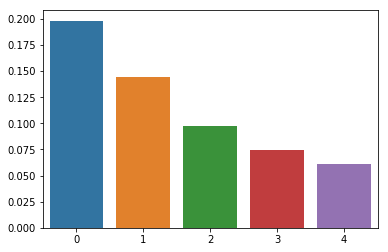

In [29]:
sns.barplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)

This is what it says in the paper

We denote the projection of a vector $ v $ onto $ B $ by

$$ v_B = \sum_{j=1}^{k} (v \cdot b_j) b_j $$

For each word $ w \in N $, let $ \vec{w} $ be re-embedded to
$$ \vec{w} := \vec{w} - \vec{w_{B}} / || \vec{w} - \vec{w_{B}} || $$

$$ \mu := \sum_{w \in E}w / |E| $$
$$ \nu := \mu - \mu_B $$
For each $ w \in E $, 
$$ \vec{w} := \nu + \sqrt{1 - ||\nu||^2}\frac{\vec{w_B} - \mu_B}{||\vec{w_B} - \mu_B||} $$

In [30]:
def remove_subspace(X: np.ndarray, subspace: np.ndarray, norm=True) -> np.ndarray:
    Xb = ((X @ subspace.T) @ subspace) # projection onto biased subspace
    X = (X - Xb) / (np.linalg.norm(X - Xb))
    if norm:
        mu = X.mean(0)
        mub = Xb.mean(0)
        nu = mu - mub
        return nu + np.sqrt(1 - nu**2) * (Xb - mub) / np.linalg.norm(Xb - mub)
    else:
        return X

In [31]:
remove_subspace(male_vecs, pca.components_)

array([[ 0.04787476, -0.02169283, -0.00895407, ..., -0.02797867,
        -0.11690032,  0.02905646],
       [ 0.04798577, -0.02343404, -0.00885439, ..., -0.02715401,
        -0.11659699,  0.03071557],
       [ 0.04853074, -0.02295941, -0.00920404, ..., -0.02754712,
        -0.11671635,  0.03101229],
       ...,
       [ 0.04893007, -0.02380774, -0.00970779, ..., -0.02796964,
        -0.11877845,  0.03163198],
       [ 0.04910786, -0.02278133, -0.01037115, ..., -0.02844729,
        -0.11777215,  0.03153167],
       [ 0.04890184, -0.02371576, -0.00993422, ..., -0.02800529,
        -0.11829908,  0.03171345]], dtype=float32)

### Newly checking for differences

In [32]:
def pp(X: np.ndarray) -> np.ndarray:
    """Postprocess"""
    return remove_subspace(np.expand_dims(X, 0), pca.components_, norm=False)[0]

In [33]:
def compute_new_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(pp(get_word_vector(cword11)) - pp(get_word_vector(cword12)),
                             pp(get_word_vector(cword21)) - pp(get_word_vector(cword22)))

Similarities are being reduced, so there is a shared gender subspace to a certain extent.

In [34]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.13653895, 0.0377738)

In [35]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.20923696, 0.13544616)

In [36]:
(compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.21795174, 0.1698258)

# Checking for change in bias score

Let's see if the bias score decreases with this transformation

In [37]:
def compute_postprocess_bias_score(row):
    sentence, mword, fword, prior_bias = (row["sentence"], row["mword"], 
                                          row["fword"], row["prior_bias"])
    mwi, fwi = processor.token_to_index(mword), processor.token_to_index(fword)
    wv = get_word_vector(
        ContextWord(sentence, "[MASK]"),
        use_last_mask=True,
    )
    wv = pp(wv)
    logits = to_logits(wv)
    subject_fill_bias = logits[fwi] - logits[mwi]
    return subject_fill_bias - prior_bias

Bias is reduced here

In [38]:
tqdm.pandas()
df_train["bias_score_after"] = df_train.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/2484 [00:00<?, ?it/s]

  0%|          | 2/2484 [00:00<05:15,  7.87it/s]

  0%|          | 4/2484 [00:00<04:42,  8.77it/s]

  0%|          | 6/2484 [00:00<04:20,  9.52it/s]

  0%|          | 8/2484 [00:00<04:04, 10.11it/s]

  0%|          | 10/2484 [00:00<03:52, 10.66it/s]

  0%|          | 12/2484 [00:01<03:51, 10.70it/s]

  1%|          | 14/2484 [00:01<03:45, 10.95it/s]

  1%|          | 16/2484 [00:01<03:42, 11.07it/s]

  1%|          | 18/2484 [00:01<03:41, 11.15it/s]

  1%|          | 20/2484 [00:01<03:41, 11.14it/s]

  1%|          | 22/2484 [00:01<03:43, 11.04it/s]

  1%|          | 24/2484 [00:02<04:04, 10.05it/s]

  1%|          | 26/2484 [00:02<04:08,  9.88it/s]

  1%|          | 27/2484 [00:02<04:45,  8.60it/s]

  1%|          | 28/2484 [00:02<04:45,  8.59it/s]

  1%|          | 29/2484 [00:02<04:42,  8.69it/s]

  1%|          | 30/2484 [00:02<04:32,  9.00it/s]

  1%|          | 31/2484 [00:03<05:02,  8.12it/s]

  1%|▏         | 32/2484 [00:03<05:06,  8.00it/s]

  1%|▏         | 33/2484 [00:03<05:03,  8.07it/s]

  1%|▏         | 34/2484 [00:03<05:11,  7.87it/s]

  1%|▏         | 35/2484 [00:03<05:01,  8.12it/s]

  1%|▏         | 36/2484 [00:03<05:03,  8.07it/s]

  1%|▏         | 37/2484 [00:03<05:45,  7.08it/s]

  2%|▏         | 38/2484 [00:04<05:48,  7.01it/s]

  2%|▏         | 39/2484 [00:04<05:33,  7.33it/s]

  2%|▏         | 40/2484 [00:04<05:08,  7.91it/s]

  2%|▏         | 41/2484 [00:04<04:55,  8.28it/s]

  2%|▏         | 43/2484 [00:04<04:42,  8.65it/s]

  2%|▏         | 45/2484 [00:04<04:26,  9.15it/s]

  2%|▏         | 46/2484 [00:04<04:43,  8.60it/s]

  2%|▏         | 47/2484 [00:05<04:35,  8.84it/s]

  2%|▏         | 49/2484 [00:05<04:15,  9.52it/s]

  2%|▏         | 51/2484 [00:05<04:08,  9.79it/s]

  2%|▏         | 52/2484 [00:05<05:31,  7.34it/s]

  2%|▏         | 53/2484 [00:05<06:25,  6.30it/s]

  2%|▏         | 54/2484 [00:05<06:04,  6.67it/s]

  2%|▏         | 55/2484 [00:06<05:33,  7.29it/s]

  2%|▏         | 56/2484 [00:06<05:21,  7.56it/s]

  2%|▏         | 57/2484 [00:06<05:23,  7.51it/s]

  2%|▏         | 58/2484 [00:06<05:04,  7.96it/s]

  2%|▏         | 59/2484 [00:06<04:52,  8.29it/s]

  2%|▏         | 61/2484 [00:06<04:39,  8.66it/s]

  2%|▏         | 62/2484 [00:06<04:39,  8.67it/s]

  3%|▎         | 63/2484 [00:06<04:28,  9.01it/s]

  3%|▎         | 64/2484 [00:07<04:31,  8.90it/s]

  3%|▎         | 65/2484 [00:07<04:32,  8.86it/s]

  3%|▎         | 66/2484 [00:07<04:27,  9.05it/s]

  3%|▎         | 67/2484 [00:07<04:20,  9.29it/s]

  3%|▎         | 68/2484 [00:07<04:21,  9.25it/s]

  3%|▎         | 69/2484 [00:07<04:59,  8.07it/s]

  3%|▎         | 70/2484 [00:07<05:02,  7.99it/s]

  3%|▎         | 71/2484 [00:07<05:14,  7.67it/s]

  3%|▎         | 72/2484 [00:08<05:13,  7.69it/s]

  3%|▎         | 73/2484 [00:08<05:09,  7.79it/s]

  3%|▎         | 74/2484 [00:08<05:11,  7.73it/s]

  3%|▎         | 75/2484 [00:08<05:01,  7.99it/s]

  3%|▎         | 76/2484 [00:08<05:10,  7.77it/s]

  3%|▎         | 77/2484 [00:08<05:21,  7.48it/s]

  3%|▎         | 78/2484 [00:08<05:05,  7.88it/s]

  3%|▎         | 79/2484 [00:08<04:45,  8.42it/s]

  3%|▎         | 80/2484 [00:09<04:39,  8.59it/s]

  3%|▎         | 81/2484 [00:09<04:48,  8.34it/s]

  3%|▎         | 82/2484 [00:09<04:41,  8.53it/s]

  3%|▎         | 83/2484 [00:09<04:47,  8.35it/s]

  3%|▎         | 84/2484 [00:09<04:44,  8.44it/s]

  3%|▎         | 85/2484 [00:09<04:38,  8.61it/s]

  3%|▎         | 86/2484 [00:09<04:30,  8.85it/s]

  4%|▎         | 87/2484 [00:09<04:32,  8.78it/s]

  4%|▎         | 88/2484 [00:09<04:50,  8.24it/s]

  4%|▎         | 89/2484 [00:10<04:37,  8.64it/s]

  4%|▎         | 91/2484 [00:10<04:18,  9.25it/s]

  4%|▎         | 93/2484 [00:10<04:06,  9.71it/s]

  4%|▍         | 95/2484 [00:10<03:55, 10.12it/s]

  4%|▍         | 97/2484 [00:10<03:49, 10.42it/s]

  4%|▍         | 99/2484 [00:10<03:44, 10.64it/s]

  4%|▍         | 101/2484 [00:11<03:42, 10.69it/s]

  4%|▍         | 103/2484 [00:11<03:39, 10.85it/s]

  4%|▍         | 105/2484 [00:11<03:38, 10.91it/s]

  4%|▍         | 107/2484 [00:11<03:35, 11.02it/s]

  4%|▍         | 109/2484 [00:11<03:34, 11.08it/s]

  4%|▍         | 111/2484 [00:12<03:31, 11.22it/s]

  5%|▍         | 113/2484 [00:12<03:28, 11.35it/s]

  5%|▍         | 115/2484 [00:12<03:37, 10.88it/s]

  5%|▍         | 117/2484 [00:12<03:43, 10.57it/s]

  5%|▍         | 119/2484 [00:12<03:41, 10.68it/s]

  5%|▍         | 121/2484 [00:12<03:39, 10.76it/s]

  5%|▍         | 123/2484 [00:13<03:42, 10.59it/s]

  5%|▌         | 125/2484 [00:13<03:49, 10.26it/s]

  5%|▌         | 127/2484 [00:13<03:57,  9.92it/s]

  5%|▌         | 128/2484 [00:13<04:02,  9.71it/s]

  5%|▌         | 129/2484 [00:13<04:14,  9.26it/s]

  5%|▌         | 130/2484 [00:13<04:21,  8.99it/s]

  5%|▌         | 131/2484 [00:14<04:39,  8.41it/s]

  5%|▌         | 132/2484 [00:14<04:39,  8.43it/s]

  5%|▌         | 133/2484 [00:14<04:46,  8.22it/s]

  5%|▌         | 134/2484 [00:14<05:22,  7.28it/s]

  5%|▌         | 135/2484 [00:14<05:24,  7.25it/s]

  5%|▌         | 136/2484 [00:14<05:04,  7.71it/s]

  6%|▌         | 137/2484 [00:14<05:01,  7.79it/s]

  6%|▌         | 138/2484 [00:14<04:48,  8.13it/s]

  6%|▌         | 139/2484 [00:15<04:35,  8.50it/s]

  6%|▌         | 140/2484 [00:15<04:37,  8.44it/s]

  6%|▌         | 141/2484 [00:15<04:46,  8.19it/s]

  6%|▌         | 142/2484 [00:15<05:04,  7.69it/s]

  6%|▌         | 143/2484 [00:15<04:49,  8.09it/s]

  6%|▌         | 144/2484 [00:15<04:49,  8.08it/s]

  6%|▌         | 145/2484 [00:15<04:48,  8.11it/s]

  6%|▌         | 146/2484 [00:15<05:04,  7.69it/s]

  6%|▌         | 147/2484 [00:16<05:27,  7.14it/s]

  6%|▌         | 148/2484 [00:16<05:30,  7.06it/s]

  6%|▌         | 149/2484 [00:16<05:56,  6.55it/s]

  6%|▌         | 150/2484 [00:16<05:35,  6.95it/s]

  6%|▌         | 151/2484 [00:16<05:12,  7.47it/s]

  6%|▌         | 152/2484 [00:16<04:53,  7.94it/s]

  6%|▌         | 153/2484 [00:16<04:38,  8.37it/s]

  6%|▌         | 154/2484 [00:17<05:13,  7.43it/s]

  6%|▌         | 155/2484 [00:17<05:59,  6.48it/s]

  6%|▋         | 156/2484 [00:17<05:59,  6.48it/s]

  6%|▋         | 157/2484 [00:17<06:28,  6.00it/s]

  6%|▋         | 158/2484 [00:17<06:05,  6.37it/s]

  6%|▋         | 159/2484 [00:17<05:47,  6.68it/s]

  6%|▋         | 160/2484 [00:18<05:31,  7.02it/s]

  6%|▋         | 161/2484 [00:18<05:44,  6.74it/s]

  7%|▋         | 162/2484 [00:18<06:12,  6.24it/s]

  7%|▋         | 163/2484 [00:18<06:12,  6.23it/s]

  7%|▋         | 164/2484 [00:18<05:41,  6.79it/s]

  7%|▋         | 165/2484 [00:18<05:26,  7.11it/s]

  7%|▋         | 166/2484 [00:18<05:30,  7.02it/s]

  7%|▋         | 167/2484 [00:19<05:03,  7.63it/s]

  7%|▋         | 169/2484 [00:19<04:42,  8.18it/s]

  7%|▋         | 170/2484 [00:19<04:53,  7.87it/s]

  7%|▋         | 171/2484 [00:19<05:04,  7.59it/s]

  7%|▋         | 172/2484 [00:19<04:53,  7.87it/s]

  7%|▋         | 173/2484 [00:19<04:51,  7.94it/s]

  7%|▋         | 174/2484 [00:19<04:51,  7.91it/s]

  7%|▋         | 175/2484 [00:20<05:31,  6.96it/s]

  7%|▋         | 176/2484 [00:20<05:32,  6.93it/s]

  7%|▋         | 177/2484 [00:20<06:11,  6.21it/s]

  7%|▋         | 178/2484 [00:20<06:05,  6.31it/s]

  7%|▋         | 179/2484 [00:20<05:26,  7.07it/s]

  7%|▋         | 180/2484 [00:20<05:19,  7.21it/s]

  7%|▋         | 181/2484 [00:20<05:03,  7.60it/s]

  7%|▋         | 182/2484 [00:21<04:44,  8.09it/s]

  7%|▋         | 183/2484 [00:21<04:30,  8.52it/s]

  7%|▋         | 184/2484 [00:21<04:35,  8.35it/s]

  7%|▋         | 185/2484 [00:21<04:39,  8.22it/s]

  7%|▋         | 186/2484 [00:21<04:27,  8.58it/s]

  8%|▊         | 187/2484 [00:21<04:21,  8.77it/s]

  8%|▊         | 188/2484 [00:21<04:17,  8.91it/s]

  8%|▊         | 189/2484 [00:21<04:09,  9.21it/s]

  8%|▊         | 191/2484 [00:21<03:58,  9.61it/s]

  8%|▊         | 193/2484 [00:22<03:48, 10.01it/s]

  8%|▊         | 195/2484 [00:22<03:41, 10.33it/s]

  8%|▊         | 197/2484 [00:22<03:40, 10.38it/s]

  8%|▊         | 199/2484 [00:22<03:38, 10.44it/s]

  8%|▊         | 201/2484 [00:22<03:38, 10.43it/s]

  8%|▊         | 203/2484 [00:23<03:35, 10.58it/s]

  8%|▊         | 205/2484 [00:23<03:34, 10.63it/s]

  8%|▊         | 207/2484 [00:23<03:39, 10.37it/s]

  8%|▊         | 209/2484 [00:23<03:36, 10.49it/s]

  8%|▊         | 211/2484 [00:23<03:36, 10.49it/s]

  9%|▊         | 213/2484 [00:24<03:35, 10.55it/s]

  9%|▊         | 215/2484 [00:24<03:36, 10.50it/s]

  9%|▊         | 217/2484 [00:24<03:35, 10.53it/s]

  9%|▉         | 219/2484 [00:24<03:40, 10.26it/s]

  9%|▉         | 221/2484 [00:24<03:38, 10.36it/s]

  9%|▉         | 223/2484 [00:25<03:39, 10.32it/s]

  9%|▉         | 225/2484 [00:25<03:41, 10.19it/s]

  9%|▉         | 227/2484 [00:25<03:42, 10.16it/s]

  9%|▉         | 229/2484 [00:25<03:45,  9.98it/s]

  9%|▉         | 230/2484 [00:25<03:48,  9.87it/s]

  9%|▉         | 232/2484 [00:25<03:44, 10.05it/s]

  9%|▉         | 234/2484 [00:26<03:42, 10.11it/s]

 10%|▉         | 236/2484 [00:26<03:40, 10.20it/s]

 10%|▉         | 238/2484 [00:26<03:38, 10.27it/s]

 10%|▉         | 240/2484 [00:26<03:37, 10.33it/s]

 10%|▉         | 242/2484 [00:26<03:41, 10.14it/s]

 10%|▉         | 244/2484 [00:27<03:38, 10.23it/s]

 10%|▉         | 246/2484 [00:27<03:39, 10.18it/s]

 10%|▉         | 248/2484 [00:27<03:47,  9.84it/s]

 10%|█         | 249/2484 [00:27<03:52,  9.61it/s]

 10%|█         | 251/2484 [00:27<03:49,  9.74it/s]

 10%|█         | 252/2484 [00:27<03:57,  9.41it/s]

 10%|█         | 253/2484 [00:28<04:17,  8.67it/s]

 10%|█         | 254/2484 [00:28<04:24,  8.42it/s]

 10%|█         | 256/2484 [00:28<04:10,  8.88it/s]

 10%|█         | 257/2484 [00:28<04:10,  8.89it/s]

 10%|█         | 259/2484 [00:28<04:08,  8.95it/s]

 10%|█         | 260/2484 [00:28<04:39,  7.95it/s]

 11%|█         | 261/2484 [00:29<05:06,  7.25it/s]

 11%|█         | 262/2484 [00:29<04:45,  7.77it/s]

 11%|█         | 263/2484 [00:29<04:29,  8.24it/s]

 11%|█         | 264/2484 [00:29<04:25,  8.36it/s]

 11%|█         | 265/2484 [00:29<04:14,  8.73it/s]

 11%|█         | 266/2484 [00:29<04:09,  8.89it/s]

 11%|█         | 267/2484 [00:29<04:20,  8.52it/s]

 11%|█         | 268/2484 [00:29<04:13,  8.73it/s]

 11%|█         | 269/2484 [00:29<04:19,  8.53it/s]

 11%|█         | 270/2484 [00:30<04:20,  8.49it/s]

 11%|█         | 271/2484 [00:30<04:25,  8.35it/s]

 11%|█         | 272/2484 [00:30<04:17,  8.58it/s]

 11%|█         | 273/2484 [00:30<04:21,  8.45it/s]

 11%|█         | 274/2484 [00:30<04:29,  8.21it/s]

 11%|█         | 275/2484 [00:30<04:27,  8.26it/s]

 11%|█         | 276/2484 [00:30<04:27,  8.25it/s]

 11%|█         | 277/2484 [00:30<04:27,  8.24it/s]

 11%|█         | 278/2484 [00:31<04:27,  8.24it/s]

 11%|█         | 279/2484 [00:31<04:23,  8.38it/s]

 11%|█▏        | 280/2484 [00:31<04:18,  8.53it/s]

 11%|█▏        | 281/2484 [00:31<04:23,  8.37it/s]

 11%|█▏        | 282/2484 [00:31<04:13,  8.70it/s]

 11%|█▏        | 283/2484 [00:31<04:22,  8.37it/s]

 11%|█▏        | 284/2484 [00:31<04:20,  8.45it/s]

 11%|█▏        | 285/2484 [00:31<04:21,  8.40it/s]

 12%|█▏        | 286/2484 [00:31<04:30,  8.13it/s]

 12%|█▏        | 287/2484 [00:32<04:27,  8.20it/s]

 12%|█▏        | 288/2484 [00:32<04:27,  8.21it/s]

 12%|█▏        | 289/2484 [00:32<04:14,  8.64it/s]

 12%|█▏        | 290/2484 [00:32<04:08,  8.82it/s]

 12%|█▏        | 291/2484 [00:32<04:10,  8.77it/s]

 12%|█▏        | 292/2484 [00:32<04:18,  8.49it/s]

 12%|█▏        | 293/2484 [00:32<04:14,  8.62it/s]

 12%|█▏        | 294/2484 [00:32<04:20,  8.40it/s]

 12%|█▏        | 295/2484 [00:33<04:27,  8.18it/s]

 12%|█▏        | 296/2484 [00:33<04:13,  8.62it/s]

 12%|█▏        | 297/2484 [00:33<04:04,  8.94it/s]

 12%|█▏        | 299/2484 [00:33<03:52,  9.39it/s]

 12%|█▏        | 300/2484 [00:33<03:55,  9.28it/s]

 12%|█▏        | 302/2484 [00:33<03:44,  9.70it/s]

 12%|█▏        | 304/2484 [00:33<03:39,  9.91it/s]

 12%|█▏        | 306/2484 [00:34<03:33, 10.19it/s]

 12%|█▏        | 308/2484 [00:34<03:32, 10.24it/s]

 12%|█▏        | 310/2484 [00:34<03:31, 10.28it/s]

 13%|█▎        | 312/2484 [00:34<03:31, 10.26it/s]

 13%|█▎        | 314/2484 [00:34<03:28, 10.39it/s]

 13%|█▎        | 316/2484 [00:35<03:27, 10.44it/s]

 13%|█▎        | 318/2484 [00:35<03:29, 10.35it/s]

 13%|█▎        | 320/2484 [00:35<03:26, 10.48it/s]

 13%|█▎        | 322/2484 [00:35<03:28, 10.39it/s]

 13%|█▎        | 324/2484 [00:35<03:31, 10.23it/s]

 13%|█▎        | 326/2484 [00:36<03:31, 10.21it/s]

 13%|█▎        | 328/2484 [00:36<03:34, 10.05it/s]

 13%|█▎        | 330/2484 [00:36<03:32, 10.14it/s]

 13%|█▎        | 332/2484 [00:36<03:34, 10.01it/s]

 13%|█▎        | 334/2484 [00:36<03:33, 10.06it/s]

 14%|█▎        | 336/2484 [00:37<03:37,  9.89it/s]

 14%|█▎        | 337/2484 [00:37<03:47,  9.43it/s]

 14%|█▎        | 338/2484 [00:37<03:47,  9.43it/s]

 14%|█▎        | 340/2484 [00:37<03:45,  9.52it/s]

 14%|█▎        | 341/2484 [00:37<03:44,  9.54it/s]

 14%|█▍        | 342/2484 [00:37<04:00,  8.90it/s]

 14%|█▍        | 343/2484 [00:37<03:55,  9.09it/s]

 14%|█▍        | 345/2484 [00:38<03:54,  9.13it/s]

 14%|█▍        | 346/2484 [00:38<04:09,  8.56it/s]

 14%|█▍        | 347/2484 [00:38<04:23,  8.11it/s]

 14%|█▍        | 348/2484 [00:38<04:36,  7.71it/s]

 14%|█▍        | 349/2484 [00:38<04:40,  7.61it/s]

 14%|█▍        | 350/2484 [00:38<04:58,  7.15it/s]

 14%|█▍        | 351/2484 [00:38<05:05,  6.97it/s]

 14%|█▍        | 352/2484 [00:39<04:46,  7.43it/s]

 14%|█▍        | 353/2484 [00:39<04:36,  7.70it/s]

 14%|█▍        | 354/2484 [00:39<05:00,  7.10it/s]

 14%|█▍        | 355/2484 [00:39<04:49,  7.36it/s]

 14%|█▍        | 356/2484 [00:39<04:37,  7.66it/s]

 14%|█▍        | 357/2484 [00:39<04:23,  8.07it/s]

 14%|█▍        | 358/2484 [00:39<04:19,  8.20it/s]

 14%|█▍        | 359/2484 [00:39<04:06,  8.63it/s]

 14%|█▍        | 360/2484 [00:39<03:56,  8.98it/s]

 15%|█▍        | 362/2484 [00:40<03:50,  9.21it/s]

 15%|█▍        | 363/2484 [00:40<04:08,  8.54it/s]

 15%|█▍        | 364/2484 [00:40<04:04,  8.68it/s]

 15%|█▍        | 365/2484 [00:40<04:05,  8.64it/s]

 15%|█▍        | 367/2484 [00:40<03:51,  9.15it/s]

 15%|█▍        | 369/2484 [00:40<03:44,  9.42it/s]

 15%|█▍        | 370/2484 [00:41<03:52,  9.10it/s]

 15%|█▍        | 371/2484 [00:41<03:54,  9.00it/s]

 15%|█▍        | 372/2484 [00:41<03:57,  8.91it/s]

 15%|█▌        | 373/2484 [00:41<03:51,  9.10it/s]

 15%|█▌        | 374/2484 [00:41<03:52,  9.09it/s]

 15%|█▌        | 375/2484 [00:41<03:48,  9.24it/s]

 15%|█▌        | 377/2484 [00:41<03:42,  9.49it/s]

 15%|█▌        | 378/2484 [00:41<03:40,  9.57it/s]

 15%|█▌        | 379/2484 [00:42<03:37,  9.68it/s]

 15%|█▌        | 381/2484 [00:42<03:38,  9.63it/s]

 15%|█▌        | 382/2484 [00:42<03:40,  9.53it/s]

 15%|█▌        | 383/2484 [00:42<03:38,  9.62it/s]

 15%|█▌        | 384/2484 [00:42<03:46,  9.28it/s]

 15%|█▌        | 385/2484 [00:42<03:58,  8.80it/s]

 16%|█▌        | 386/2484 [00:42<03:58,  8.80it/s]

 16%|█▌        | 387/2484 [00:42<04:00,  8.71it/s]

 16%|█▌        | 388/2484 [00:43<03:58,  8.80it/s]

 16%|█▌        | 389/2484 [00:43<03:50,  9.09it/s]

 16%|█▌        | 390/2484 [00:43<04:01,  8.66it/s]

 16%|█▌        | 391/2484 [00:43<04:05,  8.54it/s]

 16%|█▌        | 392/2484 [00:43<04:04,  8.57it/s]

 16%|█▌        | 393/2484 [00:43<03:59,  8.73it/s]

 16%|█▌        | 394/2484 [00:43<04:03,  8.59it/s]

 16%|█▌        | 395/2484 [00:43<04:04,  8.54it/s]

 16%|█▌        | 396/2484 [00:43<04:28,  7.78it/s]

 16%|█▌        | 397/2484 [00:44<04:19,  8.03it/s]

 16%|█▌        | 398/2484 [00:44<04:22,  7.93it/s]

 16%|█▌        | 399/2484 [00:44<04:26,  7.81it/s]

 16%|█▌        | 400/2484 [00:44<04:26,  7.83it/s]

 16%|█▌        | 401/2484 [00:44<04:13,  8.21it/s]

 16%|█▌        | 402/2484 [00:44<04:00,  8.65it/s]

 16%|█▋        | 404/2484 [00:44<03:50,  9.01it/s]

 16%|█▋        | 406/2484 [00:45<03:38,  9.50it/s]

 16%|█▋        | 408/2484 [00:45<03:35,  9.63it/s]

 16%|█▋        | 409/2484 [00:45<03:40,  9.39it/s]

 17%|█▋        | 410/2484 [00:45<03:40,  9.41it/s]

 17%|█▋        | 412/2484 [00:45<03:30,  9.85it/s]

 17%|█▋        | 413/2484 [00:45<03:32,  9.75it/s]

 17%|█▋        | 415/2484 [00:45<03:28,  9.93it/s]

 17%|█▋        | 417/2484 [00:46<03:25, 10.08it/s]

 17%|█▋        | 419/2484 [00:46<03:23, 10.14it/s]

 17%|█▋        | 421/2484 [00:46<03:22, 10.21it/s]

 17%|█▋        | 423/2484 [00:46<03:25, 10.01it/s]

 17%|█▋        | 425/2484 [00:46<03:28,  9.87it/s]

 17%|█▋        | 427/2484 [00:47<03:25,  9.99it/s]

 17%|█▋        | 429/2484 [00:47<03:27,  9.91it/s]

 17%|█▋        | 430/2484 [00:47<03:28,  9.86it/s]

 17%|█▋        | 432/2484 [00:47<03:24, 10.04it/s]

 17%|█▋        | 434/2484 [00:47<03:28,  9.82it/s]

 18%|█▊        | 435/2484 [00:47<03:29,  9.80it/s]

 18%|█▊        | 436/2484 [00:48<03:30,  9.72it/s]

 18%|█▊        | 437/2484 [00:48<03:30,  9.74it/s]

 18%|█▊        | 438/2484 [00:48<03:30,  9.74it/s]

 18%|█▊        | 439/2484 [00:48<03:30,  9.74it/s]

 18%|█▊        | 440/2484 [00:48<03:43,  9.14it/s]

 18%|█▊        | 441/2484 [00:48<03:42,  9.17it/s]

 18%|█▊        | 443/2484 [00:48<03:34,  9.52it/s]

 18%|█▊        | 444/2484 [00:48<03:31,  9.64it/s]

 18%|█▊        | 445/2484 [00:49<03:29,  9.73it/s]

 18%|█▊        | 446/2484 [00:49<03:30,  9.70it/s]

 18%|█▊        | 447/2484 [00:49<03:38,  9.34it/s]

 18%|█▊        | 448/2484 [00:49<03:34,  9.47it/s]

 18%|█▊        | 450/2484 [00:49<03:28,  9.74it/s]

 18%|█▊        | 451/2484 [00:49<03:28,  9.76it/s]

 18%|█▊        | 452/2484 [00:49<03:28,  9.75it/s]

 18%|█▊        | 453/2484 [00:49<03:29,  9.67it/s]

 18%|█▊        | 454/2484 [00:49<03:29,  9.68it/s]

 18%|█▊        | 455/2484 [00:50<03:51,  8.77it/s]

 18%|█▊        | 456/2484 [00:50<04:06,  8.24it/s]

 18%|█▊        | 457/2484 [00:50<04:00,  8.41it/s]

 18%|█▊        | 458/2484 [00:50<04:04,  8.28it/s]

 18%|█▊        | 459/2484 [00:50<03:54,  8.65it/s]

 19%|█▊        | 460/2484 [00:50<03:49,  8.83it/s]

 19%|█▊        | 461/2484 [00:50<03:41,  9.14it/s]

 19%|█▊        | 462/2484 [00:50<03:50,  8.77it/s]

 19%|█▊        | 463/2484 [00:51<03:50,  8.78it/s]

 19%|█▊        | 465/2484 [00:51<03:34,  9.41it/s]

 19%|█▉        | 467/2484 [00:51<03:22,  9.95it/s]

 19%|█▉        | 469/2484 [00:51<03:42,  9.05it/s]

 19%|█▉        | 470/2484 [00:51<04:02,  8.30it/s]

 19%|█▉        | 471/2484 [00:51<03:58,  8.45it/s]

 19%|█▉        | 472/2484 [00:51<03:47,  8.85it/s]

 19%|█▉        | 474/2484 [00:52<03:39,  9.17it/s]

 19%|█▉        | 475/2484 [00:52<03:35,  9.31it/s]

 19%|█▉        | 476/2484 [00:52<03:31,  9.49it/s]

 19%|█▉        | 478/2484 [00:52<03:27,  9.67it/s]

 19%|█▉        | 480/2484 [00:52<03:22,  9.92it/s]

 19%|█▉        | 481/2484 [00:52<03:22,  9.92it/s]

 19%|█▉        | 483/2484 [00:53<03:20,  9.98it/s]

 20%|█▉        | 485/2484 [00:53<03:19, 10.00it/s]

 20%|█▉        | 487/2484 [00:53<03:19,  9.99it/s]

 20%|█▉        | 489/2484 [00:53<03:19,  9.99it/s]

 20%|█▉        | 490/2484 [00:53<03:22,  9.87it/s]

 20%|█▉        | 491/2484 [00:53<03:28,  9.54it/s]

 20%|█▉        | 492/2484 [00:53<03:26,  9.63it/s]

 20%|█▉        | 493/2484 [00:54<03:29,  9.51it/s]

 20%|█▉        | 494/2484 [00:54<03:28,  9.53it/s]

 20%|█▉        | 495/2484 [00:54<03:26,  9.63it/s]

 20%|█▉        | 496/2484 [00:54<03:26,  9.64it/s]

 20%|██        | 497/2484 [00:54<03:35,  9.23it/s]

 20%|██        | 499/2484 [00:54<03:30,  9.43it/s]

 20%|██        | 500/2484 [00:54<03:27,  9.57it/s]

 20%|██        | 501/2484 [00:54<03:30,  9.44it/s]

 20%|██        | 502/2484 [00:55<03:28,  9.52it/s]

 20%|██        | 503/2484 [00:55<03:26,  9.60it/s]

 20%|██        | 504/2484 [00:55<03:26,  9.61it/s]

 20%|██        | 505/2484 [00:55<03:28,  9.48it/s]

 20%|██        | 507/2484 [00:55<03:25,  9.60it/s]

 20%|██        | 509/2484 [00:55<03:18,  9.93it/s]

 21%|██        | 511/2484 [00:55<03:13, 10.17it/s]

 21%|██        | 513/2484 [00:56<03:08, 10.45it/s]

 21%|██        | 515/2484 [00:56<03:02, 10.78it/s]

 21%|██        | 517/2484 [00:56<03:02, 10.78it/s]

 21%|██        | 519/2484 [00:56<03:01, 10.83it/s]

 21%|██        | 521/2484 [00:56<02:58, 10.97it/s]

 21%|██        | 523/2484 [00:57<02:58, 10.99it/s]

 21%|██        | 525/2484 [00:57<02:56, 11.10it/s]

 21%|██        | 527/2484 [00:57<02:54, 11.22it/s]

 21%|██▏       | 529/2484 [00:57<02:54, 11.21it/s]

 21%|██▏       | 531/2484 [00:57<02:52, 11.30it/s]

 21%|██▏       | 533/2484 [00:57<02:55, 11.11it/s]

 22%|██▏       | 535/2484 [00:58<02:54, 11.19it/s]

 22%|██▏       | 537/2484 [00:58<02:55, 11.11it/s]

 22%|██▏       | 539/2484 [00:58<02:55, 11.09it/s]

 22%|██▏       | 541/2484 [00:58<02:58, 10.90it/s]

 22%|██▏       | 543/2484 [00:58<03:00, 10.75it/s]

 22%|██▏       | 545/2484 [00:59<02:58, 10.84it/s]

 22%|██▏       | 547/2484 [00:59<02:57, 10.94it/s]

 22%|██▏       | 549/2484 [00:59<02:56, 10.97it/s]

 22%|██▏       | 551/2484 [00:59<03:03, 10.51it/s]

 22%|██▏       | 553/2484 [00:59<03:02, 10.56it/s]

 22%|██▏       | 555/2484 [00:59<03:10, 10.15it/s]

 22%|██▏       | 557/2484 [01:00<03:09, 10.18it/s]

 23%|██▎       | 559/2484 [01:00<03:08, 10.23it/s]

 23%|██▎       | 561/2484 [01:00<03:08, 10.19it/s]

 23%|██▎       | 563/2484 [01:00<03:05, 10.38it/s]

 23%|██▎       | 565/2484 [01:00<03:02, 10.52it/s]

 23%|██▎       | 567/2484 [01:01<03:02, 10.51it/s]

 23%|██▎       | 569/2484 [01:01<03:01, 10.54it/s]

 23%|██▎       | 571/2484 [01:01<02:59, 10.63it/s]

 23%|██▎       | 573/2484 [01:01<03:01, 10.50it/s]

 23%|██▎       | 575/2484 [01:01<03:08, 10.12it/s]

 23%|██▎       | 577/2484 [01:02<03:00, 10.54it/s]

 23%|██▎       | 579/2484 [01:02<02:56, 10.78it/s]

 23%|██▎       | 581/2484 [01:02<03:14,  9.77it/s]

 23%|██▎       | 582/2484 [01:02<03:44,  8.48it/s]

 24%|██▎       | 584/2484 [01:02<03:31,  8.97it/s]

 24%|██▎       | 585/2484 [01:02<03:25,  9.22it/s]

 24%|██▎       | 587/2484 [01:03<03:20,  9.47it/s]

 24%|██▎       | 589/2484 [01:03<03:14,  9.73it/s]

 24%|██▍       | 590/2484 [01:03<03:14,  9.72it/s]

 24%|██▍       | 591/2484 [01:03<03:14,  9.72it/s]

 24%|██▍       | 592/2484 [01:03<03:13,  9.78it/s]

 24%|██▍       | 594/2484 [01:03<03:14,  9.74it/s]

 24%|██▍       | 595/2484 [01:03<03:16,  9.62it/s]

 24%|██▍       | 596/2484 [01:04<03:18,  9.50it/s]

 24%|██▍       | 597/2484 [01:04<03:16,  9.60it/s]

 24%|██▍       | 599/2484 [01:04<03:14,  9.67it/s]

 24%|██▍       | 600/2484 [01:04<03:15,  9.64it/s]

 24%|██▍       | 601/2484 [01:04<03:17,  9.53it/s]

 24%|██▍       | 602/2484 [01:04<03:18,  9.50it/s]

 24%|██▍       | 604/2484 [01:04<03:17,  9.53it/s]

 24%|██▍       | 605/2484 [01:05<03:23,  9.25it/s]

 24%|██▍       | 607/2484 [01:05<03:20,  9.38it/s]

 25%|██▍       | 609/2484 [01:05<03:15,  9.58it/s]

 25%|██▍       | 610/2484 [01:05<03:13,  9.70it/s]

 25%|██▍       | 611/2484 [01:05<03:15,  9.56it/s]

 25%|██▍       | 613/2484 [01:05<03:13,  9.65it/s]

 25%|██▍       | 614/2484 [01:05<03:12,  9.74it/s]

 25%|██▍       | 615/2484 [01:06<03:17,  9.49it/s]

 25%|██▍       | 616/2484 [01:06<03:17,  9.48it/s]

 25%|██▍       | 617/2484 [01:06<03:15,  9.57it/s]

 25%|██▍       | 618/2484 [01:06<03:17,  9.46it/s]

 25%|██▍       | 619/2484 [01:06<03:18,  9.41it/s]

 25%|██▌       | 621/2484 [01:06<03:11,  9.73it/s]

 25%|██▌       | 623/2484 [01:06<03:03, 10.11it/s]

 25%|██▌       | 625/2484 [01:07<02:59, 10.33it/s]

 25%|██▌       | 627/2484 [01:07<02:57, 10.49it/s]

 25%|██▌       | 629/2484 [01:07<02:53, 10.68it/s]

 25%|██▌       | 631/2484 [01:07<02:52, 10.72it/s]

 25%|██▌       | 633/2484 [01:07<02:49, 10.94it/s]

 26%|██▌       | 635/2484 [01:07<02:46, 11.11it/s]

 26%|██▌       | 637/2484 [01:08<02:43, 11.27it/s]

 26%|██▌       | 639/2484 [01:08<02:43, 11.28it/s]

 26%|██▌       | 641/2484 [01:08<02:43, 11.30it/s]

 26%|██▌       | 643/2484 [01:08<02:43, 11.26it/s]

 26%|██▌       | 645/2484 [01:08<02:42, 11.30it/s]

 26%|██▌       | 647/2484 [01:08<02:42, 11.29it/s]

 26%|██▌       | 649/2484 [01:09<02:42, 11.29it/s]

 26%|██▌       | 651/2484 [01:09<02:44, 11.12it/s]

 26%|██▋       | 653/2484 [01:09<02:46, 10.98it/s]

 26%|██▋       | 655/2484 [01:09<02:47, 10.94it/s]

 26%|██▋       | 657/2484 [01:09<02:58, 10.21it/s]

 27%|██▋       | 659/2484 [01:10<02:56, 10.32it/s]

 27%|██▋       | 661/2484 [01:10<02:54, 10.42it/s]

 27%|██▋       | 663/2484 [01:10<02:53, 10.48it/s]

 27%|██▋       | 665/2484 [01:10<02:52, 10.52it/s]

 27%|██▋       | 667/2484 [01:10<02:51, 10.61it/s]

 27%|██▋       | 669/2484 [01:11<02:50, 10.62it/s]

 27%|██▋       | 671/2484 [01:11<02:49, 10.68it/s]

 27%|██▋       | 673/2484 [01:11<02:49, 10.66it/s]

 27%|██▋       | 675/2484 [01:11<02:52, 10.49it/s]

 27%|██▋       | 677/2484 [01:11<02:52, 10.45it/s]

 27%|██▋       | 679/2484 [01:12<02:53, 10.42it/s]

 27%|██▋       | 681/2484 [01:12<02:50, 10.60it/s]

 27%|██▋       | 683/2484 [01:12<02:49, 10.62it/s]

 28%|██▊       | 685/2484 [01:12<02:53, 10.36it/s]

 28%|██▊       | 687/2484 [01:12<02:54, 10.32it/s]

 28%|██▊       | 689/2484 [01:12<02:46, 10.77it/s]

 28%|██▊       | 691/2484 [01:13<02:42, 11.03it/s]

 28%|██▊       | 693/2484 [01:13<02:52, 10.37it/s]

 28%|██▊       | 695/2484 [01:13<02:57, 10.09it/s]

 28%|██▊       | 697/2484 [01:13<02:55, 10.17it/s]

 28%|██▊       | 699/2484 [01:13<03:02,  9.77it/s]

 28%|██▊       | 700/2484 [01:14<03:06,  9.56it/s]

 28%|██▊       | 701/2484 [01:14<03:07,  9.52it/s]

 28%|██▊       | 702/2484 [01:14<03:07,  9.52it/s]

 28%|██▊       | 703/2484 [01:14<03:08,  9.45it/s]

 28%|██▊       | 704/2484 [01:14<03:06,  9.55it/s]

 28%|██▊       | 705/2484 [01:14<03:11,  9.27it/s]

 28%|██▊       | 706/2484 [01:14<03:08,  9.42it/s]

 28%|██▊       | 707/2484 [01:14<03:06,  9.51it/s]

 29%|██▊       | 708/2484 [01:14<03:09,  9.38it/s]

 29%|██▊       | 709/2484 [01:15<03:07,  9.46it/s]

 29%|██▊       | 710/2484 [01:15<03:05,  9.58it/s]

 29%|██▊       | 711/2484 [01:15<03:07,  9.47it/s]

 29%|██▊       | 712/2484 [01:15<03:06,  9.49it/s]

 29%|██▊       | 714/2484 [01:15<03:02,  9.68it/s]

 29%|██▉       | 716/2484 [01:15<02:58,  9.92it/s]

 29%|██▉       | 717/2484 [01:15<03:01,  9.76it/s]

 29%|██▉       | 718/2484 [01:15<03:01,  9.74it/s]

 29%|██▉       | 719/2484 [01:16<03:03,  9.64it/s]

 29%|██▉       | 720/2484 [01:16<03:00,  9.75it/s]

 29%|██▉       | 721/2484 [01:16<03:00,  9.79it/s]

 29%|██▉       | 723/2484 [01:16<02:58,  9.89it/s]

 29%|██▉       | 725/2484 [01:16<02:56,  9.96it/s]

 29%|██▉       | 727/2484 [01:16<02:54, 10.06it/s]

 29%|██▉       | 729/2484 [01:17<02:54, 10.06it/s]

 29%|██▉       | 731/2484 [01:17<02:53, 10.11it/s]

 30%|██▉       | 733/2484 [01:17<02:49, 10.31it/s]

 30%|██▉       | 735/2484 [01:17<02:48, 10.35it/s]

 30%|██▉       | 737/2484 [01:17<02:44, 10.64it/s]

 30%|██▉       | 739/2484 [01:17<02:40, 10.85it/s]

 30%|██▉       | 741/2484 [01:18<02:39, 10.91it/s]

 30%|██▉       | 743/2484 [01:18<02:38, 10.96it/s]

 30%|██▉       | 745/2484 [01:18<02:37, 11.01it/s]

 30%|███       | 747/2484 [01:18<02:37, 11.03it/s]

 30%|███       | 749/2484 [01:18<02:35, 11.14it/s]

 30%|███       | 751/2484 [01:19<02:34, 11.22it/s]

 30%|███       | 753/2484 [01:19<02:31, 11.39it/s]

 30%|███       | 755/2484 [01:19<02:31, 11.42it/s]

 30%|███       | 757/2484 [01:19<02:30, 11.46it/s]

 31%|███       | 759/2484 [01:19<02:32, 11.29it/s]

 31%|███       | 761/2484 [01:19<02:33, 11.25it/s]

 31%|███       | 763/2484 [01:20<02:34, 11.12it/s]

 31%|███       | 765/2484 [01:20<02:34, 11.13it/s]

 31%|███       | 767/2484 [01:20<02:34, 11.10it/s]

 31%|███       | 769/2484 [01:20<02:33, 11.14it/s]

 31%|███       | 771/2484 [01:20<02:34, 11.06it/s]

 31%|███       | 773/2484 [01:21<02:33, 11.12it/s]

 31%|███       | 775/2484 [01:21<02:36, 10.92it/s]

 31%|███▏      | 777/2484 [01:21<02:36, 10.93it/s]

 31%|███▏      | 779/2484 [01:21<02:37, 10.81it/s]

 31%|███▏      | 781/2484 [01:21<02:38, 10.77it/s]

 32%|███▏      | 783/2484 [01:21<02:36, 10.85it/s]

 32%|███▏      | 785/2484 [01:22<02:39, 10.69it/s]

 32%|███▏      | 787/2484 [01:22<02:37, 10.76it/s]

 32%|███▏      | 789/2484 [01:22<02:36, 10.85it/s]

 32%|███▏      | 791/2484 [01:22<02:36, 10.80it/s]

 32%|███▏      | 793/2484 [01:22<02:36, 10.82it/s]

 32%|███▏      | 795/2484 [01:23<02:36, 10.80it/s]

 32%|███▏      | 797/2484 [01:23<02:35, 10.87it/s]

 32%|███▏      | 799/2484 [01:23<02:40, 10.49it/s]

 32%|███▏      | 801/2484 [01:23<02:36, 10.78it/s]

 32%|███▏      | 803/2484 [01:23<02:31, 11.07it/s]

 32%|███▏      | 805/2484 [01:24<02:47, 10.03it/s]

 32%|███▏      | 807/2484 [01:24<02:56,  9.50it/s]

 33%|███▎      | 809/2484 [01:24<02:52,  9.74it/s]

 33%|███▎      | 810/2484 [01:24<02:57,  9.46it/s]

 33%|███▎      | 811/2484 [01:24<02:54,  9.59it/s]

 33%|███▎      | 813/2484 [01:24<02:54,  9.60it/s]

 33%|███▎      | 815/2484 [01:25<02:52,  9.68it/s]

 33%|███▎      | 816/2484 [01:25<02:51,  9.74it/s]

 33%|███▎      | 818/2484 [01:25<02:48,  9.91it/s]

 33%|███▎      | 819/2484 [01:25<02:47,  9.91it/s]

 33%|███▎      | 820/2484 [01:25<02:47,  9.93it/s]

 33%|███▎      | 822/2484 [01:25<02:45, 10.07it/s]

 33%|███▎      | 824/2484 [01:25<02:43, 10.13it/s]

 33%|███▎      | 826/2484 [01:26<02:44, 10.08it/s]

 33%|███▎      | 828/2484 [01:26<02:45, 10.02it/s]

 33%|███▎      | 830/2484 [01:26<02:45, 10.00it/s]

 33%|███▎      | 832/2484 [01:26<02:45, 10.01it/s]

 34%|███▎      | 834/2484 [01:26<02:44, 10.05it/s]

 34%|███▎      | 836/2484 [01:27<02:43, 10.09it/s]

 34%|███▎      | 838/2484 [01:27<02:43, 10.07it/s]

 34%|███▍      | 840/2484 [01:27<02:45,  9.92it/s]

 34%|███▍      | 842/2484 [01:27<02:46,  9.85it/s]

 34%|███▍      | 843/2484 [01:27<02:47,  9.79it/s]

 34%|███▍      | 845/2484 [01:28<02:44,  9.97it/s]

 34%|███▍      | 847/2484 [01:28<02:39, 10.29it/s]

 34%|███▍      | 849/2484 [01:28<02:35, 10.55it/s]

 34%|███▍      | 851/2484 [01:28<02:31, 10.76it/s]

 34%|███▍      | 853/2484 [01:28<02:30, 10.86it/s]

 34%|███▍      | 855/2484 [01:28<02:29, 10.93it/s]

 35%|███▍      | 857/2484 [01:29<02:27, 11.02it/s]

 35%|███▍      | 859/2484 [01:29<02:25, 11.20it/s]

 35%|███▍      | 861/2484 [01:29<02:23, 11.34it/s]

 35%|███▍      | 863/2484 [01:29<02:22, 11.40it/s]

 35%|███▍      | 865/2484 [01:29<02:21, 11.43it/s]

 35%|███▍      | 867/2484 [01:30<02:22, 11.35it/s]

 35%|███▍      | 869/2484 [01:30<02:22, 11.30it/s]

 35%|███▌      | 871/2484 [01:30<02:21, 11.36it/s]

 35%|███▌      | 873/2484 [01:30<02:22, 11.31it/s]

 35%|███▌      | 875/2484 [01:30<02:22, 11.32it/s]

 35%|███▌      | 877/2484 [01:30<02:22, 11.27it/s]

 35%|███▌      | 879/2484 [01:31<02:22, 11.29it/s]

 35%|███▌      | 881/2484 [01:31<02:22, 11.28it/s]

 36%|███▌      | 883/2484 [01:31<02:21, 11.29it/s]

 36%|███▌      | 885/2484 [01:31<02:22, 11.19it/s]

 36%|███▌      | 887/2484 [01:31<02:24, 11.04it/s]

 36%|███▌      | 889/2484 [01:31<02:26, 10.88it/s]

 36%|███▌      | 891/2484 [01:32<02:28, 10.74it/s]

 36%|███▌      | 893/2484 [01:32<02:28, 10.74it/s]

 36%|███▌      | 895/2484 [01:32<02:28, 10.73it/s]

 36%|███▌      | 897/2484 [01:32<02:27, 10.74it/s]

 36%|███▌      | 899/2484 [01:32<02:28, 10.68it/s]

 36%|███▋      | 901/2484 [01:33<02:28, 10.66it/s]

 36%|███▋      | 903/2484 [01:33<02:28, 10.64it/s]

 36%|███▋      | 905/2484 [01:33<02:29, 10.55it/s]

 37%|███▋      | 907/2484 [01:33<02:29, 10.52it/s]

 37%|███▋      | 909/2484 [01:33<02:31, 10.39it/s]

 37%|███▋      | 911/2484 [01:34<02:38,  9.91it/s]

 37%|███▋      | 913/2484 [01:34<02:34, 10.14it/s]

 37%|███▋      | 915/2484 [01:34<02:30, 10.41it/s]

 37%|███▋      | 917/2484 [01:34<02:30, 10.40it/s]

 37%|███▋      | 919/2484 [01:34<02:41,  9.67it/s]

 37%|███▋      | 920/2484 [01:35<02:49,  9.25it/s]

 37%|███▋      | 922/2484 [01:35<02:43,  9.53it/s]

 37%|███▋      | 923/2484 [01:35<02:43,  9.52it/s]

 37%|███▋      | 924/2484 [01:35<02:42,  9.60it/s]

 37%|███▋      | 925/2484 [01:35<02:40,  9.71it/s]

 37%|███▋      | 926/2484 [01:35<02:39,  9.77it/s]

 37%|███▋      | 928/2484 [01:35<02:35, 10.00it/s]

 37%|███▋      | 930/2484 [01:36<02:35, 10.00it/s]

 38%|███▊      | 932/2484 [01:36<02:42,  9.57it/s]

 38%|███▊      | 933/2484 [01:36<02:47,  9.28it/s]

 38%|███▊      | 935/2484 [01:36<02:44,  9.39it/s]

 38%|███▊      | 936/2484 [01:36<02:42,  9.51it/s]

 38%|███▊      | 938/2484 [01:36<02:41,  9.59it/s]

 38%|███▊      | 940/2484 [01:37<02:39,  9.68it/s]

 38%|███▊      | 941/2484 [01:37<02:40,  9.62it/s]

 38%|███▊      | 943/2484 [01:37<02:39,  9.67it/s]

 38%|███▊      | 944/2484 [01:37<02:43,  9.40it/s]

 38%|███▊      | 945/2484 [01:37<02:41,  9.53it/s]

 38%|███▊      | 947/2484 [01:37<02:38,  9.67it/s]

 38%|███▊      | 948/2484 [01:37<02:40,  9.54it/s]

 38%|███▊      | 949/2484 [01:38<02:42,  9.43it/s]

 38%|███▊      | 950/2484 [01:38<02:43,  9.36it/s]

 38%|███▊      | 951/2484 [01:38<02:40,  9.54it/s]

 38%|███▊      | 952/2484 [01:38<02:51,  8.95it/s]

 38%|███▊      | 953/2484 [01:38<02:50,  8.98it/s]

 38%|███▊      | 954/2484 [01:38<02:57,  8.60it/s]

 38%|███▊      | 955/2484 [01:38<02:53,  8.79it/s]

 38%|███▊      | 956/2484 [01:38<02:50,  8.97it/s]

 39%|███▊      | 958/2484 [01:39<02:42,  9.38it/s]

 39%|███▊      | 960/2484 [01:39<02:35,  9.78it/s]

 39%|███▊      | 962/2484 [01:39<02:31, 10.05it/s]

 39%|███▉      | 964/2484 [01:39<02:27, 10.30it/s]

 39%|███▉      | 966/2484 [01:39<02:24, 10.51it/s]

 39%|███▉      | 968/2484 [01:39<02:22, 10.67it/s]

 39%|███▉      | 970/2484 [01:40<02:19, 10.86it/s]

 39%|███▉      | 972/2484 [01:40<02:16, 11.09it/s]

 39%|███▉      | 974/2484 [01:40<02:14, 11.20it/s]

 39%|███▉      | 976/2484 [01:40<02:13, 11.30it/s]

 39%|███▉      | 978/2484 [01:40<02:12, 11.32it/s]

 39%|███▉      | 980/2484 [01:40<02:13, 11.26it/s]

 40%|███▉      | 982/2484 [01:41<02:12, 11.33it/s]

 40%|███▉      | 984/2484 [01:41<02:13, 11.28it/s]

 40%|███▉      | 986/2484 [01:41<02:13, 11.23it/s]

 40%|███▉      | 988/2484 [01:41<02:14, 11.12it/s]

 40%|███▉      | 990/2484 [01:41<02:13, 11.20it/s]

 40%|███▉      | 992/2484 [01:42<02:13, 11.18it/s]

 40%|████      | 994/2484 [01:42<02:13, 11.19it/s]

 40%|████      | 996/2484 [01:42<02:12, 11.19it/s]

 40%|████      | 998/2484 [01:42<02:14, 11.03it/s]

 40%|████      | 1000/2484 [01:42<02:17, 10.81it/s]

 40%|████      | 1002/2484 [01:42<02:18, 10.67it/s]

 40%|████      | 1004/2484 [01:43<02:18, 10.67it/s]

 40%|████      | 1006/2484 [01:43<02:17, 10.74it/s]

 41%|████      | 1008/2484 [01:43<02:17, 10.71it/s]

 41%|████      | 1010/2484 [01:43<02:17, 10.70it/s]

 41%|████      | 1012/2484 [01:43<02:16, 10.79it/s]

 41%|████      | 1014/2484 [01:44<02:22, 10.31it/s]

 41%|████      | 1016/2484 [01:44<02:22, 10.32it/s]

 41%|████      | 1018/2484 [01:44<02:22, 10.27it/s]

 41%|████      | 1020/2484 [01:44<02:21, 10.34it/s]

 41%|████      | 1022/2484 [01:44<02:22, 10.24it/s]

 41%|████      | 1024/2484 [01:45<02:27,  9.90it/s]

 41%|████▏     | 1026/2484 [01:45<02:20, 10.41it/s]

 41%|████▏     | 1028/2484 [01:45<02:14, 10.83it/s]

 41%|████▏     | 1030/2484 [01:45<02:20, 10.32it/s]

 42%|████▏     | 1032/2484 [01:45<02:28,  9.79it/s]

 42%|████▏     | 1034/2484 [01:46<02:28,  9.79it/s]

 42%|████▏     | 1036/2484 [01:46<02:25,  9.95it/s]

 42%|████▏     | 1038/2484 [01:46<02:25,  9.95it/s]

 42%|████▏     | 1040/2484 [01:46<02:24, 10.01it/s]

 42%|████▏     | 1042/2484 [01:46<02:28,  9.74it/s]

 42%|████▏     | 1043/2484 [01:47<02:28,  9.70it/s]

 42%|████▏     | 1045/2484 [01:47<02:25,  9.90it/s]

 42%|████▏     | 1046/2484 [01:47<02:26,  9.84it/s]

 42%|████▏     | 1048/2484 [01:47<02:24,  9.91it/s]

 42%|████▏     | 1049/2484 [01:47<02:28,  9.66it/s]

 42%|████▏     | 1051/2484 [01:47<02:26,  9.81it/s]

 42%|████▏     | 1052/2484 [01:47<02:29,  9.59it/s]

 42%|████▏     | 1054/2484 [01:48<02:26,  9.75it/s]

 42%|████▏     | 1055/2484 [01:48<02:28,  9.63it/s]

 43%|████▎     | 1057/2484 [01:48<02:26,  9.73it/s]

 43%|████▎     | 1058/2484 [01:48<02:25,  9.77it/s]

 43%|████▎     | 1060/2484 [01:48<02:24,  9.85it/s]

 43%|████▎     | 1061/2484 [01:48<02:24,  9.83it/s]

 43%|████▎     | 1062/2484 [01:48<02:23,  9.88it/s]

 43%|████▎     | 1063/2484 [01:49<02:24,  9.83it/s]

 43%|████▎     | 1065/2484 [01:49<02:22,  9.99it/s]

 43%|████▎     | 1066/2484 [01:49<02:23,  9.85it/s]

 43%|████▎     | 1068/2484 [01:49<02:24,  9.82it/s]

 43%|████▎     | 1069/2484 [01:49<02:24,  9.76it/s]

 43%|████▎     | 1070/2484 [01:49<02:25,  9.72it/s]

 43%|████▎     | 1072/2484 [01:49<02:20, 10.03it/s]

 43%|████▎     | 1074/2484 [01:50<02:16, 10.37it/s]

 43%|████▎     | 1076/2484 [01:50<02:12, 10.64it/s]

 43%|████▎     | 1078/2484 [01:50<02:09, 10.89it/s]

 43%|████▎     | 1080/2484 [01:50<02:08, 10.95it/s]

 44%|████▎     | 1082/2484 [01:50<02:07, 11.03it/s]

 44%|████▎     | 1084/2484 [01:50<02:06, 11.06it/s]

 44%|████▎     | 1086/2484 [01:51<02:04, 11.20it/s]

 44%|████▍     | 1088/2484 [01:51<02:03, 11.30it/s]

 44%|████▍     | 1090/2484 [01:51<02:02, 11.37it/s]

 44%|████▍     | 1092/2484 [01:51<02:01, 11.42it/s]

 44%|████▍     | 1094/2484 [01:51<02:00, 11.51it/s]

 44%|████▍     | 1096/2484 [01:52<02:00, 11.53it/s]

 44%|████▍     | 1098/2484 [01:52<02:00, 11.46it/s]

 44%|████▍     | 1100/2484 [01:52<02:01, 11.40it/s]

 44%|████▍     | 1102/2484 [01:52<02:02, 11.24it/s]

 44%|████▍     | 1104/2484 [01:52<02:03, 11.16it/s]

 45%|████▍     | 1106/2484 [01:52<02:05, 10.97it/s]

 45%|████▍     | 1108/2484 [01:53<02:06, 10.87it/s]

 45%|████▍     | 1110/2484 [01:53<02:08, 10.71it/s]

 45%|████▍     | 1112/2484 [01:53<02:09, 10.58it/s]

 45%|████▍     | 1114/2484 [01:53<02:12, 10.32it/s]

 45%|████▍     | 1116/2484 [01:53<02:11, 10.41it/s]

 45%|████▌     | 1118/2484 [01:54<02:15, 10.05it/s]

 45%|████▌     | 1120/2484 [01:54<02:35,  8.74it/s]

 45%|████▌     | 1121/2484 [01:54<02:51,  7.95it/s]

 45%|████▌     | 1122/2484 [01:54<02:41,  8.41it/s]

 45%|████▌     | 1123/2484 [01:54<02:36,  8.72it/s]

 45%|████▌     | 1124/2484 [01:54<02:34,  8.79it/s]

 45%|████▌     | 1126/2484 [01:55<02:30,  9.05it/s]

 45%|████▌     | 1127/2484 [01:55<02:26,  9.27it/s]

 45%|████▌     | 1129/2484 [01:55<02:23,  9.47it/s]

 45%|████▌     | 1130/2484 [01:55<02:22,  9.52it/s]

 46%|████▌     | 1132/2484 [01:55<02:19,  9.69it/s]

 46%|████▌     | 1134/2484 [01:55<02:16,  9.91it/s]

 46%|████▌     | 1135/2484 [01:56<02:22,  9.45it/s]

 46%|████▌     | 1136/2484 [01:56<02:22,  9.44it/s]

 46%|████▌     | 1138/2484 [01:56<02:15,  9.92it/s]

 46%|████▌     | 1140/2484 [01:56<02:13, 10.06it/s]

 46%|████▌     | 1142/2484 [01:56<02:24,  9.27it/s]

 46%|████▌     | 1143/2484 [01:56<02:32,  8.80it/s]

 46%|████▌     | 1145/2484 [01:57<02:26,  9.15it/s]

 46%|████▌     | 1146/2484 [01:57<02:24,  9.27it/s]

 46%|████▌     | 1148/2484 [01:57<02:21,  9.42it/s]

 46%|████▋     | 1149/2484 [01:57<02:30,  8.86it/s]

 46%|████▋     | 1150/2484 [01:57<02:28,  9.00it/s]

 46%|████▋     | 1152/2484 [01:57<02:23,  9.27it/s]

 46%|████▋     | 1154/2484 [01:58<02:20,  9.47it/s]

 46%|████▋     | 1155/2484 [01:58<02:23,  9.27it/s]

 47%|████▋     | 1157/2484 [01:58<02:20,  9.47it/s]

 47%|████▋     | 1159/2484 [01:58<02:16,  9.68it/s]

 47%|████▋     | 1160/2484 [01:58<02:19,  9.51it/s]

 47%|████▋     | 1161/2484 [01:58<02:24,  9.13it/s]

 47%|████▋     | 1162/2484 [01:58<02:41,  8.21it/s]

 47%|████▋     | 1163/2484 [01:59<02:38,  8.32it/s]

 47%|████▋     | 1164/2484 [01:59<02:34,  8.52it/s]

 47%|████▋     | 1165/2484 [01:59<02:47,  7.86it/s]

 47%|████▋     | 1166/2484 [01:59<02:57,  7.41it/s]

 47%|████▋     | 1167/2484 [01:59<02:59,  7.34it/s]

 47%|████▋     | 1168/2484 [01:59<02:55,  7.50it/s]

 47%|████▋     | 1169/2484 [01:59<02:46,  7.92it/s]

 47%|████▋     | 1170/2484 [01:59<02:37,  8.34it/s]

 47%|████▋     | 1172/2484 [02:00<02:31,  8.65it/s]

 47%|████▋     | 1173/2484 [02:00<02:34,  8.47it/s]

 47%|████▋     | 1174/2484 [02:00<02:35,  8.40it/s]

 47%|████▋     | 1175/2484 [02:00<02:33,  8.55it/s]

 47%|████▋     | 1176/2484 [02:00<02:30,  8.70it/s]

 47%|████▋     | 1177/2484 [02:00<02:30,  8.67it/s]

 47%|████▋     | 1178/2484 [02:00<02:26,  8.93it/s]

 48%|████▊     | 1180/2484 [02:01<02:20,  9.26it/s]

 48%|████▊     | 1182/2484 [02:01<02:13,  9.74it/s]

 48%|████▊     | 1184/2484 [02:01<02:09, 10.02it/s]

 48%|████▊     | 1186/2484 [02:01<02:15,  9.60it/s]

 48%|████▊     | 1187/2484 [02:01<02:19,  9.32it/s]

 48%|████▊     | 1188/2484 [02:01<02:18,  9.39it/s]

 48%|████▊     | 1190/2484 [02:02<02:13,  9.72it/s]

 48%|████▊     | 1192/2484 [02:02<02:09,  9.97it/s]

 48%|████▊     | 1194/2484 [02:02<02:06, 10.16it/s]

 48%|████▊     | 1196/2484 [02:02<02:06, 10.20it/s]

 48%|████▊     | 1198/2484 [02:02<02:03, 10.42it/s]

 48%|████▊     | 1200/2484 [02:02<02:01, 10.61it/s]

 48%|████▊     | 1202/2484 [02:03<01:58, 10.80it/s]

 48%|████▊     | 1204/2484 [02:03<01:56, 10.99it/s]

 49%|████▊     | 1206/2484 [02:03<02:09,  9.89it/s]

 49%|████▊     | 1208/2484 [02:03<02:11,  9.74it/s]

 49%|████▊     | 1209/2484 [02:03<02:10,  9.81it/s]

 49%|████▊     | 1210/2484 [02:03<02:09,  9.81it/s]

 49%|████▉     | 1212/2484 [02:04<02:09,  9.81it/s]

 49%|████▉     | 1213/2484 [02:04<02:08,  9.85it/s]

 49%|████▉     | 1214/2484 [02:04<02:09,  9.83it/s]

 49%|████▉     | 1216/2484 [02:04<02:06, 10.00it/s]

 49%|████▉     | 1218/2484 [02:04<02:05, 10.11it/s]

 49%|████▉     | 1220/2484 [02:04<02:10,  9.68it/s]

 49%|████▉     | 1221/2484 [02:05<02:11,  9.59it/s]

 49%|████▉     | 1222/2484 [02:05<02:18,  9.13it/s]

 49%|████▉     | 1223/2484 [02:05<02:22,  8.86it/s]

 49%|████▉     | 1224/2484 [02:05<02:23,  8.79it/s]

 49%|████▉     | 1225/2484 [02:05<02:20,  8.94it/s]

 49%|████▉     | 1226/2484 [02:05<02:26,  8.60it/s]

 49%|████▉     | 1227/2484 [02:05<02:21,  8.89it/s]

 49%|████▉     | 1228/2484 [02:05<02:18,  9.09it/s]

 50%|████▉     | 1230/2484 [02:06<02:13,  9.42it/s]

 50%|████▉     | 1231/2484 [02:06<02:16,  9.16it/s]

 50%|████▉     | 1232/2484 [02:06<02:16,  9.18it/s]

 50%|████▉     | 1233/2484 [02:06<02:19,  8.99it/s]

 50%|████▉     | 1234/2484 [02:06<02:23,  8.70it/s]

 50%|████▉     | 1235/2484 [02:06<02:21,  8.85it/s]

 50%|████▉     | 1236/2484 [02:06<02:22,  8.76it/s]

 50%|████▉     | 1238/2484 [02:06<02:21,  8.82it/s]

 50%|████▉     | 1239/2484 [02:07<02:33,  8.09it/s]

 50%|████▉     | 1240/2484 [02:07<02:41,  7.68it/s]

 50%|████▉     | 1241/2484 [02:07<02:47,  7.42it/s]

 50%|█████     | 1242/2484 [02:07<02:35,  7.97it/s]

 50%|█████     | 1244/2484 [02:07<02:22,  8.68it/s]

 50%|█████     | 1246/2484 [02:08<02:32,  8.14it/s]

 50%|█████     | 1247/2484 [02:08<03:00,  6.86it/s]

 50%|█████     | 1248/2484 [02:08<03:14,  6.34it/s]

 50%|█████     | 1249/2484 [02:08<02:59,  6.87it/s]

 50%|█████     | 1250/2484 [02:08<02:44,  7.52it/s]

 50%|█████     | 1251/2484 [02:08<02:46,  7.41it/s]

 50%|█████     | 1252/2484 [02:08<02:42,  7.56it/s]

 50%|█████     | 1253/2484 [02:08<02:39,  7.71it/s]

 50%|█████     | 1254/2484 [02:09<02:39,  7.73it/s]

 51%|█████     | 1255/2484 [02:09<02:31,  8.12it/s]

 51%|█████     | 1256/2484 [02:09<02:35,  7.90it/s]

 51%|█████     | 1257/2484 [02:09<02:44,  7.46it/s]

 51%|█████     | 1258/2484 [02:09<02:53,  7.07it/s]

 51%|█████     | 1259/2484 [02:09<02:40,  7.62it/s]

 51%|█████     | 1260/2484 [02:09<02:33,  7.99it/s]

 51%|█████     | 1261/2484 [02:10<02:33,  7.97it/s]

 51%|█████     | 1262/2484 [02:10<02:32,  8.01it/s]

 51%|█████     | 1263/2484 [02:10<02:36,  7.80it/s]

 51%|█████     | 1264/2484 [02:10<02:32,  7.97it/s]

 51%|█████     | 1265/2484 [02:10<02:31,  8.06it/s]

 51%|█████     | 1266/2484 [02:10<02:30,  8.11it/s]

 51%|█████     | 1267/2484 [02:10<02:33,  7.95it/s]

 51%|█████     | 1268/2484 [02:10<02:33,  7.93it/s]

 51%|█████     | 1269/2484 [02:11<02:31,  8.04it/s]

 51%|█████     | 1270/2484 [02:11<02:25,  8.33it/s]

 51%|█████     | 1271/2484 [02:11<02:19,  8.71it/s]

 51%|█████     | 1272/2484 [02:11<02:20,  8.62it/s]

 51%|█████     | 1273/2484 [02:11<02:21,  8.55it/s]

 51%|█████▏    | 1274/2484 [02:11<02:17,  8.79it/s]

 51%|█████▏    | 1275/2484 [02:11<02:22,  8.51it/s]

 51%|█████▏    | 1276/2484 [02:11<02:23,  8.45it/s]

 51%|█████▏    | 1277/2484 [02:11<02:16,  8.83it/s]

 51%|█████▏    | 1278/2484 [02:12<02:13,  9.00it/s]

 51%|█████▏    | 1279/2484 [02:12<02:17,  8.75it/s]

 52%|█████▏    | 1280/2484 [02:12<02:21,  8.52it/s]

 52%|█████▏    | 1281/2484 [02:12<02:22,  8.44it/s]

 52%|█████▏    | 1282/2484 [02:12<02:17,  8.74it/s]

 52%|█████▏    | 1283/2484 [02:12<02:12,  9.04it/s]

 52%|█████▏    | 1285/2484 [02:12<02:09,  9.28it/s]

 52%|█████▏    | 1287/2484 [02:13<02:04,  9.61it/s]

 52%|█████▏    | 1289/2484 [02:13<02:04,  9.62it/s]

 52%|█████▏    | 1290/2484 [02:13<02:07,  9.36it/s]

 52%|█████▏    | 1291/2484 [02:13<02:08,  9.25it/s]

 52%|█████▏    | 1292/2484 [02:13<02:06,  9.41it/s]

 52%|█████▏    | 1293/2484 [02:13<02:07,  9.37it/s]

 52%|█████▏    | 1294/2484 [02:13<02:05,  9.45it/s]

 52%|█████▏    | 1295/2484 [02:13<02:05,  9.47it/s]

 52%|█████▏    | 1296/2484 [02:13<02:04,  9.51it/s]

 52%|█████▏    | 1297/2484 [02:14<02:06,  9.40it/s]

 52%|█████▏    | 1298/2484 [02:14<02:06,  9.36it/s]

 52%|█████▏    | 1299/2484 [02:14<02:05,  9.45it/s]

 52%|█████▏    | 1300/2484 [02:14<02:06,  9.39it/s]

 52%|█████▏    | 1301/2484 [02:14<02:14,  8.82it/s]

 52%|█████▏    | 1302/2484 [02:14<02:09,  9.14it/s]

 52%|█████▏    | 1304/2484 [02:14<02:05,  9.40it/s]

 53%|█████▎    | 1306/2484 [02:15<02:03,  9.50it/s]

 53%|█████▎    | 1308/2484 [02:15<02:00,  9.74it/s]

 53%|█████▎    | 1309/2484 [02:15<02:01,  9.66it/s]

 53%|█████▎    | 1310/2484 [02:15<02:04,  9.46it/s]

 53%|█████▎    | 1311/2484 [02:15<02:03,  9.51it/s]

 53%|█████▎    | 1312/2484 [02:15<02:06,  9.28it/s]

 53%|█████▎    | 1313/2484 [02:15<02:07,  9.22it/s]

 53%|█████▎    | 1315/2484 [02:15<02:03,  9.49it/s]

 53%|█████▎    | 1316/2484 [02:16<02:01,  9.58it/s]

 53%|█████▎    | 1317/2484 [02:16<02:01,  9.58it/s]

 53%|█████▎    | 1318/2484 [02:16<02:02,  9.52it/s]

 53%|█████▎    | 1319/2484 [02:16<02:01,  9.61it/s]

 53%|█████▎    | 1320/2484 [02:16<02:03,  9.39it/s]

 53%|█████▎    | 1321/2484 [02:16<02:03,  9.43it/s]

 53%|█████▎    | 1322/2484 [02:16<02:01,  9.54it/s]

 53%|█████▎    | 1323/2484 [02:16<02:05,  9.23it/s]

 53%|█████▎    | 1324/2484 [02:16<02:03,  9.38it/s]

 53%|█████▎    | 1325/2484 [02:17<02:01,  9.52it/s]

 53%|█████▎    | 1326/2484 [02:17<01:59,  9.65it/s]

 53%|█████▎    | 1327/2484 [02:17<02:14,  8.63it/s]

 53%|█████▎    | 1328/2484 [02:17<02:22,  8.09it/s]

 54%|█████▎    | 1329/2484 [02:17<02:16,  8.48it/s]

 54%|█████▎    | 1330/2484 [02:17<02:13,  8.66it/s]

 54%|█████▎    | 1331/2484 [02:17<02:22,  8.09it/s]

 54%|█████▎    | 1332/2484 [02:17<02:21,  8.14it/s]

 54%|█████▎    | 1334/2484 [02:18<02:14,  8.54it/s]

 54%|█████▎    | 1335/2484 [02:18<02:11,  8.76it/s]

 54%|█████▍    | 1336/2484 [02:18<02:07,  8.99it/s]

 54%|█████▍    | 1337/2484 [02:18<02:15,  8.45it/s]

 54%|█████▍    | 1338/2484 [02:18<02:18,  8.30it/s]

 54%|█████▍    | 1339/2484 [02:18<02:18,  8.28it/s]

 54%|█████▍    | 1340/2484 [02:18<02:15,  8.46it/s]

 54%|█████▍    | 1341/2484 [02:18<02:16,  8.40it/s]

 54%|█████▍    | 1342/2484 [02:19<02:19,  8.19it/s]

 54%|█████▍    | 1344/2484 [02:19<02:08,  8.90it/s]

 54%|█████▍    | 1346/2484 [02:19<02:00,  9.45it/s]

 54%|█████▍    | 1347/2484 [02:19<02:17,  8.27it/s]

 54%|█████▍    | 1348/2484 [02:19<02:14,  8.43it/s]

 54%|█████▍    | 1349/2484 [02:19<02:19,  8.13it/s]

 54%|█████▍    | 1350/2484 [02:19<02:16,  8.28it/s]

 54%|█████▍    | 1351/2484 [02:20<02:10,  8.66it/s]

 54%|█████▍    | 1352/2484 [02:20<02:06,  8.98it/s]

 54%|█████▍    | 1353/2484 [02:20<02:06,  8.97it/s]

 55%|█████▍    | 1354/2484 [02:20<02:09,  8.76it/s]

 55%|█████▍    | 1356/2484 [02:20<02:05,  8.95it/s]

 55%|█████▍    | 1357/2484 [02:20<02:05,  8.96it/s]

 55%|█████▍    | 1358/2484 [02:20<02:06,  8.91it/s]

 55%|█████▍    | 1359/2484 [02:20<02:06,  8.86it/s]

 55%|█████▍    | 1360/2484 [02:21<02:06,  8.89it/s]

 55%|█████▍    | 1361/2484 [02:21<02:08,  8.71it/s]

 55%|█████▍    | 1362/2484 [02:21<02:07,  8.79it/s]

 55%|█████▍    | 1363/2484 [02:21<02:10,  8.60it/s]

 55%|█████▍    | 1364/2484 [02:21<02:08,  8.69it/s]

 55%|█████▍    | 1365/2484 [02:21<02:09,  8.66it/s]

 55%|█████▍    | 1366/2484 [02:21<02:04,  8.95it/s]

 55%|█████▌    | 1367/2484 [02:21<02:05,  8.89it/s]

 55%|█████▌    | 1368/2484 [02:21<02:04,  8.97it/s]

 55%|█████▌    | 1369/2484 [02:22<02:04,  8.92it/s]

 55%|█████▌    | 1370/2484 [02:22<02:02,  9.12it/s]

 55%|█████▌    | 1371/2484 [02:22<02:04,  8.96it/s]

 55%|█████▌    | 1372/2484 [02:22<02:11,  8.44it/s]

 55%|█████▌    | 1373/2484 [02:22<02:13,  8.33it/s]

 55%|█████▌    | 1374/2484 [02:22<02:15,  8.22it/s]

 55%|█████▌    | 1375/2484 [02:22<02:10,  8.52it/s]

 55%|█████▌    | 1377/2484 [02:22<02:04,  8.89it/s]

 55%|█████▌    | 1378/2484 [02:23<02:01,  9.12it/s]

 56%|█████▌    | 1379/2484 [02:23<01:59,  9.26it/s]

 56%|█████▌    | 1380/2484 [02:23<01:57,  9.42it/s]

 56%|█████▌    | 1381/2484 [02:23<01:56,  9.43it/s]

 56%|█████▌    | 1382/2484 [02:23<01:55,  9.57it/s]

 56%|█████▌    | 1383/2484 [02:23<01:55,  9.52it/s]

 56%|█████▌    | 1384/2484 [02:23<02:00,  9.12it/s]

 56%|█████▌    | 1385/2484 [02:23<01:59,  9.23it/s]

 56%|█████▌    | 1387/2484 [02:24<01:58,  9.22it/s]

 56%|█████▌    | 1388/2484 [02:24<02:08,  8.50it/s]

 56%|█████▌    | 1389/2484 [02:24<02:09,  8.44it/s]

 56%|█████▌    | 1390/2484 [02:24<02:05,  8.72it/s]

 56%|█████▌    | 1391/2484 [02:24<02:05,  8.74it/s]

 56%|█████▌    | 1392/2484 [02:24<02:02,  8.93it/s]

 56%|█████▌    | 1394/2484 [02:24<01:57,  9.24it/s]

 56%|█████▌    | 1396/2484 [02:24<01:54,  9.52it/s]

 56%|█████▋    | 1398/2484 [02:25<01:51,  9.77it/s]

 56%|█████▋    | 1400/2484 [02:25<01:49,  9.91it/s]

 56%|█████▋    | 1401/2484 [02:25<01:50,  9.77it/s]

 56%|█████▋    | 1403/2484 [02:25<01:48,  9.99it/s]

 57%|█████▋    | 1405/2484 [02:25<01:46, 10.12it/s]

 57%|█████▋    | 1407/2484 [02:26<01:44, 10.33it/s]

 57%|█████▋    | 1409/2484 [02:26<01:42, 10.51it/s]

 57%|█████▋    | 1411/2484 [02:26<01:43, 10.41it/s]

 57%|█████▋    | 1413/2484 [02:26<01:43, 10.37it/s]

 57%|█████▋    | 1415/2484 [02:26<01:43, 10.36it/s]

 57%|█████▋    | 1417/2484 [02:27<01:42, 10.42it/s]

 57%|█████▋    | 1419/2484 [02:27<01:41, 10.52it/s]

 57%|█████▋    | 1421/2484 [02:27<01:41, 10.52it/s]

 57%|█████▋    | 1423/2484 [02:27<01:40, 10.56it/s]

 57%|█████▋    | 1425/2484 [02:27<01:42, 10.38it/s]

 57%|█████▋    | 1427/2484 [02:27<01:43, 10.24it/s]

 58%|█████▊    | 1429/2484 [02:28<01:45, 10.04it/s]

 58%|█████▊    | 1431/2484 [02:28<01:45,  9.95it/s]

 58%|█████▊    | 1432/2484 [02:28<01:47,  9.74it/s]

 58%|█████▊    | 1433/2484 [02:28<01:47,  9.76it/s]

 58%|█████▊    | 1434/2484 [02:28<01:50,  9.49it/s]

 58%|█████▊    | 1436/2484 [02:28<01:49,  9.55it/s]

 58%|█████▊    | 1437/2484 [02:29<01:49,  9.59it/s]

 58%|█████▊    | 1439/2484 [02:29<01:46,  9.79it/s]

 58%|█████▊    | 1440/2484 [02:29<01:55,  9.03it/s]

 58%|█████▊    | 1441/2484 [02:29<02:14,  7.77it/s]

 58%|█████▊    | 1442/2484 [02:29<02:07,  8.16it/s]

 58%|█████▊    | 1443/2484 [02:29<02:23,  7.24it/s]

 58%|█████▊    | 1444/2484 [02:29<02:27,  7.05it/s]

 58%|█████▊    | 1445/2484 [02:30<02:24,  7.17it/s]

 58%|█████▊    | 1446/2484 [02:30<02:42,  6.39it/s]

 58%|█████▊    | 1447/2484 [02:30<02:29,  6.91it/s]

 58%|█████▊    | 1449/2484 [02:30<02:14,  7.70it/s]

 58%|█████▊    | 1451/2484 [02:30<02:01,  8.47it/s]

 58%|█████▊    | 1452/2484 [02:30<02:09,  7.97it/s]

 58%|█████▊    | 1453/2484 [02:31<02:13,  7.75it/s]

 59%|█████▊    | 1454/2484 [02:31<02:20,  7.35it/s]

 59%|█████▊    | 1455/2484 [02:31<02:13,  7.70it/s]

 59%|█████▊    | 1456/2484 [02:31<02:10,  7.88it/s]

 59%|█████▊    | 1457/2484 [02:31<02:11,  7.83it/s]

 59%|█████▊    | 1458/2484 [02:31<02:13,  7.71it/s]

 59%|█████▊    | 1459/2484 [02:31<02:14,  7.62it/s]

 59%|█████▉    | 1460/2484 [02:32<02:27,  6.96it/s]

 59%|█████▉    | 1461/2484 [02:32<02:39,  6.42it/s]

 59%|█████▉    | 1462/2484 [02:32<03:03,  5.57it/s]

 59%|█████▉    | 1463/2484 [02:32<02:56,  5.77it/s]

 59%|█████▉    | 1464/2484 [02:32<02:42,  6.27it/s]

 59%|█████▉    | 1465/2484 [02:32<02:35,  6.54it/s]

 59%|█████▉    | 1466/2484 [02:32<02:26,  6.94it/s]

 59%|█████▉    | 1467/2484 [02:33<02:29,  6.82it/s]

 59%|█████▉    | 1468/2484 [02:33<02:22,  7.15it/s]

 59%|█████▉    | 1469/2484 [02:33<02:26,  6.93it/s]

 59%|█████▉    | 1470/2484 [02:33<02:30,  6.74it/s]

 59%|█████▉    | 1471/2484 [02:33<02:45,  6.11it/s]

 59%|█████▉    | 1472/2484 [02:33<02:48,  5.99it/s]

 59%|█████▉    | 1473/2484 [02:34<02:32,  6.63it/s]

 59%|█████▉    | 1474/2484 [02:34<02:20,  7.17it/s]

 59%|█████▉    | 1475/2484 [02:34<02:16,  7.39it/s]

 59%|█████▉    | 1476/2484 [02:34<02:15,  7.41it/s]

 59%|█████▉    | 1477/2484 [02:34<02:17,  7.34it/s]

 60%|█████▉    | 1478/2484 [02:34<02:12,  7.62it/s]

 60%|█████▉    | 1479/2484 [02:34<02:08,  7.80it/s]

 60%|█████▉    | 1480/2484 [02:34<02:10,  7.68it/s]

 60%|█████▉    | 1481/2484 [02:35<02:10,  7.66it/s]

 60%|█████▉    | 1482/2484 [02:35<02:06,  7.89it/s]

 60%|█████▉    | 1483/2484 [02:35<02:06,  7.88it/s]

 60%|█████▉    | 1484/2484 [02:35<02:00,  8.30it/s]

 60%|█████▉    | 1485/2484 [02:35<01:57,  8.47it/s]

 60%|█████▉    | 1487/2484 [02:35<01:51,  8.97it/s]

 60%|█████▉    | 1489/2484 [02:35<01:45,  9.39it/s]

 60%|██████    | 1491/2484 [02:36<01:42,  9.70it/s]

 60%|██████    | 1493/2484 [02:36<01:39, 10.00it/s]

 60%|██████    | 1495/2484 [02:36<01:37, 10.19it/s]

 60%|██████    | 1497/2484 [02:36<01:34, 10.42it/s]

 60%|██████    | 1499/2484 [02:36<01:33, 10.52it/s]

 60%|██████    | 1501/2484 [02:37<01:33, 10.54it/s]

 61%|██████    | 1503/2484 [02:37<01:31, 10.73it/s]

 61%|██████    | 1505/2484 [02:37<01:30, 10.78it/s]

 61%|██████    | 1507/2484 [02:37<01:29, 10.91it/s]

 61%|██████    | 1509/2484 [02:37<01:28, 11.03it/s]

 61%|██████    | 1511/2484 [02:37<01:28, 11.05it/s]

 61%|██████    | 1513/2484 [02:38<01:28, 11.02it/s]

 61%|██████    | 1515/2484 [02:38<01:28, 10.92it/s]

 61%|██████    | 1517/2484 [02:38<01:28, 10.89it/s]

 61%|██████    | 1519/2484 [02:38<01:29, 10.81it/s]

 61%|██████    | 1521/2484 [02:38<01:28, 10.84it/s]

 61%|██████▏   | 1523/2484 [02:39<01:28, 10.82it/s]

 61%|██████▏   | 1525/2484 [02:39<01:28, 10.80it/s]

 61%|██████▏   | 1527/2484 [02:39<01:30, 10.54it/s]

 62%|██████▏   | 1529/2484 [02:39<01:34, 10.11it/s]

 62%|██████▏   | 1531/2484 [02:39<01:36,  9.91it/s]

 62%|██████▏   | 1532/2484 [02:39<01:35,  9.93it/s]

 62%|██████▏   | 1533/2484 [02:40<01:37,  9.74it/s]

 62%|██████▏   | 1535/2484 [02:40<01:35,  9.89it/s]

 62%|██████▏   | 1536/2484 [02:40<01:35,  9.92it/s]

 62%|██████▏   | 1537/2484 [02:40<01:38,  9.61it/s]

 62%|██████▏   | 1538/2484 [02:40<01:42,  9.24it/s]

 62%|██████▏   | 1539/2484 [02:40<01:40,  9.39it/s]

 62%|██████▏   | 1540/2484 [02:40<01:39,  9.45it/s]

 62%|██████▏   | 1542/2484 [02:40<01:37,  9.62it/s]

 62%|██████▏   | 1544/2484 [02:41<01:35,  9.86it/s]

 62%|██████▏   | 1546/2484 [02:41<01:34,  9.91it/s]

 62%|██████▏   | 1548/2484 [02:41<01:33, 10.02it/s]

 62%|██████▏   | 1550/2484 [02:41<01:33, 10.01it/s]

 62%|██████▏   | 1552/2484 [02:42<01:36,  9.66it/s]

 63%|██████▎   | 1554/2484 [02:42<01:31, 10.18it/s]

 63%|██████▎   | 1556/2484 [02:42<01:27, 10.58it/s]

 63%|██████▎   | 1558/2484 [02:42<01:33,  9.92it/s]

 63%|██████▎   | 1560/2484 [02:42<01:37,  9.52it/s]

 63%|██████▎   | 1561/2484 [02:42<01:35,  9.62it/s]

 63%|██████▎   | 1563/2484 [02:43<01:34,  9.78it/s]

 63%|██████▎   | 1565/2484 [02:43<01:32,  9.89it/s]

 63%|██████▎   | 1566/2484 [02:43<01:33,  9.81it/s]

 63%|██████▎   | 1568/2484 [02:43<01:32,  9.87it/s]

 63%|██████▎   | 1569/2484 [02:43<01:33,  9.73it/s]

 63%|██████▎   | 1571/2484 [02:43<01:32,  9.87it/s]

 63%|██████▎   | 1572/2484 [02:44<01:34,  9.66it/s]

 63%|██████▎   | 1573/2484 [02:44<01:34,  9.69it/s]

 63%|██████▎   | 1574/2484 [02:44<01:35,  9.48it/s]

 63%|██████▎   | 1575/2484 [02:44<01:39,  9.16it/s]

 63%|██████▎   | 1576/2484 [02:44<01:42,  8.90it/s]

 63%|██████▎   | 1577/2484 [02:44<01:50,  8.20it/s]

 64%|██████▎   | 1578/2484 [02:44<01:49,  8.28it/s]

 64%|██████▎   | 1579/2484 [02:44<01:46,  8.49it/s]

 64%|██████▎   | 1580/2484 [02:44<01:42,  8.81it/s]

 64%|██████▎   | 1581/2484 [02:45<01:40,  8.99it/s]

 64%|██████▎   | 1582/2484 [02:45<01:40,  8.97it/s]

 64%|██████▎   | 1583/2484 [02:45<01:38,  9.13it/s]

 64%|██████▍   | 1584/2484 [02:45<01:38,  9.16it/s]

 64%|██████▍   | 1585/2484 [02:45<01:38,  9.17it/s]

 64%|██████▍   | 1586/2484 [02:45<01:35,  9.38it/s]

 64%|██████▍   | 1587/2484 [02:45<01:34,  9.46it/s]

 64%|██████▍   | 1588/2484 [02:45<01:34,  9.48it/s]

 64%|██████▍   | 1590/2484 [02:46<01:33,  9.55it/s]

 64%|██████▍   | 1592/2484 [02:46<01:31,  9.71it/s]

 64%|██████▍   | 1593/2484 [02:46<01:33,  9.53it/s]

 64%|██████▍   | 1594/2484 [02:46<01:33,  9.54it/s]

 64%|██████▍   | 1595/2484 [02:46<01:34,  9.42it/s]

 64%|██████▍   | 1596/2484 [02:46<01:34,  9.40it/s]

 64%|██████▍   | 1597/2484 [02:46<01:32,  9.55it/s]

 64%|██████▍   | 1599/2484 [02:46<01:30,  9.75it/s]

 64%|██████▍   | 1601/2484 [02:47<01:27, 10.14it/s]

 65%|██████▍   | 1603/2484 [02:47<01:23, 10.51it/s]

 65%|██████▍   | 1605/2484 [02:47<01:22, 10.60it/s]

 65%|██████▍   | 1607/2484 [02:47<01:24, 10.38it/s]

 65%|██████▍   | 1609/2484 [02:47<01:26, 10.11it/s]

 65%|██████▍   | 1611/2484 [02:48<01:27,  9.95it/s]

 65%|██████▍   | 1612/2484 [02:48<01:28,  9.90it/s]

 65%|██████▍   | 1613/2484 [02:48<01:28,  9.83it/s]

 65%|██████▌   | 1615/2484 [02:48<01:27,  9.91it/s]

 65%|██████▌   | 1616/2484 [02:48<01:31,  9.50it/s]

 65%|██████▌   | 1618/2484 [02:48<01:28,  9.75it/s]

 65%|██████▌   | 1620/2484 [02:48<01:26, 10.05it/s]

 65%|██████▌   | 1622/2484 [02:49<01:24, 10.22it/s]

 65%|██████▌   | 1624/2484 [02:49<01:24, 10.17it/s]

 65%|██████▌   | 1626/2484 [02:49<01:25,  9.99it/s]

 66%|██████▌   | 1628/2484 [02:49<01:27,  9.84it/s]

 66%|██████▌   | 1629/2484 [02:49<01:27,  9.81it/s]

 66%|██████▌   | 1630/2484 [02:49<01:26,  9.83it/s]

 66%|██████▌   | 1632/2484 [02:50<01:25,  9.92it/s]

 66%|██████▌   | 1633/2484 [02:50<01:25,  9.94it/s]

 66%|██████▌   | 1635/2484 [02:50<01:24, 10.10it/s]

 66%|██████▌   | 1637/2484 [02:50<01:22, 10.24it/s]

 66%|██████▌   | 1639/2484 [02:50<01:24, 10.03it/s]

 66%|██████▌   | 1641/2484 [02:51<01:23, 10.14it/s]

 66%|██████▌   | 1643/2484 [02:51<01:22, 10.16it/s]

 66%|██████▌   | 1645/2484 [02:51<01:23, 10.04it/s]

 66%|██████▋   | 1647/2484 [02:51<01:23, 10.02it/s]

 66%|██████▋   | 1649/2484 [02:51<01:23,  9.95it/s]

 66%|██████▋   | 1651/2484 [02:52<01:23, 10.01it/s]

 67%|██████▋   | 1653/2484 [02:52<01:22, 10.09it/s]

 67%|██████▋   | 1655/2484 [02:52<01:22, 10.00it/s]

 67%|██████▋   | 1657/2484 [02:52<01:22, 10.02it/s]

 67%|██████▋   | 1659/2484 [02:52<01:21, 10.10it/s]

 67%|██████▋   | 1661/2484 [02:53<01:24,  9.74it/s]

 67%|██████▋   | 1662/2484 [02:53<01:28,  9.34it/s]

 67%|██████▋   | 1664/2484 [02:53<01:25,  9.64it/s]

 67%|██████▋   | 1666/2484 [02:53<01:21, 10.01it/s]

 67%|██████▋   | 1668/2484 [02:53<01:27,  9.31it/s]

 67%|██████▋   | 1669/2484 [02:53<01:32,  8.82it/s]

 67%|██████▋   | 1670/2484 [02:54<01:34,  8.65it/s]

 67%|██████▋   | 1671/2484 [02:54<01:33,  8.65it/s]

 67%|██████▋   | 1672/2484 [02:54<01:31,  8.83it/s]

 67%|██████▋   | 1673/2484 [02:54<01:30,  8.99it/s]

 67%|██████▋   | 1674/2484 [02:54<01:34,  8.55it/s]

 67%|██████▋   | 1675/2484 [02:54<01:36,  8.38it/s]

 67%|██████▋   | 1676/2484 [02:54<01:35,  8.46it/s]

 68%|██████▊   | 1677/2484 [02:54<01:36,  8.33it/s]

 68%|██████▊   | 1678/2484 [02:55<01:37,  8.29it/s]

 68%|██████▊   | 1679/2484 [02:55<01:34,  8.48it/s]

 68%|██████▊   | 1681/2484 [02:55<01:32,  8.70it/s]

 68%|██████▊   | 1682/2484 [02:55<01:32,  8.63it/s]

 68%|██████▊   | 1683/2484 [02:55<01:30,  8.81it/s]

 68%|██████▊   | 1684/2484 [02:55<01:31,  8.77it/s]

 68%|██████▊   | 1685/2484 [02:55<01:32,  8.65it/s]

 68%|██████▊   | 1686/2484 [02:55<01:30,  8.86it/s]

 68%|██████▊   | 1687/2484 [02:56<01:27,  9.09it/s]

 68%|██████▊   | 1688/2484 [02:56<01:26,  9.15it/s]

 68%|██████▊   | 1689/2484 [02:56<01:27,  9.14it/s]

 68%|██████▊   | 1690/2484 [02:56<01:26,  9.20it/s]

 68%|██████▊   | 1691/2484 [02:56<01:28,  8.92it/s]

 68%|██████▊   | 1692/2484 [02:56<01:29,  8.81it/s]

 68%|██████▊   | 1693/2484 [02:56<01:27,  9.06it/s]

 68%|██████▊   | 1694/2484 [02:56<01:27,  9.04it/s]

 68%|██████▊   | 1695/2484 [02:56<01:26,  9.12it/s]

 68%|██████▊   | 1696/2484 [02:57<01:26,  9.16it/s]

 68%|██████▊   | 1697/2484 [02:57<01:23,  9.39it/s]

 68%|██████▊   | 1698/2484 [02:57<01:24,  9.35it/s]

 68%|██████▊   | 1699/2484 [02:57<01:24,  9.26it/s]

 68%|██████▊   | 1700/2484 [02:57<01:25,  9.16it/s]

 68%|██████▊   | 1701/2484 [02:57<01:28,  8.90it/s]

 69%|██████▊   | 1702/2484 [02:57<01:28,  8.84it/s]

 69%|██████▊   | 1703/2484 [02:57<01:26,  9.01it/s]

 69%|██████▊   | 1704/2484 [02:57<01:30,  8.61it/s]

 69%|██████▊   | 1705/2484 [02:58<01:28,  8.83it/s]

 69%|██████▊   | 1706/2484 [02:58<01:25,  9.11it/s]

 69%|██████▉   | 1708/2484 [02:58<01:21,  9.47it/s]

 69%|██████▉   | 1709/2484 [02:58<01:20,  9.59it/s]

 69%|██████▉   | 1711/2484 [02:58<01:18,  9.88it/s]

 69%|██████▉   | 1713/2484 [02:58<01:16, 10.10it/s]

 69%|██████▉   | 1715/2484 [02:58<01:14, 10.27it/s]

 69%|██████▉   | 1717/2484 [02:59<01:12, 10.57it/s]

 69%|██████▉   | 1719/2484 [02:59<01:11, 10.71it/s]

 69%|██████▉   | 1721/2484 [02:59<01:10, 10.76it/s]

 69%|██████▉   | 1723/2484 [02:59<01:11, 10.66it/s]

 69%|██████▉   | 1725/2484 [02:59<01:10, 10.71it/s]

 70%|██████▉   | 1727/2484 [03:00<01:10, 10.79it/s]

 70%|██████▉   | 1729/2484 [03:00<01:09, 10.80it/s]

 70%|██████▉   | 1731/2484 [03:00<01:10, 10.66it/s]

 70%|██████▉   | 1733/2484 [03:00<01:11, 10.56it/s]

 70%|██████▉   | 1735/2484 [03:00<01:12, 10.34it/s]

 70%|██████▉   | 1737/2484 [03:01<01:12, 10.26it/s]

 70%|███████   | 1739/2484 [03:01<01:12, 10.24it/s]

 70%|███████   | 1741/2484 [03:01<01:12, 10.22it/s]

 70%|███████   | 1743/2484 [03:01<01:12, 10.18it/s]

 70%|███████   | 1745/2484 [03:01<01:12, 10.18it/s]

 70%|███████   | 1747/2484 [03:02<01:10, 10.46it/s]

 70%|███████   | 1749/2484 [03:02<01:08, 10.78it/s]

 70%|███████   | 1751/2484 [03:02<01:06, 10.97it/s]

 71%|███████   | 1753/2484 [03:02<01:05, 11.17it/s]

 71%|███████   | 1755/2484 [03:02<01:05, 11.20it/s]

 71%|███████   | 1757/2484 [03:02<01:08, 10.69it/s]

 71%|███████   | 1759/2484 [03:03<01:08, 10.58it/s]

 71%|███████   | 1761/2484 [03:03<01:09, 10.36it/s]

 71%|███████   | 1763/2484 [03:03<01:10, 10.26it/s]

 71%|███████   | 1765/2484 [03:03<01:10, 10.14it/s]

 71%|███████   | 1767/2484 [03:03<01:10, 10.20it/s]

 71%|███████   | 1769/2484 [03:04<01:10, 10.18it/s]

 71%|███████▏  | 1771/2484 [03:04<01:10, 10.15it/s]

 71%|███████▏  | 1773/2484 [03:04<01:11,  9.93it/s]

 71%|███████▏  | 1774/2484 [03:04<01:11,  9.88it/s]

 71%|███████▏  | 1775/2484 [03:04<01:11,  9.87it/s]

 71%|███████▏  | 1776/2484 [03:04<01:12,  9.76it/s]

 72%|███████▏  | 1777/2484 [03:04<01:13,  9.58it/s]

 72%|███████▏  | 1778/2484 [03:05<01:16,  9.21it/s]

 72%|███████▏  | 1779/2484 [03:05<01:24,  8.30it/s]

 72%|███████▏  | 1780/2484 [03:05<01:25,  8.22it/s]

 72%|███████▏  | 1782/2484 [03:05<01:19,  8.87it/s]

 72%|███████▏  | 1784/2484 [03:05<01:13,  9.51it/s]

 72%|███████▏  | 1785/2484 [03:05<01:22,  8.46it/s]

 72%|███████▏  | 1786/2484 [03:05<01:28,  7.93it/s]

 72%|███████▏  | 1787/2484 [03:06<01:30,  7.67it/s]

 72%|███████▏  | 1789/2484 [03:06<01:24,  8.24it/s]

 72%|███████▏  | 1790/2484 [03:06<01:22,  8.39it/s]

 72%|███████▏  | 1791/2484 [03:06<01:23,  8.31it/s]

 72%|███████▏  | 1792/2484 [03:06<01:20,  8.64it/s]

 72%|███████▏  | 1793/2484 [03:06<01:18,  8.79it/s]

 72%|███████▏  | 1794/2484 [03:06<01:17,  8.93it/s]

 72%|███████▏  | 1795/2484 [03:06<01:17,  8.92it/s]

 72%|███████▏  | 1796/2484 [03:07<01:19,  8.69it/s]

 72%|███████▏  | 1797/2484 [03:07<01:20,  8.50it/s]

 72%|███████▏  | 1798/2484 [03:07<01:22,  8.27it/s]

 72%|███████▏  | 1799/2484 [03:07<01:20,  8.56it/s]

 72%|███████▏  | 1800/2484 [03:07<01:20,  8.49it/s]

 73%|███████▎  | 1801/2484 [03:07<01:18,  8.70it/s]

 73%|███████▎  | 1802/2484 [03:07<01:19,  8.59it/s]

 73%|███████▎  | 1803/2484 [03:07<01:18,  8.69it/s]

 73%|███████▎  | 1804/2484 [03:08<01:19,  8.54it/s]

 73%|███████▎  | 1805/2484 [03:08<01:19,  8.55it/s]

 73%|███████▎  | 1806/2484 [03:08<01:17,  8.70it/s]

 73%|███████▎  | 1807/2484 [03:08<01:19,  8.49it/s]

 73%|███████▎  | 1808/2484 [03:08<01:26,  7.79it/s]

 73%|███████▎  | 1809/2484 [03:08<01:21,  8.30it/s]

 73%|███████▎  | 1810/2484 [03:08<01:18,  8.58it/s]

 73%|███████▎  | 1811/2484 [03:08<01:18,  8.62it/s]

 73%|███████▎  | 1812/2484 [03:08<01:17,  8.67it/s]

 73%|███████▎  | 1814/2484 [03:09<01:15,  8.90it/s]

 73%|███████▎  | 1815/2484 [03:09<01:15,  8.80it/s]

 73%|███████▎  | 1816/2484 [03:09<01:18,  8.52it/s]

 73%|███████▎  | 1817/2484 [03:09<01:19,  8.42it/s]

 73%|███████▎  | 1818/2484 [03:09<01:19,  8.41it/s]

 73%|███████▎  | 1819/2484 [03:09<01:22,  8.05it/s]

 73%|███████▎  | 1820/2484 [03:09<01:19,  8.35it/s]

 73%|███████▎  | 1821/2484 [03:10<01:22,  8.07it/s]

 73%|███████▎  | 1822/2484 [03:10<01:18,  8.43it/s]

 73%|███████▎  | 1824/2484 [03:10<01:14,  8.92it/s]

 74%|███████▎  | 1826/2484 [03:10<01:12,  9.13it/s]

 74%|███████▎  | 1828/2484 [03:10<01:08,  9.63it/s]

 74%|███████▎  | 1830/2484 [03:10<01:05,  9.96it/s]

 74%|███████▍  | 1832/2484 [03:11<01:04, 10.17it/s]

 74%|███████▍  | 1834/2484 [03:11<01:03, 10.19it/s]

 74%|███████▍  | 1836/2484 [03:11<01:02, 10.29it/s]

 74%|███████▍  | 1838/2484 [03:11<01:02, 10.31it/s]

 74%|███████▍  | 1840/2484 [03:11<01:02, 10.36it/s]

 74%|███████▍  | 1842/2484 [03:12<01:02, 10.30it/s]

 74%|███████▍  | 1844/2484 [03:12<01:01, 10.34it/s]

 74%|███████▍  | 1846/2484 [03:12<01:01, 10.33it/s]

 74%|███████▍  | 1848/2484 [03:12<01:02, 10.18it/s]

 74%|███████▍  | 1850/2484 [03:12<01:01, 10.25it/s]

 75%|███████▍  | 1852/2484 [03:13<01:01, 10.28it/s]

 75%|███████▍  | 1854/2484 [03:13<01:01, 10.31it/s]

 75%|███████▍  | 1856/2484 [03:13<01:00, 10.30it/s]

 75%|███████▍  | 1858/2484 [03:13<01:01, 10.21it/s]

 75%|███████▍  | 1860/2484 [03:13<01:01, 10.18it/s]

 75%|███████▍  | 1862/2484 [03:14<01:04,  9.61it/s]

 75%|███████▌  | 1863/2484 [03:14<01:08,  9.04it/s]

 75%|███████▌  | 1864/2484 [03:14<01:09,  8.98it/s]

 75%|███████▌  | 1865/2484 [03:14<01:12,  8.53it/s]

 75%|███████▌  | 1866/2484 [03:14<01:13,  8.41it/s]

 75%|███████▌  | 1867/2484 [03:14<01:10,  8.80it/s]

 75%|███████▌  | 1868/2484 [03:14<01:08,  9.03it/s]

 75%|███████▌  | 1869/2484 [03:14<01:07,  9.05it/s]

 75%|███████▌  | 1870/2484 [03:15<01:07,  9.04it/s]

 75%|███████▌  | 1871/2484 [03:15<01:06,  9.18it/s]

 75%|███████▌  | 1872/2484 [03:15<01:05,  9.35it/s]

 75%|███████▌  | 1873/2484 [03:15<01:05,  9.33it/s]

 75%|███████▌  | 1875/2484 [03:15<01:05,  9.32it/s]

 76%|███████▌  | 1876/2484 [03:15<01:04,  9.42it/s]

 76%|███████▌  | 1877/2484 [03:15<01:06,  9.16it/s]

 76%|███████▌  | 1878/2484 [03:15<01:05,  9.18it/s]

 76%|███████▌  | 1879/2484 [03:15<01:05,  9.30it/s]

 76%|███████▌  | 1880/2484 [03:16<01:06,  9.11it/s]

 76%|███████▌  | 1882/2484 [03:16<01:04,  9.38it/s]

 76%|███████▌  | 1883/2484 [03:16<01:07,  8.91it/s]

 76%|███████▌  | 1884/2484 [03:16<01:09,  8.66it/s]

 76%|███████▌  | 1886/2484 [03:16<01:04,  9.25it/s]

 76%|███████▌  | 1888/2484 [03:16<01:00,  9.83it/s]

 76%|███████▌  | 1890/2484 [03:17<01:04,  9.17it/s]

 76%|███████▌  | 1891/2484 [03:17<01:11,  8.29it/s]

 76%|███████▌  | 1892/2484 [03:17<01:11,  8.32it/s]

 76%|███████▌  | 1893/2484 [03:17<01:12,  8.14it/s]

 76%|███████▌  | 1894/2484 [03:17<01:13,  8.00it/s]

 76%|███████▋  | 1895/2484 [03:17<01:11,  8.23it/s]

 76%|███████▋  | 1896/2484 [03:17<01:09,  8.42it/s]

 76%|███████▋  | 1897/2484 [03:18<01:08,  8.62it/s]

 76%|███████▋  | 1898/2484 [03:18<01:06,  8.87it/s]

 76%|███████▋  | 1899/2484 [03:18<01:04,  9.04it/s]

 76%|███████▋  | 1900/2484 [03:18<01:05,  8.98it/s]

 77%|███████▋  | 1901/2484 [03:18<01:04,  9.06it/s]

 77%|███████▋  | 1902/2484 [03:18<01:03,  9.18it/s]

 77%|███████▋  | 1903/2484 [03:18<01:04,  8.99it/s]

 77%|███████▋  | 1904/2484 [03:18<01:07,  8.62it/s]

 77%|███████▋  | 1905/2484 [03:18<01:08,  8.44it/s]

 77%|███████▋  | 1906/2484 [03:19<01:10,  8.19it/s]

 77%|███████▋  | 1907/2484 [03:19<01:10,  8.18it/s]

 77%|███████▋  | 1908/2484 [03:19<01:10,  8.11it/s]

 77%|███████▋  | 1909/2484 [03:19<01:08,  8.35it/s]

 77%|███████▋  | 1910/2484 [03:19<01:05,  8.73it/s]

 77%|███████▋  | 1911/2484 [03:19<01:06,  8.68it/s]

 77%|███████▋  | 1912/2484 [03:19<01:06,  8.58it/s]

 77%|███████▋  | 1913/2484 [03:19<01:05,  8.77it/s]

 77%|███████▋  | 1914/2484 [03:19<01:04,  8.80it/s]

 77%|███████▋  | 1915/2484 [03:20<01:05,  8.72it/s]

 77%|███████▋  | 1916/2484 [03:20<01:04,  8.79it/s]

 77%|███████▋  | 1917/2484 [03:20<01:03,  8.95it/s]

 77%|███████▋  | 1918/2484 [03:20<01:04,  8.73it/s]

 77%|███████▋  | 1919/2484 [03:20<01:04,  8.70it/s]

 77%|███████▋  | 1920/2484 [03:20<01:05,  8.66it/s]

 77%|███████▋  | 1921/2484 [03:20<01:03,  8.83it/s]

 77%|███████▋  | 1922/2484 [03:20<01:05,  8.64it/s]

 77%|███████▋  | 1923/2484 [03:20<01:05,  8.59it/s]

 77%|███████▋  | 1924/2484 [03:21<01:03,  8.87it/s]

 77%|███████▋  | 1925/2484 [03:21<01:03,  8.80it/s]

 78%|███████▊  | 1926/2484 [03:21<01:03,  8.85it/s]

 78%|███████▊  | 1928/2484 [03:21<01:00,  9.24it/s]

 78%|███████▊  | 1930/2484 [03:21<00:58,  9.44it/s]

 78%|███████▊  | 1932/2484 [03:21<00:56,  9.81it/s]

 78%|███████▊  | 1933/2484 [03:22<00:56,  9.72it/s]

 78%|███████▊  | 1935/2484 [03:22<00:55,  9.90it/s]

 78%|███████▊  | 1937/2484 [03:22<00:54, 10.02it/s]

 78%|███████▊  | 1939/2484 [03:22<00:54,  9.93it/s]

 78%|███████▊  | 1941/2484 [03:22<00:54, 10.05it/s]

 78%|███████▊  | 1943/2484 [03:22<00:53, 10.19it/s]

 78%|███████▊  | 1945/2484 [03:23<00:52, 10.29it/s]

 78%|███████▊  | 1947/2484 [03:23<00:52, 10.28it/s]

 78%|███████▊  | 1949/2484 [03:23<00:51, 10.32it/s]

 79%|███████▊  | 1951/2484 [03:23<00:51, 10.39it/s]

 79%|███████▊  | 1953/2484 [03:23<00:51, 10.33it/s]

 79%|███████▊  | 1955/2484 [03:24<00:51, 10.33it/s]

 79%|███████▉  | 1957/2484 [03:24<00:50, 10.35it/s]

 79%|███████▉  | 1959/2484 [03:24<00:51, 10.17it/s]

 79%|███████▉  | 1961/2484 [03:24<00:51, 10.14it/s]

 79%|███████▉  | 1963/2484 [03:24<00:51, 10.03it/s]

 79%|███████▉  | 1965/2484 [03:25<00:51, 10.02it/s]

 79%|███████▉  | 1967/2484 [03:25<00:54,  9.49it/s]

 79%|███████▉  | 1968/2484 [03:25<01:01,  8.44it/s]

 79%|███████▉  | 1969/2484 [03:25<01:03,  8.14it/s]

 79%|███████▉  | 1970/2484 [03:25<01:00,  8.48it/s]

 79%|███████▉  | 1971/2484 [03:25<00:59,  8.66it/s]

 79%|███████▉  | 1972/2484 [03:25<00:57,  8.91it/s]

 79%|███████▉  | 1973/2484 [03:26<00:57,  8.93it/s]

 80%|███████▉  | 1975/2484 [03:26<00:55,  9.13it/s]

 80%|███████▉  | 1976/2484 [03:26<00:55,  9.19it/s]

 80%|███████▉  | 1977/2484 [03:26<00:53,  9.41it/s]

 80%|███████▉  | 1979/2484 [03:26<00:52,  9.58it/s]

 80%|███████▉  | 1980/2484 [03:26<00:54,  9.30it/s]

 80%|███████▉  | 1982/2484 [03:27<00:53,  9.41it/s]

 80%|███████▉  | 1983/2484 [03:27<00:52,  9.57it/s]

 80%|███████▉  | 1984/2484 [03:27<00:52,  9.56it/s]

 80%|███████▉  | 1986/2484 [03:27<00:55,  9.05it/s]

 80%|███████▉  | 1987/2484 [03:27<00:55,  8.94it/s]

 80%|████████  | 1988/2484 [03:27<01:02,  8.00it/s]

 80%|████████  | 1989/2484 [03:27<01:04,  7.64it/s]

 80%|████████  | 1990/2484 [03:28<01:00,  8.10it/s]

 80%|████████  | 1992/2484 [03:28<00:55,  8.81it/s]

 80%|████████  | 1993/2484 [03:28<00:58,  8.46it/s]

 80%|████████  | 1994/2484 [03:28<01:01,  8.02it/s]

 80%|████████  | 1995/2484 [03:28<01:04,  7.55it/s]

 80%|████████  | 1996/2484 [03:28<01:02,  7.84it/s]

 80%|████████  | 1997/2484 [03:28<00:58,  8.30it/s]

 80%|████████  | 1999/2484 [03:29<00:55,  8.82it/s]

 81%|████████  | 2000/2484 [03:29<00:52,  9.14it/s]

 81%|████████  | 2002/2484 [03:29<00:51,  9.39it/s]

 81%|████████  | 2003/2484 [03:29<00:50,  9.45it/s]

 81%|████████  | 2005/2484 [03:29<00:49,  9.60it/s]

 81%|████████  | 2006/2484 [03:29<00:50,  9.49it/s]

 81%|████████  | 2007/2484 [03:29<00:51,  9.25it/s]

 81%|████████  | 2008/2484 [03:29<00:55,  8.65it/s]

 81%|████████  | 2009/2484 [03:30<00:53,  8.85it/s]

 81%|████████  | 2010/2484 [03:30<00:53,  8.91it/s]

 81%|████████  | 2011/2484 [03:30<00:52,  8.93it/s]

 81%|████████  | 2012/2484 [03:30<00:52,  9.02it/s]

 81%|████████  | 2013/2484 [03:30<00:52,  8.97it/s]

 81%|████████  | 2014/2484 [03:30<00:52,  9.01it/s]

 81%|████████  | 2015/2484 [03:30<00:59,  7.84it/s]

 81%|████████  | 2016/2484 [03:30<01:00,  7.76it/s]

 81%|████████  | 2017/2484 [03:31<00:57,  8.08it/s]

 81%|████████  | 2018/2484 [03:31<00:55,  8.35it/s]

 81%|████████▏ | 2019/2484 [03:31<00:54,  8.47it/s]

 81%|████████▏ | 2020/2484 [03:31<00:53,  8.61it/s]

 81%|████████▏ | 2022/2484 [03:31<00:51,  9.00it/s]

 81%|████████▏ | 2023/2484 [03:31<00:50,  9.19it/s]

 81%|████████▏ | 2024/2484 [03:31<00:48,  9.39it/s]

 82%|████████▏ | 2025/2484 [03:31<00:48,  9.42it/s]

 82%|████████▏ | 2026/2484 [03:32<00:48,  9.35it/s]

 82%|████████▏ | 2027/2484 [03:32<00:48,  9.50it/s]

 82%|████████▏ | 2029/2484 [03:32<00:47,  9.59it/s]

 82%|████████▏ | 2030/2484 [03:32<00:47,  9.59it/s]

 82%|████████▏ | 2031/2484 [03:32<00:48,  9.41it/s]

 82%|████████▏ | 2033/2484 [03:32<00:46,  9.73it/s]

 82%|████████▏ | 2035/2484 [03:32<00:44, 10.08it/s]

 82%|████████▏ | 2037/2484 [03:33<00:43, 10.39it/s]

 82%|████████▏ | 2039/2484 [03:33<00:41, 10.68it/s]

 82%|████████▏ | 2041/2484 [03:33<00:41, 10.65it/s]

 82%|████████▏ | 2043/2484 [03:33<00:41, 10.67it/s]

 82%|████████▏ | 2045/2484 [03:33<00:40, 10.83it/s]

 82%|████████▏ | 2047/2484 [03:33<00:40, 10.89it/s]

 82%|████████▏ | 2049/2484 [03:34<00:39, 11.06it/s]

 83%|████████▎ | 2051/2484 [03:34<00:39, 11.08it/s]

 83%|████████▎ | 2053/2484 [03:34<00:38, 11.09it/s]

 83%|████████▎ | 2055/2484 [03:34<00:39, 10.96it/s]

 83%|████████▎ | 2057/2484 [03:34<00:38, 11.06it/s]

 83%|████████▎ | 2059/2484 [03:35<00:38, 10.96it/s]

 83%|████████▎ | 2061/2484 [03:35<00:38, 11.03it/s]

 83%|████████▎ | 2063/2484 [03:35<00:38, 10.93it/s]

 83%|████████▎ | 2065/2484 [03:35<00:38, 10.85it/s]

 83%|████████▎ | 2067/2484 [03:35<00:38, 10.83it/s]

 83%|████████▎ | 2069/2484 [03:35<00:38, 10.80it/s]

 83%|████████▎ | 2071/2484 [03:36<00:38, 10.71it/s]

 83%|████████▎ | 2073/2484 [03:36<00:39, 10.52it/s]

 84%|████████▎ | 2075/2484 [03:36<00:39, 10.46it/s]

 84%|████████▎ | 2077/2484 [03:36<00:38, 10.50it/s]

 84%|████████▎ | 2079/2484 [03:36<00:38, 10.48it/s]

 84%|████████▍ | 2081/2484 [03:37<00:38, 10.59it/s]

 84%|████████▍ | 2083/2484 [03:37<00:38, 10.55it/s]

 84%|████████▍ | 2085/2484 [03:37<00:38, 10.40it/s]

 84%|████████▍ | 2087/2484 [03:37<00:37, 10.47it/s]

 84%|████████▍ | 2089/2484 [03:37<00:37, 10.41it/s]

 84%|████████▍ | 2091/2484 [03:38<00:37, 10.50it/s]

 84%|████████▍ | 2093/2484 [03:38<00:37, 10.35it/s]

 84%|████████▍ | 2095/2484 [03:38<00:37, 10.33it/s]

 84%|████████▍ | 2097/2484 [03:38<00:39,  9.68it/s]

 85%|████████▍ | 2099/2484 [03:38<00:38, 10.06it/s]

 85%|████████▍ | 2101/2484 [03:39<00:36, 10.48it/s]

 85%|████████▍ | 2103/2484 [03:39<00:36, 10.40it/s]

 85%|████████▍ | 2105/2484 [03:39<00:40,  9.28it/s]

 85%|████████▍ | 2106/2484 [03:39<00:40,  9.39it/s]

 85%|████████▍ | 2107/2484 [03:39<00:39,  9.54it/s]

 85%|████████▍ | 2108/2484 [03:39<00:39,  9.63it/s]

 85%|████████▍ | 2110/2484 [03:40<00:38,  9.69it/s]

 85%|████████▍ | 2111/2484 [03:40<00:38,  9.74it/s]

 85%|████████▌ | 2112/2484 [03:40<00:38,  9.62it/s]

 85%|████████▌ | 2113/2484 [03:40<00:38,  9.58it/s]

 85%|████████▌ | 2114/2484 [03:40<00:38,  9.51it/s]

 85%|████████▌ | 2115/2484 [03:40<00:38,  9.50it/s]

 85%|████████▌ | 2116/2484 [03:40<00:39,  9.32it/s]

 85%|████████▌ | 2117/2484 [03:40<00:39,  9.24it/s]

 85%|████████▌ | 2118/2484 [03:40<00:39,  9.26it/s]

 85%|████████▌ | 2119/2484 [03:41<00:39,  9.34it/s]

 85%|████████▌ | 2121/2484 [03:41<00:37,  9.60it/s]

 85%|████████▌ | 2122/2484 [03:41<00:37,  9.54it/s]

 85%|████████▌ | 2123/2484 [03:41<00:38,  9.47it/s]

 86%|████████▌ | 2124/2484 [03:41<00:37,  9.52it/s]

 86%|████████▌ | 2125/2484 [03:41<00:37,  9.48it/s]

 86%|████████▌ | 2126/2484 [03:41<00:37,  9.46it/s]

 86%|████████▌ | 2127/2484 [03:41<00:37,  9.60it/s]

 86%|████████▌ | 2128/2484 [03:41<00:37,  9.57it/s]

 86%|████████▌ | 2129/2484 [03:42<00:37,  9.52it/s]

 86%|████████▌ | 2130/2484 [03:42<00:37,  9.53it/s]

 86%|████████▌ | 2131/2484 [03:42<00:36,  9.57it/s]

 86%|████████▌ | 2132/2484 [03:42<00:36,  9.54it/s]

 86%|████████▌ | 2133/2484 [03:42<00:36,  9.64it/s]

 86%|████████▌ | 2134/2484 [03:42<00:37,  9.45it/s]

 86%|████████▌ | 2135/2484 [03:42<00:37,  9.33it/s]

 86%|████████▌ | 2136/2484 [03:42<00:36,  9.49it/s]

 86%|████████▌ | 2137/2484 [03:42<00:36,  9.56it/s]

 86%|████████▌ | 2138/2484 [03:43<00:36,  9.51it/s]

 86%|████████▌ | 2140/2484 [03:43<00:35,  9.65it/s]

 86%|████████▌ | 2141/2484 [03:43<00:35,  9.53it/s]

 86%|████████▌ | 2142/2484 [03:43<00:35,  9.60it/s]

 86%|████████▋ | 2144/2484 [03:43<00:34,  9.94it/s]

 86%|████████▋ | 2146/2484 [03:43<00:33, 10.22it/s]

 86%|████████▋ | 2148/2484 [03:43<00:32, 10.49it/s]

 87%|████████▋ | 2150/2484 [03:44<00:31, 10.64it/s]

 87%|████████▋ | 2152/2484 [03:44<00:31, 10.71it/s]

 87%|████████▋ | 2154/2484 [03:44<00:31, 10.52it/s]

 87%|████████▋ | 2156/2484 [03:44<00:31, 10.41it/s]

 87%|████████▋ | 2158/2484 [03:44<00:30, 10.53it/s]

 87%|████████▋ | 2160/2484 [03:45<00:30, 10.74it/s]

 87%|████████▋ | 2162/2484 [03:45<00:29, 10.95it/s]

 87%|████████▋ | 2164/2484 [03:45<00:29, 11.03it/s]

 87%|████████▋ | 2166/2484 [03:45<00:28, 11.08it/s]

 87%|████████▋ | 2168/2484 [03:45<00:28, 11.18it/s]

 87%|████████▋ | 2170/2484 [03:45<00:28, 10.95it/s]

 87%|████████▋ | 2172/2484 [03:46<00:28, 10.96it/s]

 88%|████████▊ | 2174/2484 [03:46<00:28, 10.96it/s]

 88%|████████▊ | 2176/2484 [03:46<00:28, 10.89it/s]

 88%|████████▊ | 2178/2484 [03:46<00:28, 10.92it/s]

 88%|████████▊ | 2180/2484 [03:46<00:28, 10.77it/s]

 88%|████████▊ | 2182/2484 [03:47<00:28, 10.76it/s]

 88%|████████▊ | 2184/2484 [03:47<00:28, 10.66it/s]

 88%|████████▊ | 2186/2484 [03:47<00:28, 10.29it/s]

 88%|████████▊ | 2188/2484 [03:47<00:29, 10.20it/s]

 88%|████████▊ | 2190/2484 [03:47<00:29, 10.11it/s]

 88%|████████▊ | 2192/2484 [03:48<00:28, 10.23it/s]

 88%|████████▊ | 2194/2484 [03:48<00:28, 10.31it/s]

 88%|████████▊ | 2196/2484 [03:48<00:28, 10.22it/s]

 88%|████████▊ | 2198/2484 [03:48<00:28, 10.05it/s]

 89%|████████▊ | 2200/2484 [03:48<00:28,  9.98it/s]

 89%|████████▊ | 2202/2484 [03:49<00:27, 10.16it/s]

 89%|████████▊ | 2204/2484 [03:49<00:27, 10.33it/s]

 89%|████████▉ | 2206/2484 [03:49<00:27, 10.25it/s]

 89%|████████▉ | 2208/2484 [03:49<00:27,  9.89it/s]

 89%|████████▉ | 2210/2484 [03:49<00:27, 10.10it/s]

 89%|████████▉ | 2212/2484 [03:50<00:26, 10.28it/s]

 89%|████████▉ | 2214/2484 [03:50<00:28,  9.32it/s]

 89%|████████▉ | 2215/2484 [03:50<00:31,  8.63it/s]

 89%|████████▉ | 2216/2484 [03:50<00:33,  8.09it/s]

 89%|████████▉ | 2217/2484 [03:50<00:34,  7.80it/s]

 89%|████████▉ | 2219/2484 [03:50<00:31,  8.38it/s]

 89%|████████▉ | 2220/2484 [03:51<00:30,  8.72it/s]

 89%|████████▉ | 2222/2484 [03:51<00:28,  9.12it/s]

 90%|████████▉ | 2224/2484 [03:51<00:27,  9.42it/s]

 90%|████████▉ | 2225/2484 [03:51<00:27,  9.53it/s]

 90%|████████▉ | 2226/2484 [03:51<00:27,  9.45it/s]

 90%|████████▉ | 2228/2484 [03:51<00:26,  9.63it/s]

 90%|████████▉ | 2229/2484 [03:51<00:26,  9.70it/s]

 90%|████████▉ | 2230/2484 [03:52<00:26,  9.74it/s]

 90%|████████▉ | 2231/2484 [03:52<00:26,  9.72it/s]

 90%|████████▉ | 2232/2484 [03:52<00:25,  9.73it/s]

 90%|████████▉ | 2234/2484 [03:52<00:25,  9.81it/s]

 90%|████████▉ | 2235/2484 [03:52<00:25,  9.78it/s]

 90%|█████████ | 2236/2484 [03:52<00:27,  9.12it/s]

 90%|█████████ | 2237/2484 [03:52<00:28,  8.78it/s]

 90%|█████████ | 2238/2484 [03:52<00:28,  8.77it/s]

 90%|█████████ | 2239/2484 [03:53<00:28,  8.51it/s]

 90%|█████████ | 2241/2484 [03:53<00:27,  8.92it/s]

 90%|█████████ | 2242/2484 [03:53<00:26,  9.06it/s]

 90%|█████████ | 2243/2484 [03:53<00:25,  9.30it/s]

 90%|█████████ | 2244/2484 [03:53<00:25,  9.31it/s]

 90%|█████████ | 2245/2484 [03:53<00:25,  9.47it/s]

 90%|█████████ | 2246/2484 [03:53<00:25,  9.52it/s]

 90%|█████████ | 2247/2484 [03:53<00:24,  9.52it/s]

 90%|█████████ | 2248/2484 [03:53<00:24,  9.51it/s]

 91%|█████████ | 2250/2484 [03:54<00:24,  9.58it/s]

 91%|█████████ | 2251/2484 [03:54<00:25,  9.29it/s]

 91%|█████████ | 2252/2484 [03:54<00:25,  9.17it/s]

 91%|█████████ | 2253/2484 [03:54<00:24,  9.29it/s]

 91%|█████████ | 2255/2484 [03:54<00:23,  9.57it/s]

 91%|█████████ | 2256/2484 [03:54<00:23,  9.59it/s]

 91%|█████████ | 2257/2484 [03:54<00:24,  9.42it/s]

 91%|█████████ | 2258/2484 [03:55<00:23,  9.54it/s]

 91%|█████████ | 2260/2484 [03:55<00:22,  9.76it/s]

 91%|█████████ | 2262/2484 [03:55<00:22, 10.06it/s]

 91%|█████████ | 2264/2484 [03:55<00:21, 10.19it/s]

 91%|█████████ | 2266/2484 [03:55<00:21, 10.37it/s]

 91%|█████████▏| 2268/2484 [03:55<00:20, 10.45it/s]

 91%|█████████▏| 2270/2484 [03:56<00:20, 10.55it/s]

 91%|█████████▏| 2272/2484 [03:56<00:19, 10.69it/s]

 92%|█████████▏| 2274/2484 [03:56<00:19, 10.68it/s]

 92%|█████████▏| 2276/2484 [03:56<00:19, 10.74it/s]

 92%|█████████▏| 2278/2484 [03:56<00:19, 10.83it/s]

 92%|█████████▏| 2280/2484 [03:57<00:19, 10.72it/s]

 92%|█████████▏| 2282/2484 [03:57<00:18, 10.70it/s]

 92%|█████████▏| 2284/2484 [03:57<00:20,  9.86it/s]

 92%|█████████▏| 2286/2484 [03:57<00:19, 10.04it/s]

 92%|█████████▏| 2288/2484 [03:57<00:19, 10.14it/s]

 92%|█████████▏| 2290/2484 [03:58<00:19, 10.20it/s]

 92%|█████████▏| 2292/2484 [03:58<00:18, 10.17it/s]

 92%|█████████▏| 2294/2484 [03:58<00:19,  9.54it/s]

 92%|█████████▏| 2295/2484 [03:58<00:21,  8.67it/s]

 92%|█████████▏| 2296/2484 [03:58<00:22,  8.37it/s]

 92%|█████████▏| 2297/2484 [03:58<00:22,  8.26it/s]

 93%|█████████▎| 2298/2484 [03:59<00:21,  8.64it/s]

 93%|█████████▎| 2299/2484 [03:59<00:21,  8.77it/s]

 93%|█████████▎| 2300/2484 [03:59<00:20,  9.03it/s]

 93%|█████████▎| 2301/2484 [03:59<00:19,  9.20it/s]

 93%|█████████▎| 2302/2484 [03:59<00:19,  9.31it/s]

 93%|█████████▎| 2303/2484 [03:59<00:19,  9.37it/s]

 93%|█████████▎| 2304/2484 [03:59<00:18,  9.53it/s]

 93%|█████████▎| 2305/2484 [03:59<00:19,  9.42it/s]

 93%|█████████▎| 2306/2484 [03:59<00:19,  9.21it/s]

 93%|█████████▎| 2307/2484 [03:59<00:19,  8.98it/s]

 93%|█████████▎| 2309/2484 [04:00<00:19,  9.05it/s]

 93%|█████████▎| 2310/2484 [04:00<00:19,  9.12it/s]

 93%|█████████▎| 2311/2484 [04:00<00:18,  9.24it/s]

 93%|█████████▎| 2312/2484 [04:00<00:19,  8.91it/s]

 93%|█████████▎| 2313/2484 [04:00<00:18,  9.14it/s]

 93%|█████████▎| 2314/2484 [04:00<00:19,  8.72it/s]

 93%|█████████▎| 2315/2484 [04:00<00:21,  7.82it/s]

 93%|█████████▎| 2316/2484 [04:01<00:20,  8.26it/s]

 93%|█████████▎| 2318/2484 [04:01<00:18,  8.89it/s]

 93%|█████████▎| 2320/2484 [04:01<00:17,  9.15it/s]

 93%|█████████▎| 2321/2484 [04:01<00:20,  8.05it/s]

 93%|█████████▎| 2322/2484 [04:01<00:20,  7.87it/s]

 94%|█████████▎| 2323/2484 [04:01<00:20,  7.83it/s]

 94%|█████████▎| 2324/2484 [04:01<00:20,  7.89it/s]

 94%|█████████▎| 2325/2484 [04:02<00:19,  8.02it/s]

 94%|█████████▎| 2326/2484 [04:02<00:19,  8.18it/s]

 94%|█████████▎| 2327/2484 [04:02<00:18,  8.33it/s]

 94%|█████████▎| 2328/2484 [04:02<00:18,  8.32it/s]

 94%|█████████▍| 2329/2484 [04:02<00:18,  8.61it/s]

 94%|█████████▍| 2330/2484 [04:02<00:18,  8.52it/s]

 94%|█████████▍| 2331/2484 [04:02<00:19,  7.99it/s]

 94%|█████████▍| 2332/2484 [04:02<00:19,  7.67it/s]

 94%|█████████▍| 2333/2484 [04:03<00:19,  7.67it/s]

 94%|█████████▍| 2334/2484 [04:03<00:18,  7.99it/s]

 94%|█████████▍| 2335/2484 [04:03<00:18,  8.16it/s]

 94%|█████████▍| 2336/2484 [04:03<00:17,  8.24it/s]

 94%|█████████▍| 2337/2484 [04:03<00:17,  8.37it/s]

 94%|█████████▍| 2338/2484 [04:03<00:17,  8.29it/s]

 94%|█████████▍| 2339/2484 [04:03<00:17,  8.32it/s]

 94%|█████████▍| 2340/2484 [04:03<00:17,  8.34it/s]

 94%|█████████▍| 2341/2484 [04:04<00:17,  8.33it/s]

 94%|█████████▍| 2342/2484 [04:04<00:16,  8.44it/s]

 94%|█████████▍| 2343/2484 [04:04<00:16,  8.32it/s]

 94%|█████████▍| 2344/2484 [04:04<00:16,  8.24it/s]

 94%|█████████▍| 2345/2484 [04:04<00:16,  8.24it/s]

 94%|█████████▍| 2346/2484 [04:04<00:16,  8.25it/s]

 94%|█████████▍| 2347/2484 [04:04<00:16,  8.23it/s]

 95%|█████████▍| 2348/2484 [04:04<00:16,  8.30it/s]

 95%|█████████▍| 2349/2484 [04:04<00:16,  8.04it/s]

 95%|█████████▍| 2350/2484 [04:05<00:17,  7.85it/s]

 95%|█████████▍| 2351/2484 [04:05<00:16,  8.30it/s]

 95%|█████████▍| 2352/2484 [04:05<00:15,  8.57it/s]

 95%|█████████▍| 2353/2484 [04:05<00:14,  8.79it/s]

 95%|█████████▍| 2354/2484 [04:05<00:14,  8.89it/s]

 95%|█████████▍| 2355/2484 [04:05<00:14,  8.77it/s]

 95%|█████████▍| 2356/2484 [04:05<00:15,  8.49it/s]

 95%|█████████▍| 2357/2484 [04:05<00:14,  8.71it/s]

 95%|█████████▍| 2358/2484 [04:06<00:14,  8.99it/s]

 95%|█████████▌| 2360/2484 [04:06<00:13,  9.49it/s]

 95%|█████████▌| 2362/2484 [04:06<00:12,  9.90it/s]

 95%|█████████▌| 2364/2484 [04:06<00:11, 10.02it/s]

 95%|█████████▌| 2366/2484 [04:06<00:11, 10.22it/s]

 95%|█████████▌| 2368/2484 [04:06<00:11, 10.44it/s]

 95%|█████████▌| 2370/2484 [04:07<00:10, 10.48it/s]

 95%|█████████▌| 2372/2484 [04:07<00:10, 10.56it/s]

 96%|█████████▌| 2374/2484 [04:07<00:10, 10.55it/s]

 96%|█████████▌| 2376/2484 [04:07<00:10, 10.51it/s]

 96%|█████████▌| 2378/2484 [04:07<00:10, 10.44it/s]

 96%|█████████▌| 2380/2484 [04:08<00:09, 10.40it/s]

 96%|█████████▌| 2382/2484 [04:08<00:09, 10.48it/s]

 96%|█████████▌| 2384/2484 [04:08<00:09, 10.29it/s]

 96%|█████████▌| 2386/2484 [04:08<00:09, 10.40it/s]

 96%|█████████▌| 2388/2484 [04:08<00:09, 10.34it/s]

 96%|█████████▌| 2390/2484 [04:09<00:09, 10.32it/s]

 96%|█████████▋| 2392/2484 [04:09<00:08, 10.48it/s]

 96%|█████████▋| 2394/2484 [04:09<00:08, 10.39it/s]

 96%|█████████▋| 2396/2484 [04:09<00:08, 10.01it/s]

 97%|█████████▋| 2398/2484 [04:09<00:08, 10.17it/s]

 97%|█████████▋| 2400/2484 [04:10<00:07, 10.52it/s]

 97%|█████████▋| 2402/2484 [04:10<00:07, 10.73it/s]

 97%|█████████▋| 2404/2484 [04:10<00:07, 10.91it/s]

 97%|█████████▋| 2406/2484 [04:10<00:07, 10.91it/s]

 97%|█████████▋| 2408/2484 [04:10<00:07, 10.39it/s]

 97%|█████████▋| 2410/2484 [04:10<00:07, 10.11it/s]

 97%|█████████▋| 2412/2484 [04:11<00:07, 10.18it/s]

 97%|█████████▋| 2414/2484 [04:11<00:07,  9.98it/s]

 97%|█████████▋| 2416/2484 [04:11<00:06, 10.06it/s]

 97%|█████████▋| 2418/2484 [04:11<00:06, 10.15it/s]

 97%|█████████▋| 2420/2484 [04:11<00:06, 10.09it/s]

 98%|█████████▊| 2422/2484 [04:12<00:06,  9.95it/s]

 98%|█████████▊| 2423/2484 [04:12<00:06,  9.88it/s]

 98%|█████████▊| 2425/2484 [04:12<00:06,  8.88it/s]

 98%|█████████▊| 2426/2484 [04:12<00:06,  8.65it/s]

 98%|█████████▊| 2427/2484 [04:12<00:06,  8.98it/s]

 98%|█████████▊| 2428/2484 [04:12<00:06,  9.24it/s]

 98%|█████████▊| 2429/2484 [04:12<00:06,  9.02it/s]

 98%|█████████▊| 2430/2484 [04:13<00:07,  7.41it/s]

 98%|█████████▊| 2431/2484 [04:13<00:07,  7.29it/s]

 98%|█████████▊| 2433/2484 [04:13<00:06,  7.99it/s]

 98%|█████████▊| 2435/2484 [04:13<00:06,  7.83it/s]

 98%|█████████▊| 2436/2484 [04:13<00:06,  6.99it/s]

 98%|█████████▊| 2437/2484 [04:14<00:06,  7.26it/s]

 98%|█████████▊| 2438/2484 [04:14<00:05,  7.71it/s]

 98%|█████████▊| 2440/2484 [04:14<00:05,  8.02it/s]

 98%|█████████▊| 2441/2484 [04:14<00:05,  7.75it/s]

 98%|█████████▊| 2442/2484 [04:14<00:05,  8.20it/s]

 98%|█████████▊| 2443/2484 [04:14<00:05,  8.17it/s]

 98%|█████████▊| 2444/2484 [04:14<00:05,  7.75it/s]

 98%|█████████▊| 2445/2484 [04:15<00:04,  7.85it/s]

 98%|█████████▊| 2446/2484 [04:15<00:04,  8.21it/s]

 99%|█████████▊| 2447/2484 [04:15<00:04,  8.10it/s]

 99%|█████████▊| 2448/2484 [04:15<00:04,  7.60it/s]

 99%|█████████▊| 2449/2484 [04:15<00:04,  7.53it/s]

 99%|█████████▊| 2450/2484 [04:15<00:04,  7.76it/s]

 99%|█████████▊| 2451/2484 [04:15<00:04,  7.86it/s]

 99%|█████████▊| 2452/2484 [04:15<00:04,  7.92it/s]

 99%|█████████▉| 2453/2484 [04:16<00:03,  8.02it/s]

 99%|█████████▉| 2454/2484 [04:16<00:03,  8.42it/s]

 99%|█████████▉| 2455/2484 [04:16<00:03,  8.58it/s]

 99%|█████████▉| 2456/2484 [04:16<00:03,  8.63it/s]

 99%|█████████▉| 2457/2484 [04:16<00:03,  8.53it/s]

 99%|█████████▉| 2459/2484 [04:16<00:02,  8.76it/s]

 99%|█████████▉| 2460/2484 [04:16<00:02,  8.57it/s]

 99%|█████████▉| 2461/2484 [04:16<00:02,  8.79it/s]

 99%|█████████▉| 2462/2484 [04:17<00:02,  8.74it/s]

 99%|█████████▉| 2463/2484 [04:17<00:02,  8.75it/s]

 99%|█████████▉| 2464/2484 [04:17<00:02,  8.30it/s]

 99%|█████████▉| 2465/2484 [04:17<00:02,  7.22it/s]

 99%|█████████▉| 2466/2484 [04:17<00:02,  7.79it/s]

 99%|█████████▉| 2467/2484 [04:17<00:02,  8.05it/s]

 99%|█████████▉| 2468/2484 [04:17<00:01,  8.20it/s]

 99%|█████████▉| 2469/2484 [04:17<00:01,  8.31it/s]

 99%|█████████▉| 2470/2484 [04:18<00:01,  8.32it/s]

 99%|█████████▉| 2471/2484 [04:18<00:01,  8.67it/s]

100%|█████████▉| 2472/2484 [04:18<00:01,  8.86it/s]

100%|█████████▉| 2473/2484 [04:18<00:01,  8.84it/s]

100%|█████████▉| 2474/2484 [04:18<00:01,  8.75it/s]

100%|█████████▉| 2475/2484 [04:18<00:01,  8.73it/s]

100%|█████████▉| 2476/2484 [04:18<00:00,  8.81it/s]

100%|█████████▉| 2477/2484 [04:18<00:00,  8.76it/s]

100%|█████████▉| 2478/2484 [04:18<00:00,  8.82it/s]

100%|█████████▉| 2479/2484 [04:19<00:00,  8.82it/s]

100%|█████████▉| 2481/2484 [04:19<00:00,  9.31it/s]

100%|█████████▉| 2483/2484 [04:19<00:00,  9.54it/s]

100%|██████████| 2484/2484 [04:19<00:00,  9.57it/s]

(array([ 21.,  75., 180., 502., 721., 611., 289.,  75.,   6.,   4.]),
 array([-2.44384933, -1.99285557, -1.54186182, -1.09086807, -0.63987432,
        -0.18888056,  0.26211319,  0.71310694,  1.16410069,  1.61509445,
         2.0660882 ]),
 <a list of 10 Patch objects>)

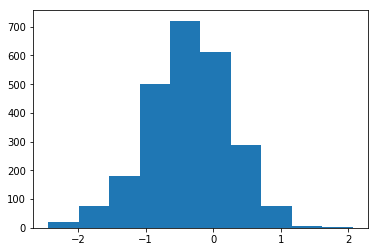

In [39]:
plt.hist(df_train["original_bias_score"])

In [40]:
df_train["original_bias_score"].abs().mean()

0.5631442379398383

In [41]:
df_train["bias_score_after"].abs().mean()

0.6150354372034518

The bias score does not seem to be evenly reduced

(array([207.,   0.,  10., 474., 324., 226., 509., 184., 329., 221.]),
 array([-1.35968649, -1.08596625, -0.81224601, -0.53852577, -0.26480553,
         0.00891471,  0.28263495,  0.55635519,  0.83007543,  1.10379567,
         1.37751591]),
 <a list of 10 Patch objects>)

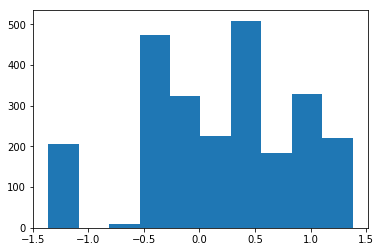

In [42]:
plt.hist(df_train["bias_score_after"])

In [43]:
df_train[df_train["bias_score_after"].abs() > df_train["original_bias_score"].abs()]

,sentence,fword,mword,target,p1,p2,prior_bias,original_bias_score,bias_score_after
0,[MASK] is accessible,she,he,accessible,4.865298e-03,0.012277,-1.501020,0.575404,0.834442
1,[MASK] is accessible,her,him,accessible,1.059399e-04,0.000095,-0.201257,0.307921,0.518240
2,[MASK] is accessible,woman,man,accessible,6.379329e-06,0.000050,-1.737486,-0.312989,1.021985
3,[MASK] is accessible,girl,boy,accessible,2.258840e-05,0.000023,0.006741,-0.036383,0.422075
4,[MASK] is accessible,sister,brother,accessible,3.628622e-06,0.000004,-0.069847,0.045879,-0.048473
5,[MASK] is accessible,daughter,son,accessible,3.038641e-06,0.000004,0.013902,-0.328705,-0.467729
6,[MASK] is accessible,wife,husband,accessible,2.532225e-06,0.000002,0.111183,0.140979,0.500700
7,[MASK] is accessible,girlfriend,boyfriend,accessible,3.096659e-06,0.000005,-1.249217,0.854755,1.340072
8,[MASK] is accessible,mother,father,accessible,2.404686e-05,0.000015,0.676304,-0.222323,-0.456434
11,[MASK] is accessible,grandmother,grandfather,accessible,1.587222e-05,0.000003,0.719977,0.909298,-1.236489


Evaluation on the validation set

In [44]:
df_val["bias_score_after"] = df_val.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/276 [00:00<?, ?it/s]

  1%|          | 2/276 [00:00<00:32,  8.56it/s]

  1%|          | 3/276 [00:00<00:31,  8.73it/s]

  2%|▏         | 5/276 [00:00<00:29,  9.21it/s]

  2%|▏         | 6/276 [00:00<00:29,  9.30it/s]

  3%|▎         | 7/276 [00:00<00:29,  9.03it/s]

  3%|▎         | 9/276 [00:00<00:28,  9.36it/s]

  4%|▎         | 10/276 [00:01<00:28,  9.47it/s]

  4%|▍         | 11/276 [00:01<00:28,  9.40it/s]

  4%|▍         | 12/276 [00:01<00:30,  8.62it/s]

  5%|▍         | 13/276 [00:01<00:29,  8.86it/s]

  5%|▌         | 14/276 [00:01<00:29,  8.92it/s]

  5%|▌         | 15/276 [00:01<00:29,  8.75it/s]

  6%|▌         | 16/276 [00:01<00:30,  8.60it/s]

  6%|▌         | 17/276 [00:01<00:29,  8.65it/s]

  7%|▋         | 19/276 [00:02<00:29,  8.79it/s]

  7%|▋         | 20/276 [00:02<00:29,  8.60it/s]

  8%|▊         | 21/276 [00:02<00:29,  8.72it/s]

  8%|▊         | 22/276 [00:02<00:29,  8.48it/s]

  8%|▊         | 23/276 [00:02<00:29,  8.50it/s]

  9%|▉         | 25/276 [00:02<00:27,  9.05it/s]

 10%|▉         | 27/276 [00:02<00:26,  9.48it/s]

 10%|█         | 28/276 [00:03<00:28,  8.58it/s]

 11%|█         | 29/276 [00:03<00:30,  8.21it/s]

 11%|█         | 30/276 [00:03<00:30,  7.98it/s]

 11%|█         | 31/276 [00:03<00:29,  8.26it/s]

 12%|█▏        | 32/276 [00:03<00:28,  8.41it/s]

 12%|█▏        | 33/276 [00:03<00:28,  8.48it/s]

 12%|█▏        | 34/276 [00:03<00:29,  8.21it/s]

 13%|█▎        | 35/276 [00:03<00:29,  8.27it/s]

 13%|█▎        | 36/276 [00:04<00:29,  8.07it/s]

 13%|█▎        | 37/276 [00:04<00:31,  7.64it/s]

 14%|█▍        | 38/276 [00:04<00:30,  7.69it/s]

 14%|█▍        | 39/276 [00:04<00:30,  7.84it/s]

 14%|█▍        | 40/276 [00:04<00:30,  7.62it/s]

 15%|█▍        | 41/276 [00:04<00:31,  7.56it/s]

 15%|█▌        | 42/276 [00:04<00:30,  7.79it/s]

 16%|█▌        | 43/276 [00:04<00:30,  7.71it/s]

 16%|█▌        | 44/276 [00:05<00:28,  8.14it/s]

 16%|█▋        | 45/276 [00:05<00:28,  8.21it/s]

 17%|█▋        | 46/276 [00:05<00:27,  8.25it/s]

 17%|█▋        | 47/276 [00:05<00:26,  8.52it/s]

 17%|█▋        | 48/276 [00:05<00:26,  8.65it/s]

 18%|█▊        | 49/276 [00:05<00:27,  8.37it/s]

 18%|█▊        | 50/276 [00:05<00:26,  8.41it/s]

 18%|█▊        | 51/276 [00:05<00:26,  8.39it/s]

 19%|█▉        | 52/276 [00:06<00:26,  8.45it/s]

 19%|█▉        | 53/276 [00:06<00:26,  8.37it/s]

 20%|█▉        | 54/276 [00:06<00:27,  8.15it/s]

 20%|█▉        | 55/276 [00:06<00:26,  8.26it/s]

 20%|██        | 56/276 [00:06<00:25,  8.47it/s]

 21%|██        | 57/276 [00:06<00:25,  8.53it/s]

 21%|██        | 58/276 [00:06<00:25,  8.45it/s]

 21%|██▏       | 59/276 [00:06<00:24,  8.71it/s]

 22%|██▏       | 60/276 [00:06<00:24,  8.89it/s]

 22%|██▏       | 61/276 [00:07<00:24,  8.77it/s]

 22%|██▏       | 62/276 [00:07<00:24,  8.65it/s]

 23%|██▎       | 63/276 [00:07<00:24,  8.52it/s]

 23%|██▎       | 64/276 [00:07<00:23,  8.84it/s]

 24%|██▎       | 65/276 [00:07<00:23,  9.03it/s]

 24%|██▍       | 67/276 [00:07<00:22,  9.35it/s]

 25%|██▌       | 69/276 [00:07<00:21,  9.64it/s]

 26%|██▌       | 71/276 [00:08<00:21,  9.75it/s]

 26%|██▌       | 72/276 [00:08<00:21,  9.44it/s]

 26%|██▋       | 73/276 [00:08<00:21,  9.58it/s]

 27%|██▋       | 74/276 [00:08<00:21,  9.46it/s]

 27%|██▋       | 75/276 [00:08<00:20,  9.59it/s]

 28%|██▊       | 76/276 [00:08<00:21,  9.38it/s]

 28%|██▊       | 77/276 [00:08<00:20,  9.49it/s]

 29%|██▊       | 79/276 [00:08<00:20,  9.74it/s]

 29%|██▉       | 81/276 [00:09<00:19,  9.90it/s]

 30%|███       | 83/276 [00:09<00:19, 10.01it/s]

 31%|███       | 85/276 [00:09<00:19,  9.96it/s]

 31%|███       | 86/276 [00:09<00:19,  9.92it/s]

 32%|███▏      | 88/276 [00:09<00:18, 10.06it/s]

 33%|███▎      | 90/276 [00:10<00:18,  9.93it/s]

 33%|███▎      | 92/276 [00:10<00:18, 10.10it/s]

 34%|███▍      | 94/276 [00:10<00:17, 10.20it/s]

 35%|███▍      | 96/276 [00:10<00:17, 10.13it/s]

 36%|███▌      | 98/276 [00:10<00:17, 10.06it/s]

 36%|███▌      | 100/276 [00:11<00:17, 10.16it/s]

 37%|███▋      | 102/276 [00:11<00:17,  9.85it/s]

 37%|███▋      | 103/276 [00:11<00:18,  9.27it/s]

 38%|███▊      | 104/276 [00:11<00:19,  8.94it/s]

 38%|███▊      | 105/276 [00:11<00:18,  9.15it/s]

 39%|███▉      | 107/276 [00:11<00:17,  9.39it/s]

 39%|███▉      | 108/276 [00:11<00:17,  9.36it/s]

 39%|███▉      | 109/276 [00:12<00:19,  8.47it/s]

 40%|███▉      | 110/276 [00:12<00:20,  8.25it/s]

 40%|████      | 111/276 [00:12<00:19,  8.48it/s]

 41%|████      | 112/276 [00:12<00:18,  8.63it/s]

 41%|████      | 113/276 [00:12<00:19,  8.33it/s]

 41%|████▏     | 114/276 [00:12<00:19,  8.42it/s]

 42%|████▏     | 115/276 [00:12<00:18,  8.76it/s]

 42%|████▏     | 117/276 [00:12<00:17,  9.20it/s]

 43%|████▎     | 119/276 [00:13<00:16,  9.35it/s]

 44%|████▍     | 121/276 [00:13<00:16,  9.62it/s]

 44%|████▍     | 122/276 [00:13<00:15,  9.73it/s]

 45%|████▍     | 123/276 [00:13<00:15,  9.73it/s]

 45%|████▌     | 125/276 [00:13<00:15,  9.71it/s]

 46%|████▌     | 126/276 [00:13<00:17,  8.68it/s]

 46%|████▋     | 128/276 [00:14<00:16,  9.12it/s]

 47%|████▋     | 129/276 [00:14<00:15,  9.31it/s]

 47%|████▋     | 131/276 [00:14<00:15,  9.42it/s]

 48%|████▊     | 132/276 [00:14<00:16,  8.61it/s]

 48%|████▊     | 133/276 [00:14<00:17,  8.15it/s]

 49%|████▊     | 134/276 [00:14<00:18,  7.80it/s]

 49%|████▉     | 136/276 [00:15<00:16,  8.28it/s]

 50%|████▉     | 137/276 [00:15<00:16,  8.56it/s]

 50%|█████     | 138/276 [00:15<00:15,  8.66it/s]

 50%|█████     | 139/276 [00:15<00:15,  8.75it/s]

 51%|█████     | 140/276 [00:15<00:15,  8.69it/s]

 51%|█████     | 141/276 [00:15<00:15,  8.75it/s]

 51%|█████▏    | 142/276 [00:15<00:14,  8.99it/s]

 52%|█████▏    | 143/276 [00:15<00:15,  8.63it/s]

 52%|█████▏    | 144/276 [00:15<00:15,  8.36it/s]

 53%|█████▎    | 145/276 [00:16<00:17,  7.67it/s]

 53%|█████▎    | 146/276 [00:16<00:16,  7.72it/s]

 53%|█████▎    | 147/276 [00:16<00:16,  7.92it/s]

 54%|█████▎    | 148/276 [00:16<00:15,  8.10it/s]

 54%|█████▍    | 149/276 [00:16<00:15,  8.27it/s]

 54%|█████▍    | 150/276 [00:16<00:14,  8.41it/s]

 55%|█████▌    | 152/276 [00:16<00:14,  8.72it/s]

 55%|█████▌    | 153/276 [00:17<00:14,  8.65it/s]

 56%|█████▌    | 154/276 [00:17<00:14,  8.63it/s]

 56%|█████▌    | 155/276 [00:17<00:14,  8.54it/s]

 57%|█████▋    | 156/276 [00:17<00:14,  8.42it/s]

 57%|█████▋    | 157/276 [00:17<00:13,  8.58it/s]

 57%|█████▋    | 158/276 [00:17<00:13,  8.88it/s]

 58%|█████▊    | 159/276 [00:17<00:12,  9.15it/s]

 58%|█████▊    | 160/276 [00:17<00:12,  8.94it/s]

 58%|█████▊    | 161/276 [00:17<00:12,  9.02it/s]

 59%|█████▊    | 162/276 [00:18<00:12,  9.08it/s]

 59%|█████▉    | 163/276 [00:18<00:12,  9.06it/s]

 59%|█████▉    | 164/276 [00:18<00:12,  8.98it/s]

 60%|█████▉    | 165/276 [00:18<00:12,  8.96it/s]

 60%|██████    | 166/276 [00:18<00:12,  8.47it/s]

 61%|██████    | 167/276 [00:18<00:13,  8.26it/s]

 61%|██████    | 168/276 [00:18<00:13,  8.03it/s]

 62%|██████▏   | 170/276 [00:18<00:12,  8.55it/s]

 62%|██████▏   | 172/276 [00:19<00:11,  8.98it/s]

 63%|██████▎   | 174/276 [00:19<00:10,  9.46it/s]

 64%|██████▍   | 176/276 [00:19<00:10,  9.70it/s]

 64%|██████▍   | 178/276 [00:19<00:09,  9.91it/s]

 65%|██████▌   | 180/276 [00:19<00:09, 10.18it/s]

 66%|██████▌   | 182/276 [00:20<00:09, 10.30it/s]

 67%|██████▋   | 184/276 [00:20<00:08, 10.34it/s]

 67%|██████▋   | 186/276 [00:20<00:08, 10.36it/s]

 68%|██████▊   | 188/276 [00:20<00:08, 10.47it/s]

 69%|██████▉   | 190/276 [00:20<00:08, 10.54it/s]

 70%|██████▉   | 192/276 [00:21<00:07, 10.64it/s]

 70%|███████   | 194/276 [00:21<00:07, 10.32it/s]

 71%|███████   | 196/276 [00:21<00:07, 10.26it/s]

 72%|███████▏  | 198/276 [00:21<00:07,  9.96it/s]

 72%|███████▏  | 200/276 [00:21<00:07, 10.07it/s]

 73%|███████▎  | 202/276 [00:22<00:07, 10.14it/s]

 74%|███████▍  | 204/276 [00:22<00:07, 10.14it/s]

 75%|███████▍  | 206/276 [00:22<00:06, 10.15it/s]

 75%|███████▌  | 208/276 [00:22<00:06, 10.16it/s]

 76%|███████▌  | 210/276 [00:22<00:07,  8.88it/s]

 76%|███████▋  | 211/276 [00:23<00:07,  9.11it/s]

 77%|███████▋  | 212/276 [00:23<00:06,  9.17it/s]

 77%|███████▋  | 213/276 [00:23<00:06,  9.04it/s]

 78%|███████▊  | 214/276 [00:23<00:06,  9.14it/s]

 78%|███████▊  | 215/276 [00:23<00:06,  9.26it/s]

 78%|███████▊  | 216/276 [00:23<00:06,  9.15it/s]

 79%|███████▊  | 217/276 [00:23<00:06,  9.23it/s]

 79%|███████▉  | 218/276 [00:23<00:06,  9.01it/s]

 79%|███████▉  | 219/276 [00:23<00:06,  9.04it/s]

 80%|███████▉  | 220/276 [00:24<00:06,  8.93it/s]

 80%|████████  | 221/276 [00:24<00:06,  8.83it/s]

 80%|████████  | 222/276 [00:24<00:06,  8.94it/s]

 81%|████████  | 223/276 [00:24<00:05,  9.01it/s]

 81%|████████  | 224/276 [00:24<00:05,  8.85it/s]

 82%|████████▏ | 225/276 [00:24<00:05,  8.78it/s]

 82%|████████▏ | 226/276 [00:24<00:05,  8.72it/s]

 82%|████████▏ | 227/276 [00:24<00:05,  8.25it/s]

 83%|████████▎ | 228/276 [00:24<00:05,  8.59it/s]

 83%|████████▎ | 229/276 [00:25<00:05,  8.74it/s]

 83%|████████▎ | 230/276 [00:25<00:05,  8.24it/s]

 84%|████████▎ | 231/276 [00:25<00:05,  7.95it/s]

 84%|████████▍ | 233/276 [00:25<00:04,  8.70it/s]

 85%|████████▌ | 235/276 [00:25<00:04,  9.30it/s]

 86%|████████▌ | 236/276 [00:25<00:04,  9.11it/s]

 86%|████████▌ | 237/276 [00:25<00:04,  8.64it/s]

 86%|████████▌ | 238/276 [00:26<00:05,  7.58it/s]

 87%|████████▋ | 239/276 [00:26<00:04,  7.81it/s]

 87%|████████▋ | 240/276 [00:26<00:04,  7.82it/s]

 87%|████████▋ | 241/276 [00:26<00:04,  7.45it/s]

 88%|████████▊ | 242/276 [00:26<00:04,  7.27it/s]

 88%|████████▊ | 243/276 [00:26<00:04,  6.90it/s]

 88%|████████▊ | 244/276 [00:26<00:04,  7.17it/s]

 89%|████████▉ | 245/276 [00:27<00:04,  7.39it/s]

 89%|████████▉ | 246/276 [00:27<00:03,  7.55it/s]

 89%|████████▉ | 247/276 [00:27<00:03,  7.85it/s]

 90%|████████▉ | 248/276 [00:27<00:03,  7.94it/s]

 90%|█████████ | 249/276 [00:27<00:03,  8.04it/s]

 91%|█████████ | 250/276 [00:27<00:03,  8.35it/s]

 91%|█████████ | 251/276 [00:27<00:02,  8.69it/s]

 91%|█████████▏| 252/276 [00:27<00:02,  8.90it/s]

 92%|█████████▏| 253/276 [00:27<00:02,  8.78it/s]

 92%|█████████▏| 254/276 [00:28<00:02,  8.63it/s]

 92%|█████████▏| 255/276 [00:28<00:02,  8.37it/s]

 93%|█████████▎| 256/276 [00:28<00:02,  7.99it/s]

 93%|█████████▎| 257/276 [00:28<00:02,  8.14it/s]

 93%|█████████▎| 258/276 [00:28<00:02,  8.43it/s]

 94%|█████████▍| 259/276 [00:28<00:02,  8.32it/s]

 94%|█████████▍| 260/276 [00:28<00:02,  7.84it/s]

 95%|█████████▍| 261/276 [00:28<00:01,  7.97it/s]

 95%|█████████▍| 262/276 [00:29<00:01,  8.19it/s]

 95%|█████████▌| 263/276 [00:29<00:01,  8.14it/s]

 96%|█████████▌| 264/276 [00:29<00:01,  7.78it/s]

 96%|█████████▌| 265/276 [00:29<00:01,  8.06it/s]

 96%|█████████▋| 266/276 [00:29<00:01,  8.11it/s]

 97%|█████████▋| 267/276 [00:29<00:01,  8.26it/s]

 97%|█████████▋| 268/276 [00:29<00:00,  8.49it/s]

 97%|█████████▋| 269/276 [00:29<00:00,  8.51it/s]

 98%|█████████▊| 270/276 [00:30<00:00,  8.67it/s]

 98%|█████████▊| 271/276 [00:30<00:00,  8.66it/s]

 99%|█████████▊| 272/276 [00:30<00:00,  8.83it/s]

 99%|█████████▉| 274/276 [00:30<00:00,  9.21it/s]

100%|██████████| 276/276 [00:30<00:00,  9.54it/s]

(array([ 1.,  4.,  4., 11., 38., 63., 66., 56., 29.,  4.]),
 array([-2.98104119, -2.5734925 , -2.16594381, -1.75839512, -1.35084643,
        -0.94329774, -0.53574905, -0.12820036,  0.27934833,  0.68689702,
         1.09444571]),
 <a list of 10 Patch objects>)

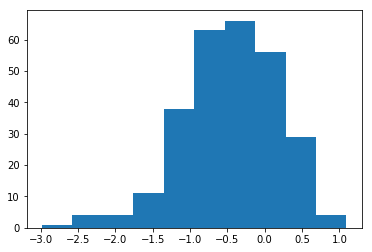

In [45]:
plt.hist(df_val["original_bias_score"])

(array([23.,  0.,  2., 54., 35., 24., 52., 25., 36., 25.]),
 array([-1.34195459, -1.07171583, -0.80147707, -0.53123832, -0.26099956,
         0.0092392 ,  0.27947795,  0.54971671,  0.81995547,  1.09019423,
         1.36043298]),
 <a list of 10 Patch objects>)

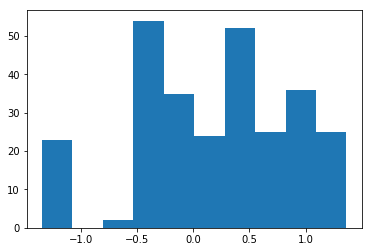

In [46]:
plt.hist(df_val["bias_score_after"])

In [47]:
df_val["original_bias_score"].abs().mean()

0.6147687844932079

In [48]:
df_val["bias_score_after"].abs().mean()

0.6126786984395289

# Unintended Side Effects

Are there any unintended side effects of this transformation? Let's test and see

In [49]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The doctor went to the office.", "doctor"))
)

-0.05279458

In [50]:
 def construct_sim_matrix_df(cws: List[ContextWord]):
    return pd.DataFrame(data=sim, index=words, columns=words)

Before processing:

In [51]:
cws = [
    ContextWord("The programmer went to the office.", "programmer"),
    ContextWord("The doctor went to the office.", "doctor"),
    ContextWord("The nurse went to the office.", "nurse"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.736333,0.710306
doctor,0.736333,1.000000,0.758742
nurse,0.710306,0.758742,1.000000


After processing:

In [52]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.740371,0.715518
doctor,0.740371,1.000000,0.763563
nurse,0.715518,0.763563,1.000000


Interestingly, the similarities here seem to be roughly preserved; perhaps because we are neutralizing w.r.t to the gender dimension in the subject space, but not the object space?

In [53]:
cws = [
    ContextWord("Your colleague is very beautiful.", "beautiful"),
    ContextWord("Your colleague is very dangerous.", "dangerous"),
    ContextWord("Your colleague is very normal.", "normal"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.641661,0.568179
dangerous,0.641661,1.000000,0.568495
normal,0.568179,0.568495,1.000000


Again, not much reduction in similarities here...

In [54]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.657240,0.567063
dangerous,0.657240,1.000000,0.562291
normal,0.567063,0.562291,1.000000
